In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np

In [ ]:
def classify_smoking_status(row):
    if row['SMQ020'] == 2:
        return 'Never smoker'
    elif row['SMQ020'] == 1:
        if row['SMQ040'] == 3:
            return 'Former smoker'
        elif (row['SMQ040'] == 1) |  (row['SMQ040'] == 2):
            return 'Current smoker'
    return np.nan


In [ ]:
def eda_nhanesData(demo, bmx, mcq, smq):
    demo_new = demo[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2"]]
    bmx_new = bmx[["SEQN","BMXBMI"]]
    merge1 = pd.merge(demo_new,bmx_new,how='inner', on = 'SEQN')

    if "MCQ160O" not in mcq.columns:
        print("COPD variable not found — creating proxy from emphysema and chronic bronchitis.")
        mcq["MCQ160O"] = ((mcq["MCQ160K"] == 1) | (mcq["MCQ160G"] == 1)).astype(int)


    if "MCQ500" in mcq.columns:
        mcq_new = mcq[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ500", "MCQ160M","MCQ010"]]
    else:
        mcq_new = mcq[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160L", "MCQ160M","MCQ010"]]


    merge2 = pd.merge(merge1, mcq_new, how='inner', on = 'SEQN')
    smq_new = smq[["SEQN","SMQ040", "SMQ020"]]
    merge3 = pd.merge(merge2, smq_new, how='inner', on = 'SEQN')

    full_df = merge3.copy()
    full_df['smoking_status'] = full_df.apply(classify_smoking_status, axis=1)
    full_df = full_df[full_df['smoking_status'].notnull()]
    full_df['Gender'] = full_df['RIAGENDR'].map({1: 'Male', 2: 'Female'})

    race_map = {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        5: "Other / Multi-Racial"
    }

    full_df['Race_Ethnicity'] = full_df['RIDRETH1'].map(race_map)

    print('Number of observations in dataset: ', len(full_df))
    print()

    all_exSEQN = full_df.iloc[:,1:]

    print('Percent of missing values in each variable')
    print(all_exSEQN.isna().mean().sort_values(ascending=False))
    print()

    print('Summary of each variable')
    print(all_exSEQN.describe())
    print()


    print('# of respondents by smoking status')
    print(all_exSEQN.groupby(['smoking_status']).size())

    print('# and % of respondents by smoking status')
    smoking_counts = all_exSEQN['smoking_status'].value_counts(dropna=False)
    smoking_percent = smoking_counts / smoking_counts.sum() * 100

    summary_df = pd.DataFrame({
        'Count': smoking_counts,
        'Percent': smoking_percent.round(2)
    })

    print(summary_df)


    print()
    print("Gender")
    print()
    print(all_exSEQN["Gender"].value_counts()/len(all_exSEQN)*100)


    print()
    print("Race Ethnicity")
    print()
    print(all_exSEQN["Race_Ethnicity"].value_counts()/len(all_exSEQN)*100)

    bins = list(range(0, 100, 10))
    labels = [f"{b}-{b+9}" for b in bins[:-1]]
    all_exSEQN['AgeGroup'] = pd.cut(all_exSEQN['RIDAGEYR'], bins=bins, labels=labels, right=False)

    age_group_counts = all_exSEQN['AgeGroup'].value_counts(dropna=False).sort_index()
    age_group_percent = (age_group_counts / age_group_counts.sum() * 100).round(2)

    age_group_table = pd.DataFrame({
        'Count': age_group_counts,
        'Percent (%)': age_group_percent
    })

    print("\nProportion of Each Age Group in the Full Dataset")
    print(age_group_table)
    print()


    age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
    age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')
    age_smoke_counts['proportion'] = age_smoke_counts['count'] / age_group_totals

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=age_smoke_counts,
        x='AgeGroup',
        y='proportion',
        hue='smoking_status',
        palette='Set2'
    )
    plt.title("Proportion of Smoking Status by Age Group")
    plt.ylabel("Proportion within Age Group")
    plt.xlabel("Age Group")
    plt.xticks(rotation=45)
    plt.legend(title="Smoking Status")
    plt.show()

    sns.histplot(data = all_exSEQN, x= "RIDAGEYR", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Age by Smoking Category")
    plt.show()

    mean_bmi = all_exSEQN.groupby('smoking_status')['BMXBMI'].mean()
    median_bmi = all_exSEQN.groupby('smoking_status')['BMXBMI'].median()

    bmi_summary = pd.DataFrame({
        'Mean BMI': mean_bmi,
        'Median BMI': median_bmi
    }).round(2)

    print('BMI Summary')
    print(bmi_summary)
    print()

    sns.histplot(data = all_exSEQN, x= "BMXBMI", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of BMI by Smoking Category")
    plt.show()


    sns.histplot(data = all_exSEQN, x= "Gender", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Smoking Category by Gender")
    plt.show()

    sns.countplot(
        data=all_exSEQN,
        x="Race_Ethnicity",
        hue="smoking_status",
        palette='Set2'
    )
    plt.title("Race-Ethnicity Distribution by Smoking Status")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.show()




    mean_annual_income = all_exSEQN.groupby('smoking_status')['INDHHIN2'].mean()
    median_annual_income = all_exSEQN.groupby('smoking_status')['INDHHIN2'].median()
    income_summary = pd.DataFrame({
        'Mean Annual Income': mean_annual_income,
        'Median Annual INcome': median_annual_income
    }).round(2)

    print('Income summary')
    print(income_summary)
    print()



    all_exSEQN_less20 = all_exSEQN[all_exSEQN["INDHHIN2"] < 20]
    sns.displot(data = all_exSEQN_less20, x= "INDHHIN2", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Annual Income by Smoking Category")
    plt.show()

    disease_vars = [col for col in all_exSEQN.columns if "MCQ" in col]

    all_exSEQN = all_exSEQN.copy()
    for var in disease_vars:
        all_exSEQN[var] = all_exSEQN[var].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})

    smoking_order = ["Never smoker", "Former smoker", "Current smoker"]
    for var in disease_vars:
        temp = (
            all_exSEQN
            .groupby("smoking_status")[var]
            .mean()
            .mul(100)
            .reset_index()
            .rename(columns={var: "Prevalence (%)"})
        )

        sns.barplot(data=temp, x="smoking_status", y="Prevalence (%)", color="skyblue", order=smoking_order)
        plt.title(f"Prevalence of {var} by Smoking Status (%)")
        plt.xlabel("Smoking Status")
        plt.ylabel("Percent with Condition")
        plt.xticks(rotation=30)
        plt.show()

    gender_order = ["Female", "Male"]

    for var in disease_vars:
        temp = (
            all_exSEQN
            .groupby("Gender")[var]
            .mean()
            .mul(100)
            .reset_index()
            .rename(columns={var: "Prevalence (%)"})
        )
        sns.barplot(data=temp, x="Gender", y="Prevalence (%)", color="skyblue", order=gender_order)
        plt.title(f"Prevalence of {var} by Gender (%)")
        plt.ylabel("Percent with Condition")
        plt.xlabel("Gender")
        plt.ylim(0, temp["Prevalence (%)"].max() * 1.15)
        for i, p in enumerate(temp["Prevalence (%)"]):
            plt.text(i, p * 1.02, f"{p:.1f}%", ha='center')
        plt.show()

    confounders = ["RIDAGEYR","INDHHIN2","BMXBMI"]
    for var in confounders:
        sns.boxplot(data=all_exSEQN, x="smoking_status", y=var)
        plt.title(f"{var} by Smoking Status")
        plt.show()

    sns.countplot(data=all_exSEQN, x="Gender", hue="smoking_status", palette='Set2')
    plt.title("Gender Distribution by Smoking Status")
    plt.ylabel("Count")
    plt.show()

    sns.boxplot(x=all_exSEQN["BMXBMI"])
    plt.title("BMI Distribution")
    plt.show()

    sns.boxplot(x=all_exSEQN["RIDAGEYR"])
    plt.title("Age Distribution")
    plt.show()

    sns.countplot(data=all_exSEQN, x="Gender", hue="smoking_status")
    plt.title("Gender Balance by Smoking Status")
    plt.show()



# 2017-2018

Number of observations in dataset:  5533

Percent of missing values in each variable
MCQ500            0.951563
SMQ040            0.596602
INDHHIN2          0.050967
MCQ160O           0.048437
MCQ160M           0.048437
MCQ220            0.048437
MCQ160E           0.048437
MCQ160K           0.048437
MCQ160F           0.048437
MCQ160B           0.048437
MCQ160C           0.048437
BMXBMI            0.017893
RIDRETH1          0.000000
RIAGENDR          0.000000
RIDAGEYR          0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
          RIDAGEYR     RIAGENDR     RIDRETH1    INDHHIN2       BMXBMI  \
count  5533.000000  5533.000000  5533.000000  5251.00000  5434.000000   
mean     49.816555     1.517079     3.257003    12.64940    29.691700   
std      18.649364     0.499753     1.258991    17.68825     7.440481   
min      18.000000     1.000000     1.0000

/tmp/ipython-input-522425905.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
/tmp/ipython-input-522425905.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


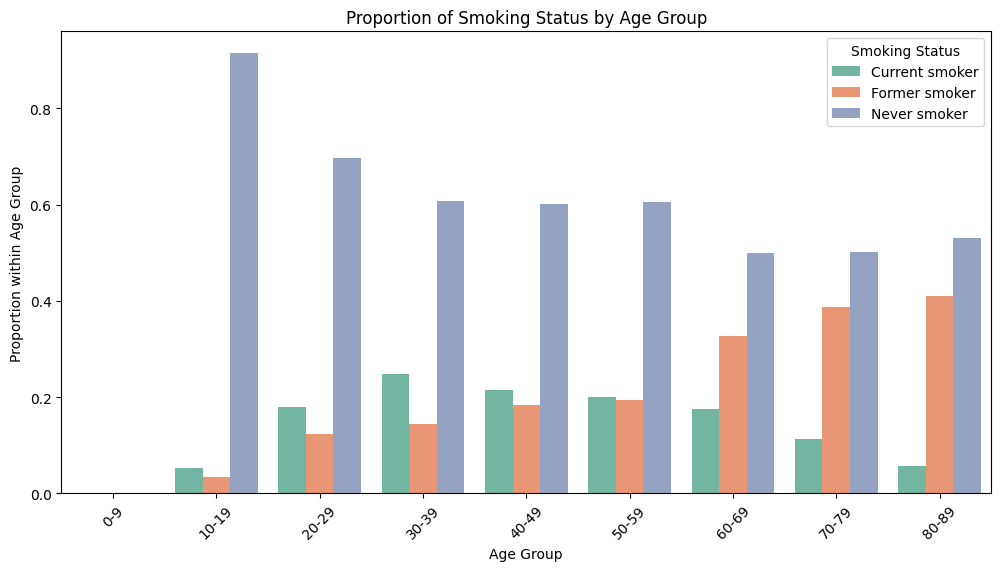

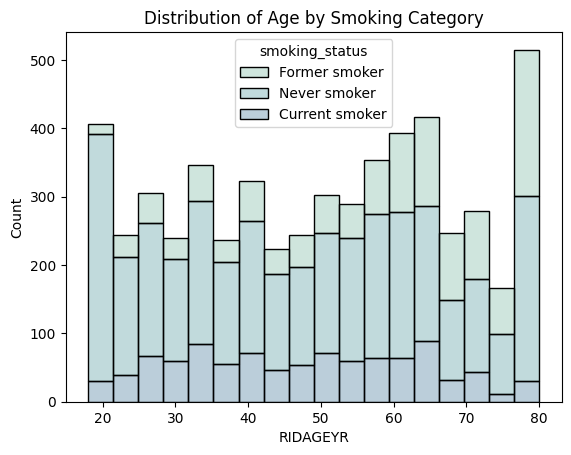

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     29.07       27.80
Former smoker      30.78       29.50
Never smoker       29.46       28.25



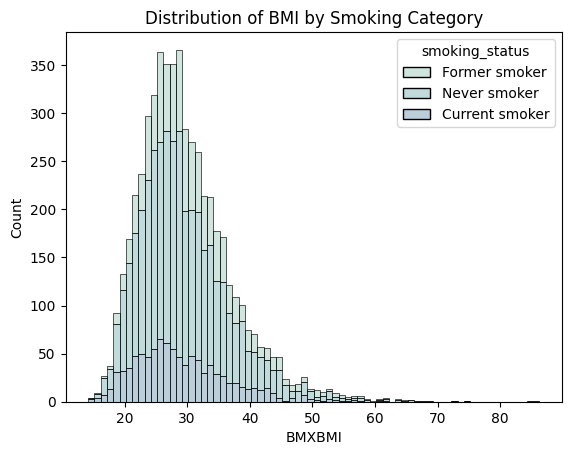

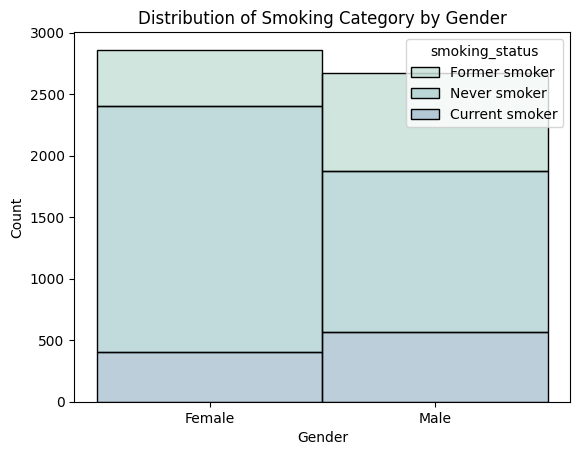

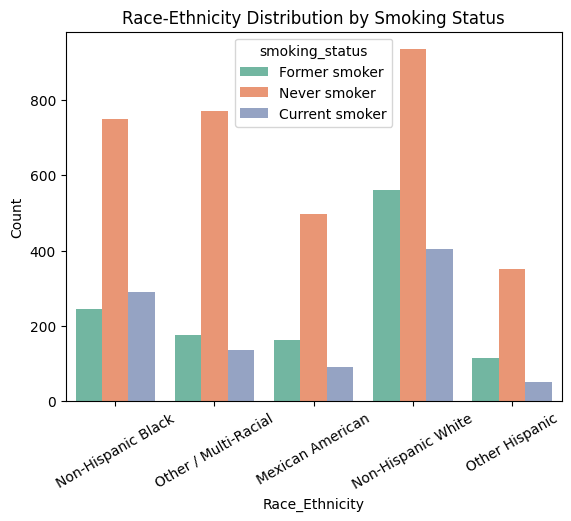

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker               11.44                   7.0
Former smoker                10.84                   8.0
Never smoker                 13.70                   9.0



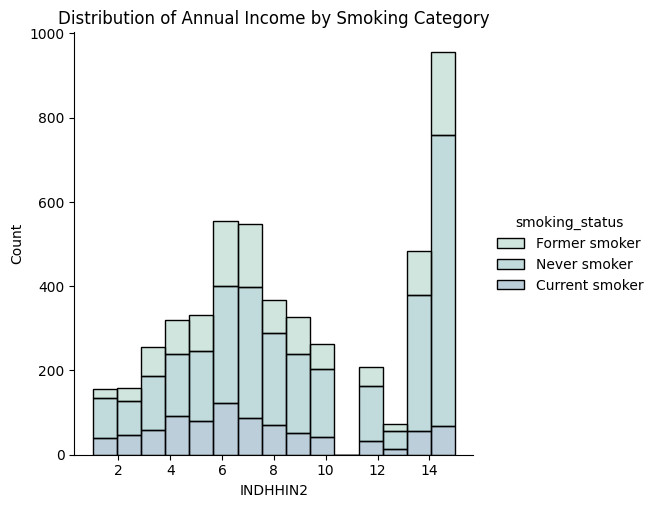

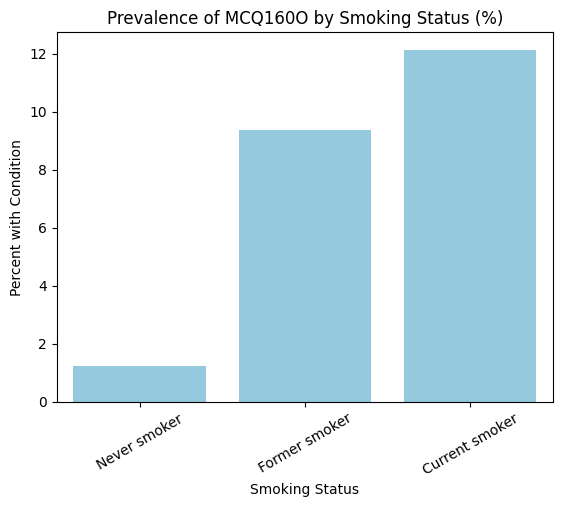

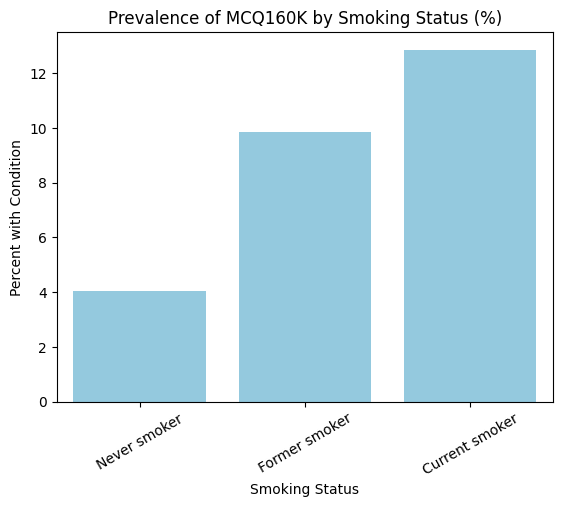

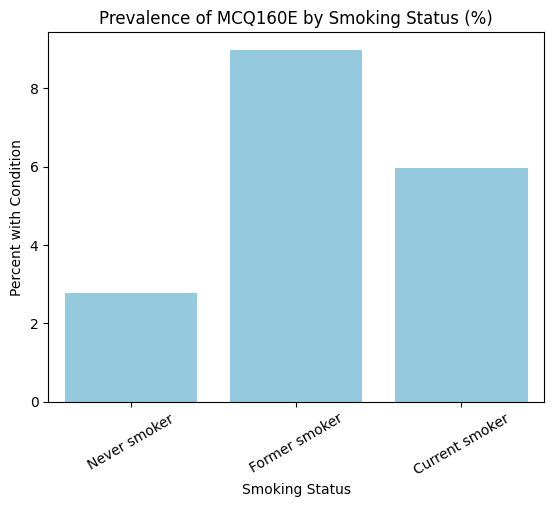

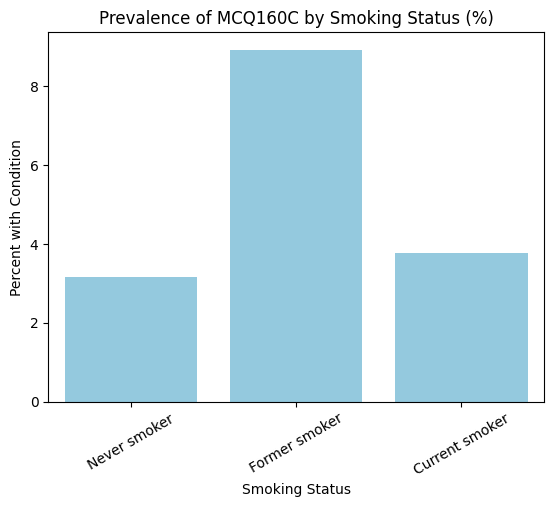

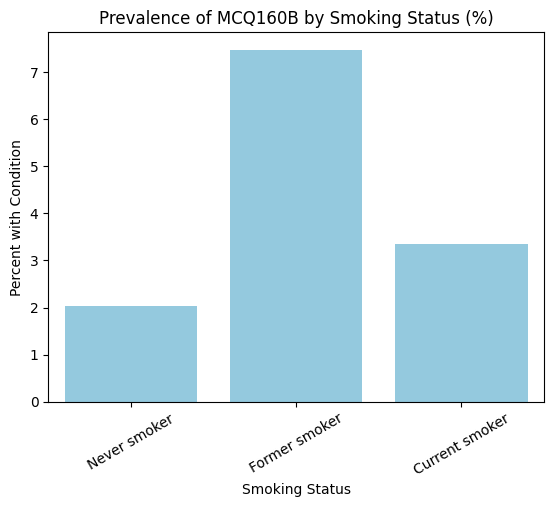

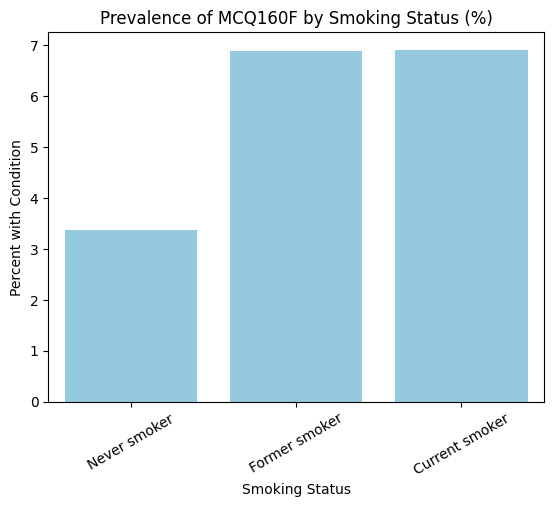

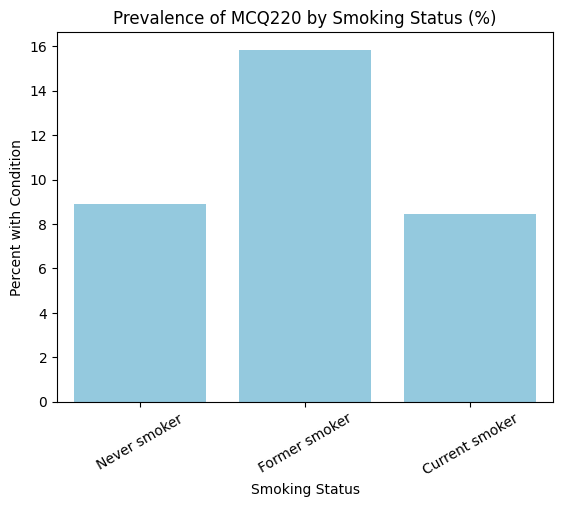

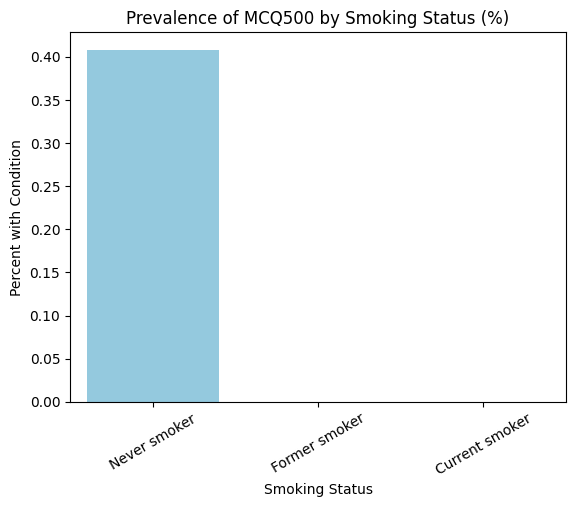

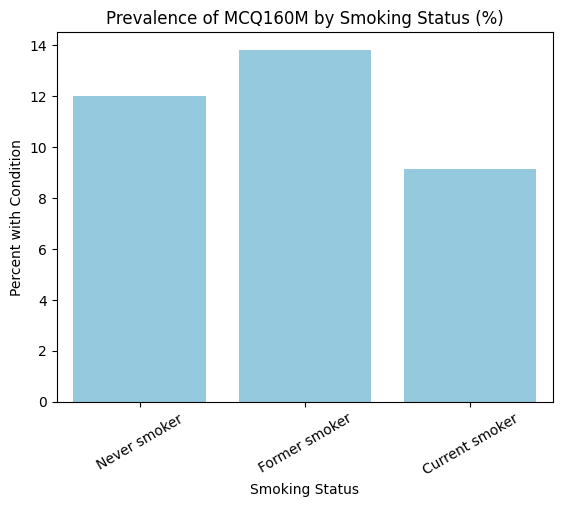

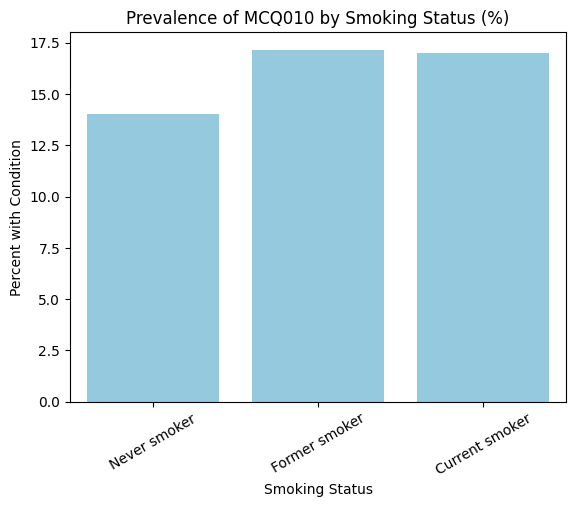

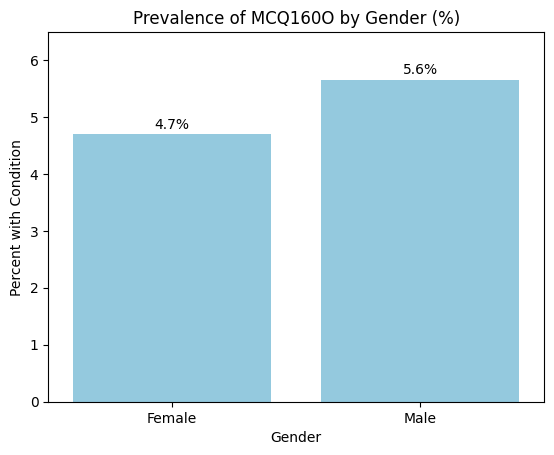

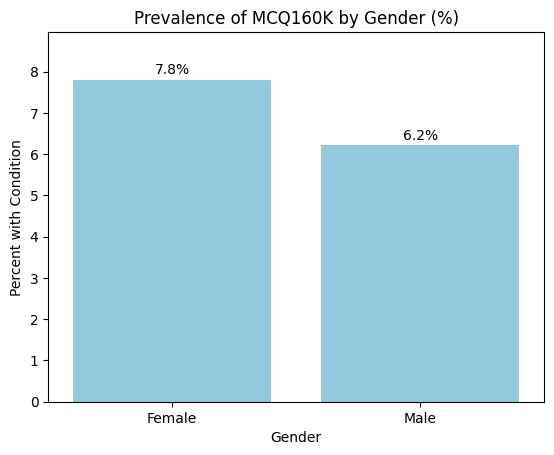

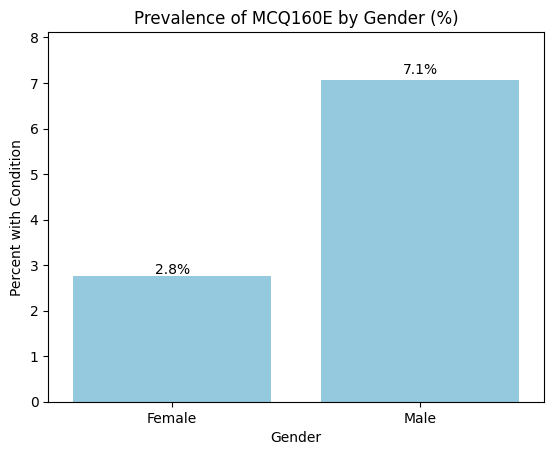

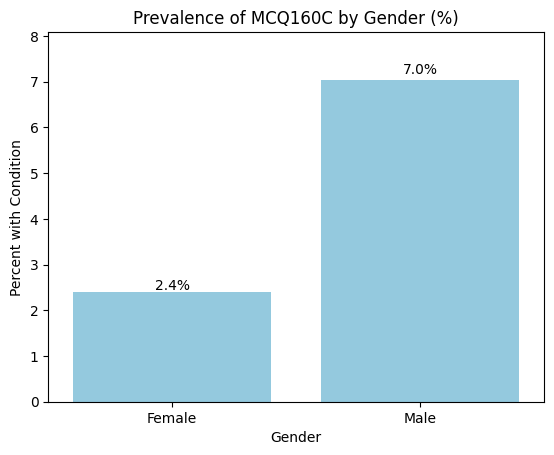

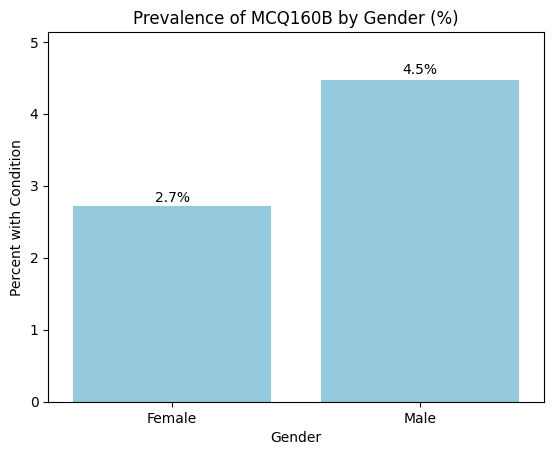

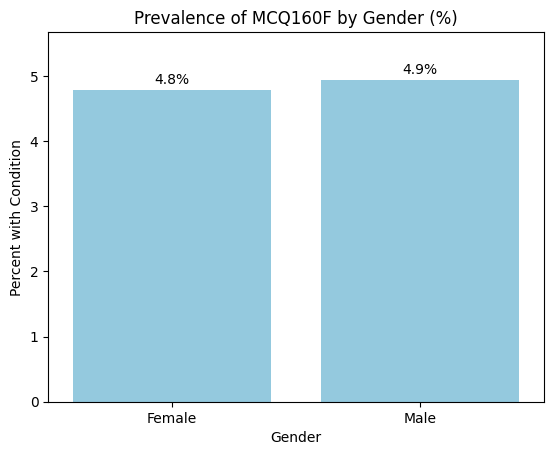

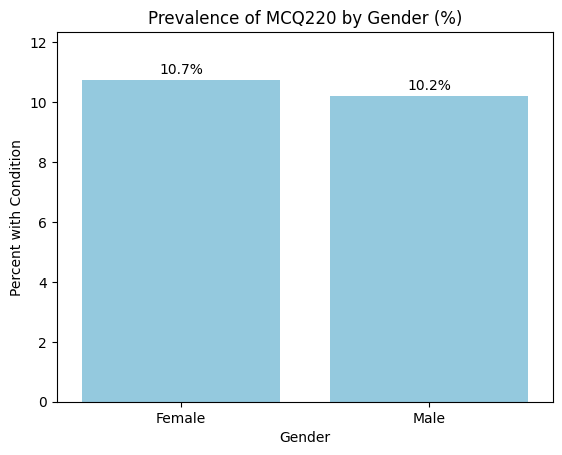

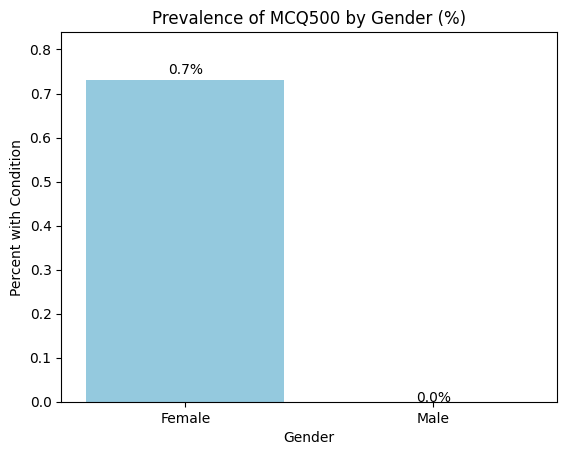

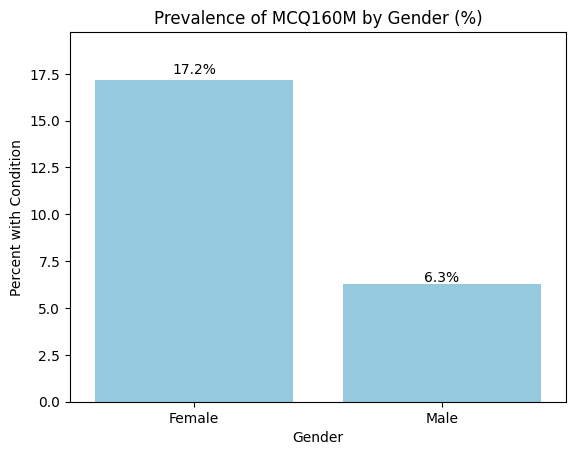

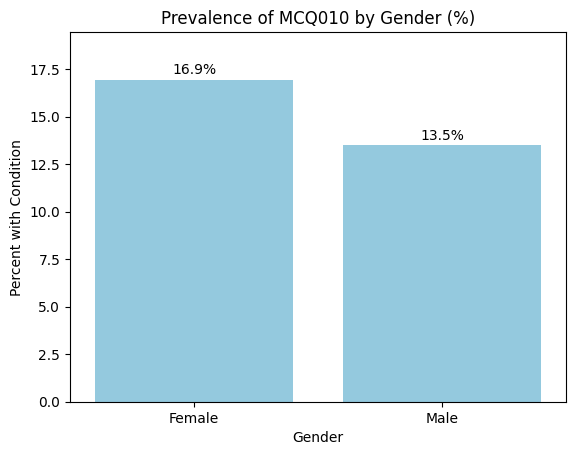

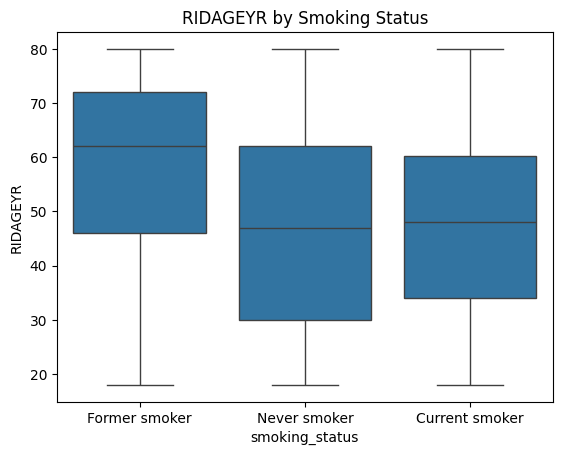

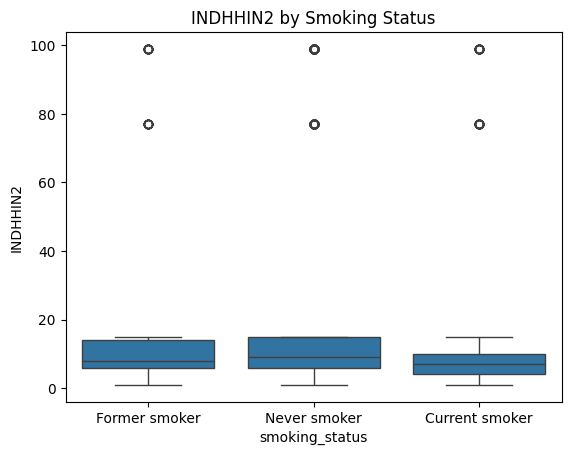

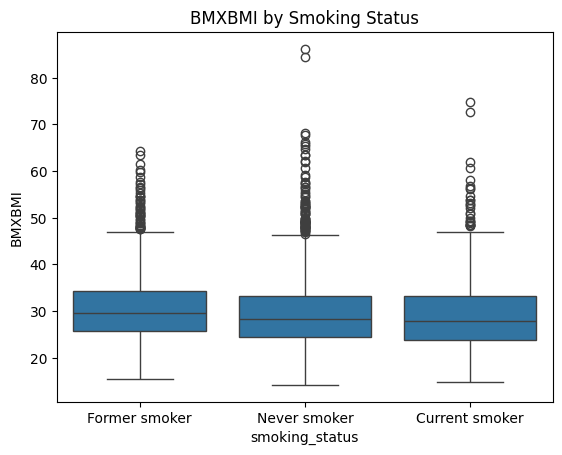

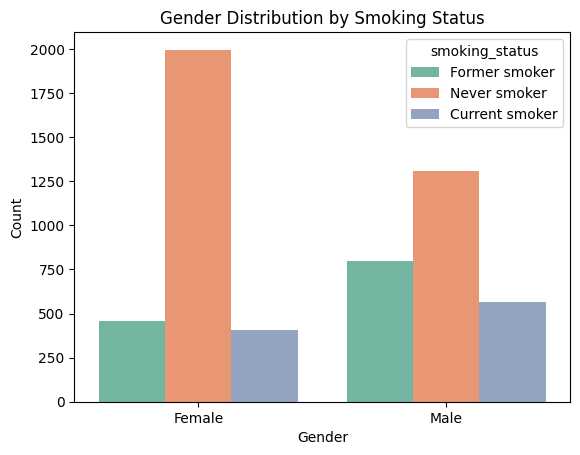

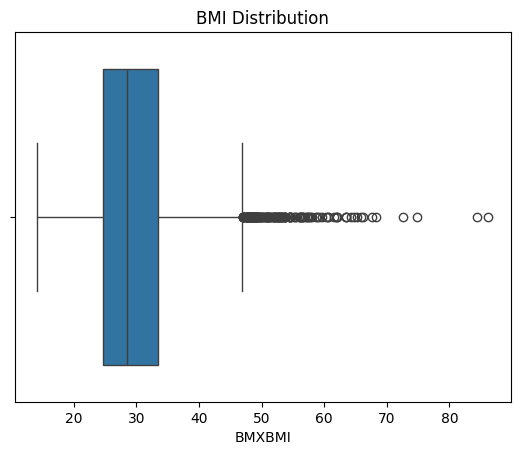

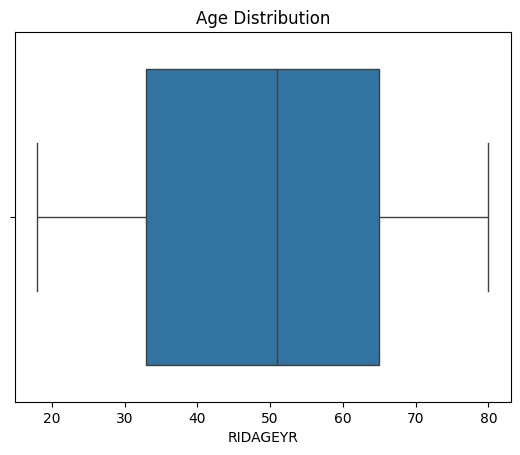

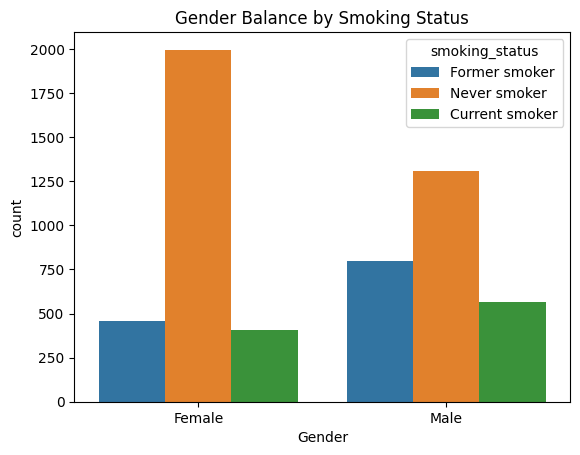

In [ ]:
demo = pd.read_sas('DEMO_J.xpt')
bmx = pd.read_sas('BMX_J.xpt')
mcq = pd.read_sas('MCQ_J.xpt')
smq = pd.read_sas('SMQ_J.xpt')

eda_nhanesData(demo, bmx, mcq, smq)

Takeaways:

1. 5,533 observations / individuals are included in the dataset.
2. 95% of values in MCQ500 are missing, so this column needs to be dropped.
3. Other variables have quite low missingness. The final dataset ensures no missing values for the smoking_status field.
4. The mean age is 49.8 years; the median age is 51 years.
5. Former smokers have the highest median age. Never smokers and current smokers have similar median ages.
6. 52% of respondents are female; 48% are male.
7. Race / ethnicity distribution: 34% Non-Hispanic White, 23% Non-Hispanic Black, 20% Other / Multi-Racial, 9% Other Hispanic.
8. Across all age groups, there are more never smokers than current or former smokers.
9. Age groups 10–59: more current smokers than former smokers. Age groups 60–89: more former smokers than current smokers.
10. BMI is right-skewed across all smoking statuses. Median BMI: current smokers 27.80, former smokers 29.50, never smokers 28.25.
11. Gender patterns in smoking:
Higher proportion of females have never smoked compared to males.
*   Lower proportion of females are former smokers compared to males.
*   Lower proportion of females are current smokers compared to males.
12. Race / ethnicity patterns in smoking:
*   More never smokers than current or former smokers in all groups.
*   Other / Multi-Racial, Mexican American, Non-Hispanic White, and Other Hispanic: more former smokers than current smokers. Non-Hispanic Black: more current smokers than former smokers.
13. Annual income is right-skewed across all smoking statuses. Median income: highest in never smokers, followed by former smokers, then current smokers.
14. Disease prevalence by smoking status:
*   MCQ160O and MCQ160K: higher prevalence in current smokers than former or never smokers.
*   MCQ160E, MCQ160C, MCQ160B, MCQ220, MCQ160M: higher prevalence in former smokers than current or never smokers.
*   MCQ160F and MCQ010: similar prevalence between former and current smokers, but were both higher than never-smokers.










# 2015-2016

Number of observations in dataset:  5725

Percent of missing values in each variable
SMQ040            0.594934
MCQ160K           0.045590
MCQ160O           0.045590
MCQ160E           0.045590
MCQ160M           0.045590
MCQ160L           0.045590
MCQ220            0.045590
MCQ160C           0.045590
MCQ160F           0.045590
MCQ160B           0.045590
INDHHIN2          0.033712
BMXBMI            0.012751
RIDRETH1          0.000000
RIAGENDR          0.000000
RIDAGEYR          0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
         RIDAGEYR     RIAGENDR     RIDRETH1     INDHHIN2       BMXBMI  \
count  5725.00000  5725.000000  5725.000000  5532.000000  5652.000000   
mean     48.02917     1.519127     3.042969    11.459328    29.382696   
std      18.41959     0.499678     1.296762    15.246352     7.097712   
min      18.00000     1.000000     1.00000

/tmp/ipython-input-522425905.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
/tmp/ipython-input-522425905.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


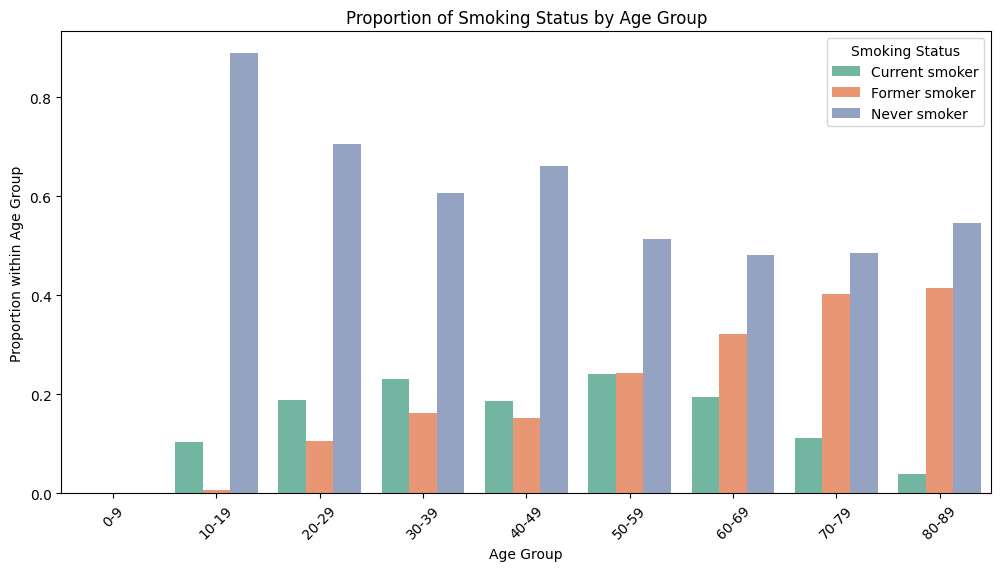

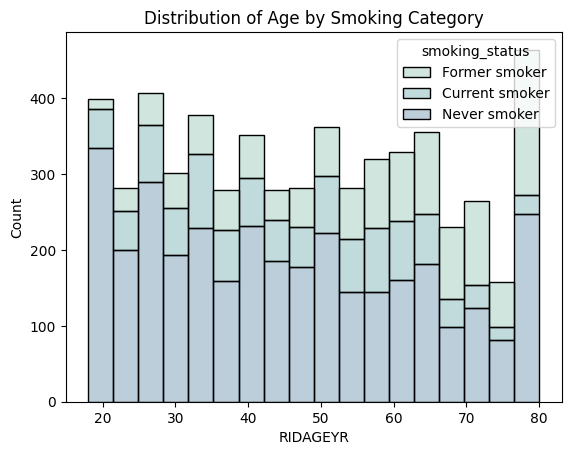

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     28.90       27.65
Former smoker      30.17       29.10
Never smoker       29.24       28.10



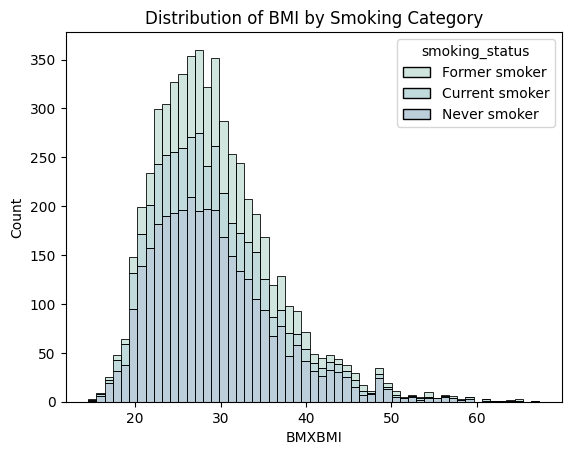

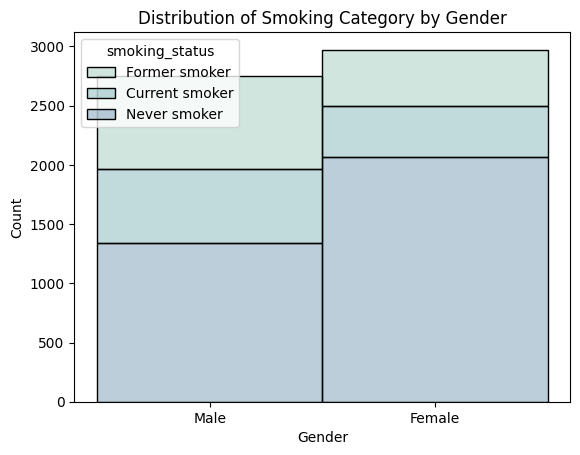

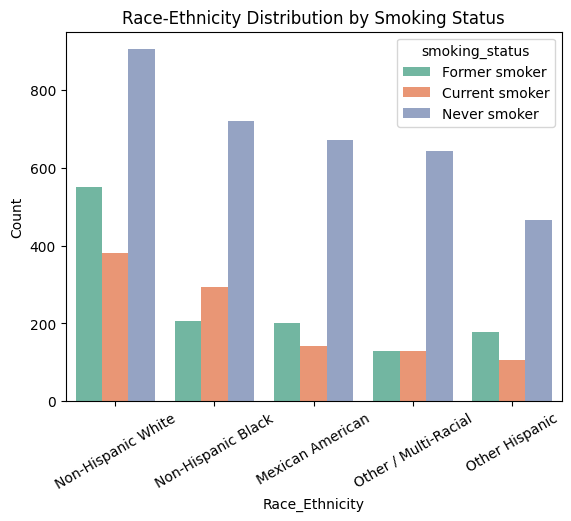

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker               10.04                   7.0
Former smoker                10.89                   8.0
Never smoker                 12.11                   8.0



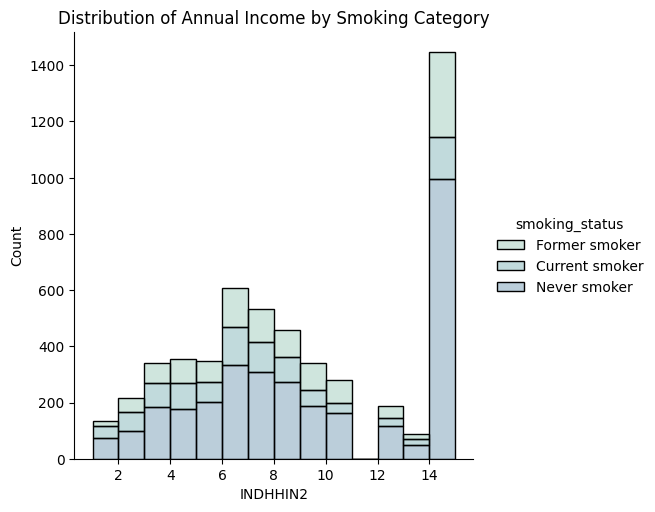

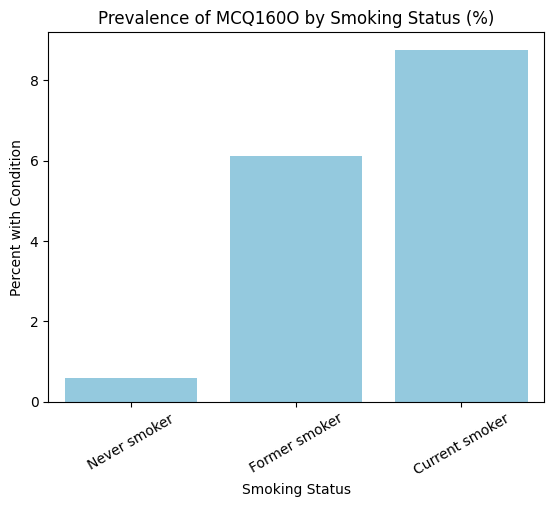

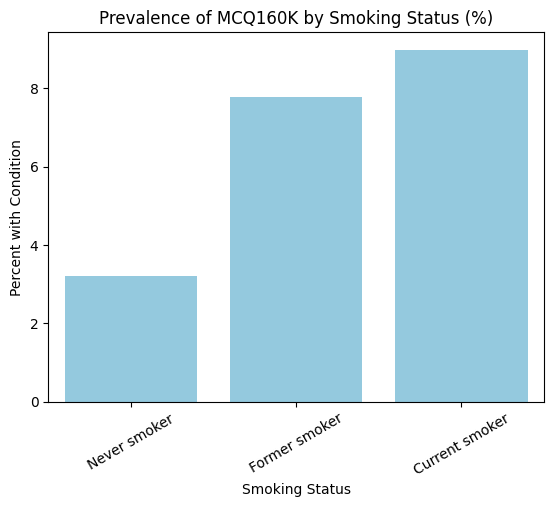

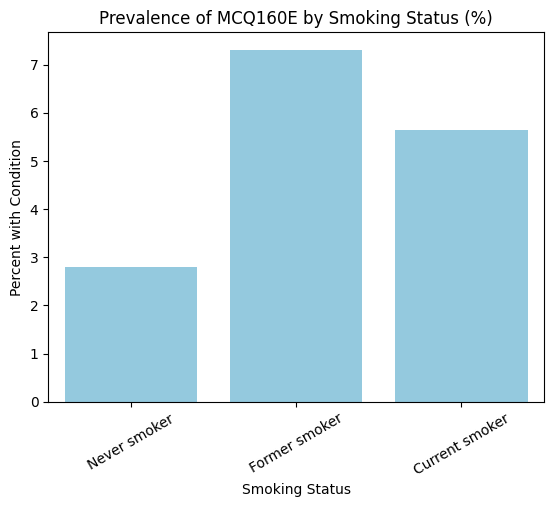

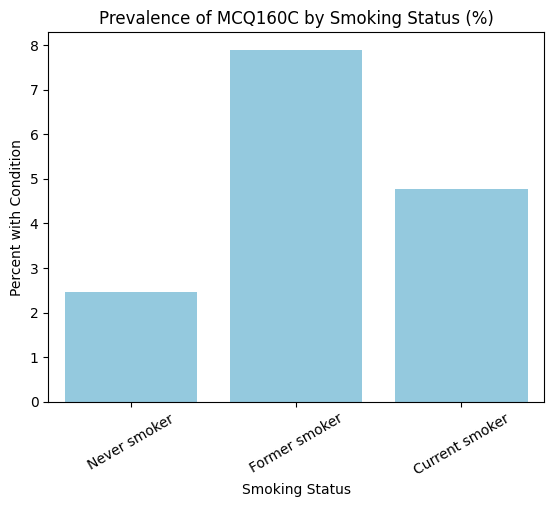

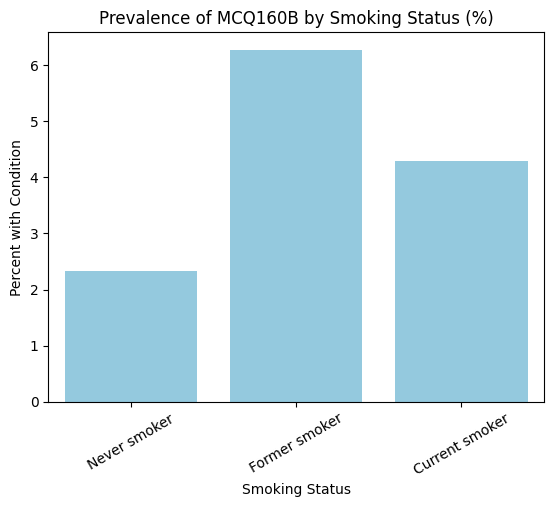

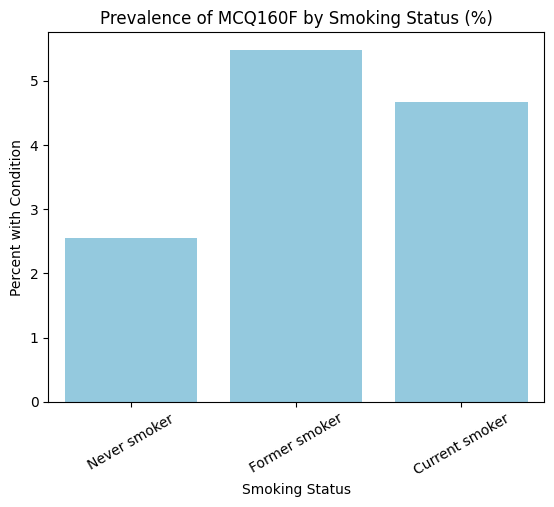

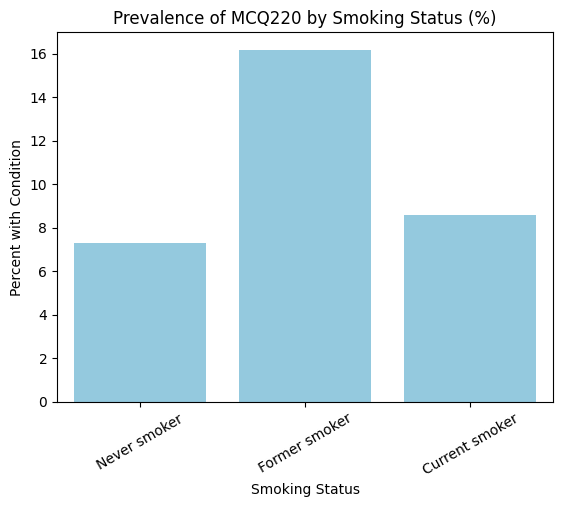

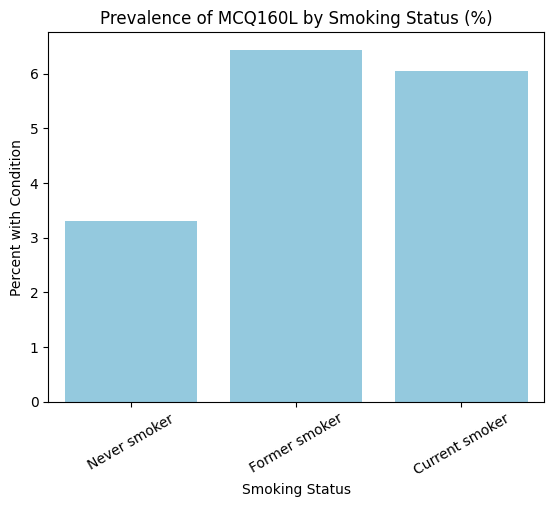

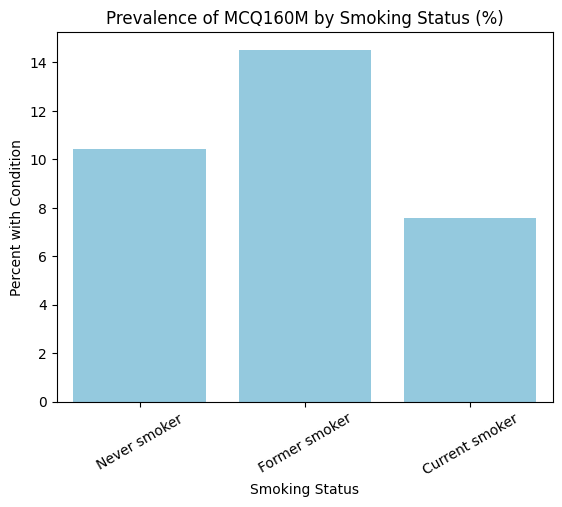

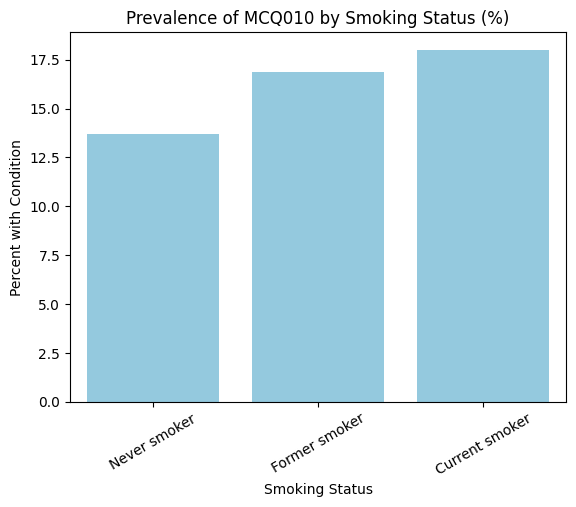

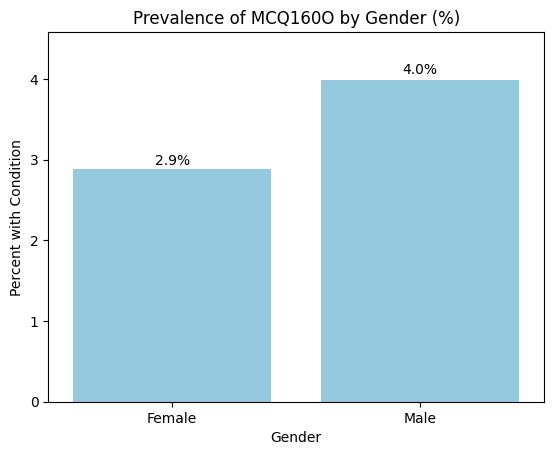

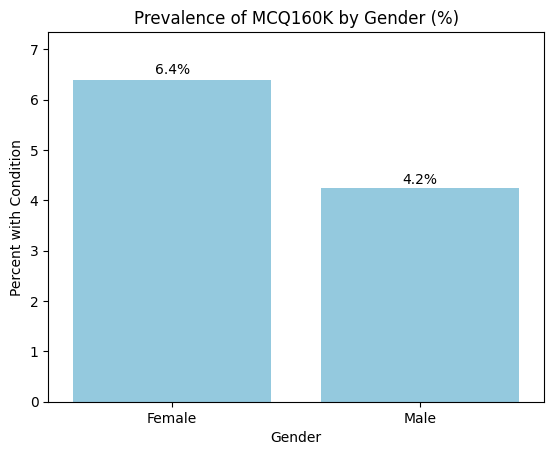

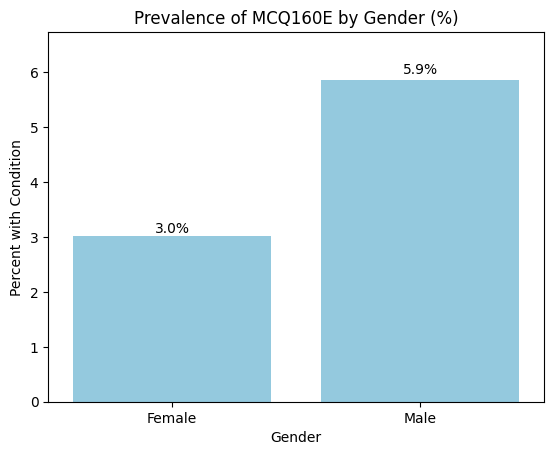

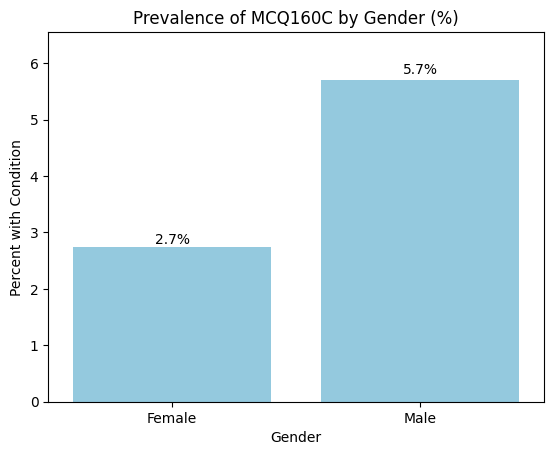

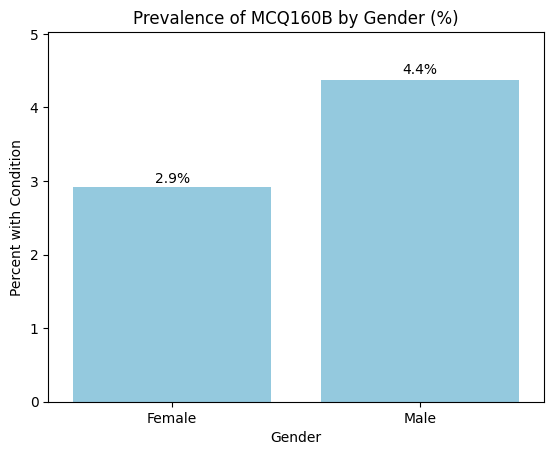

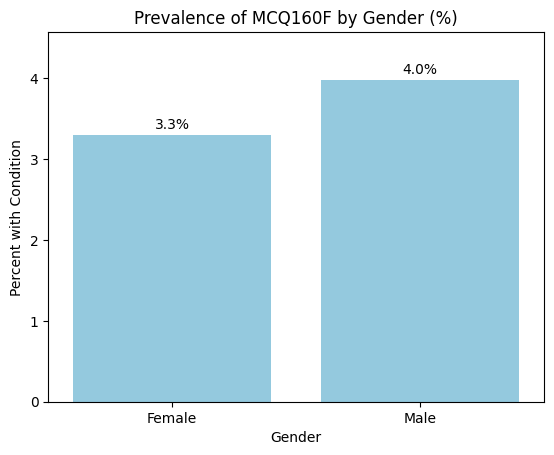

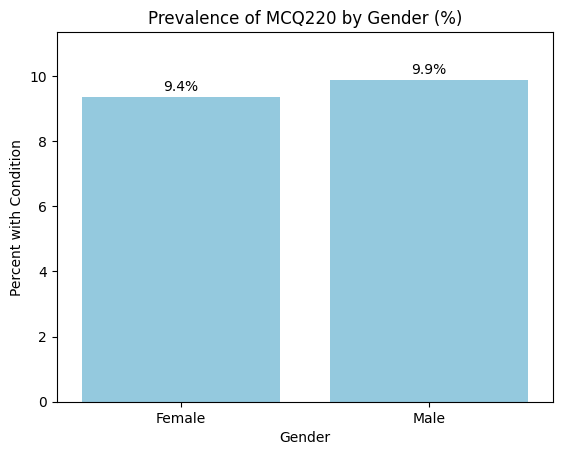

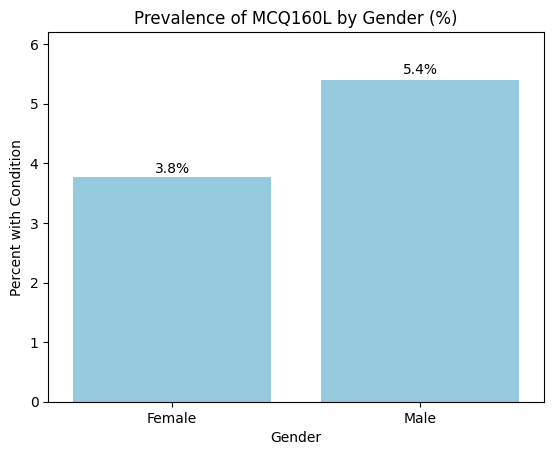

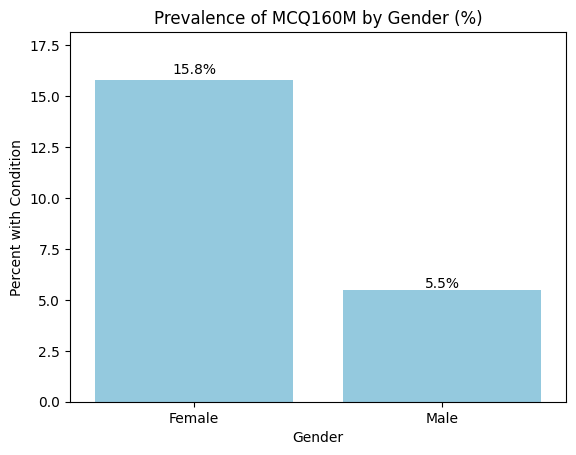

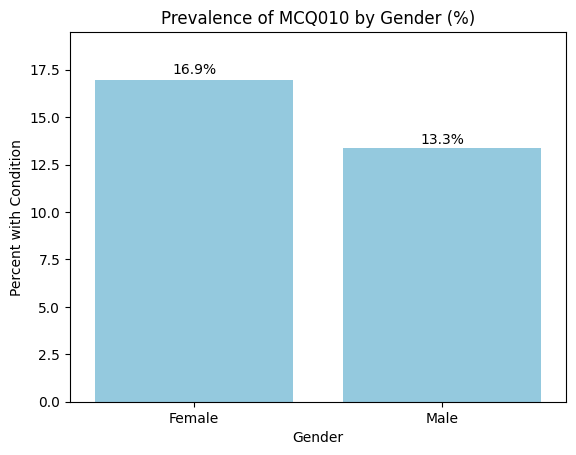

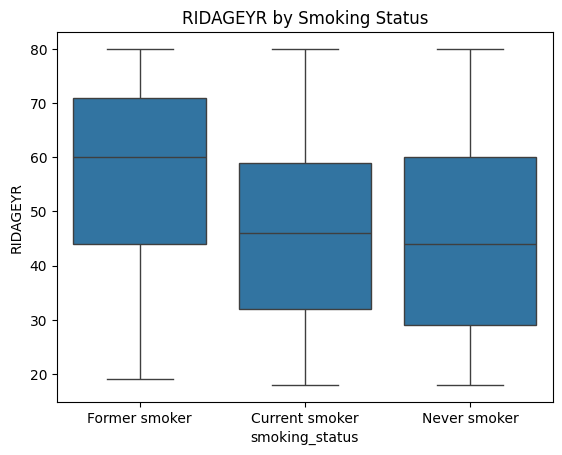

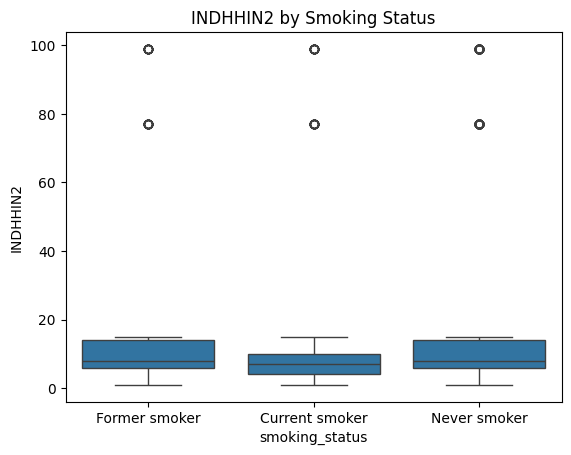

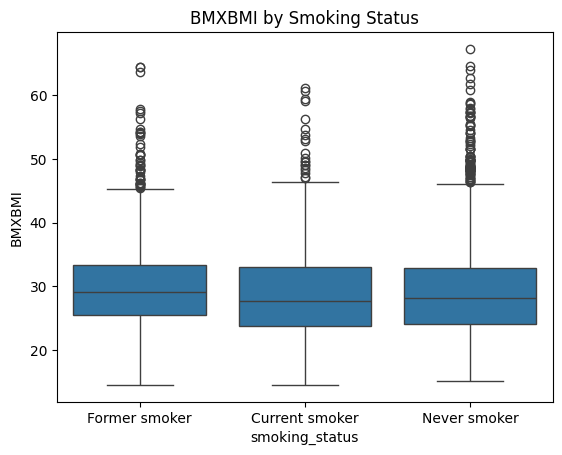

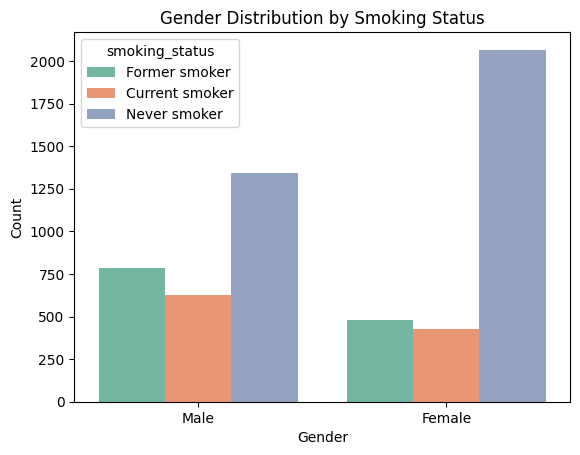

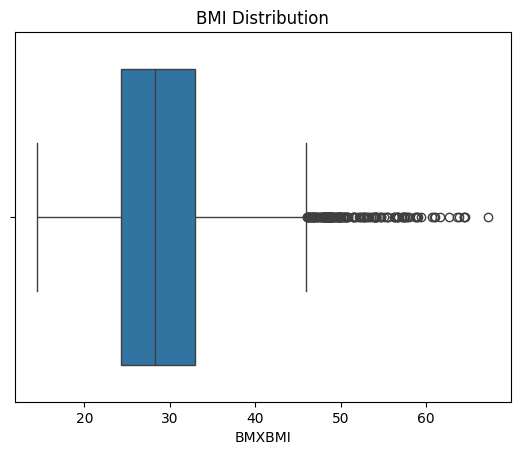

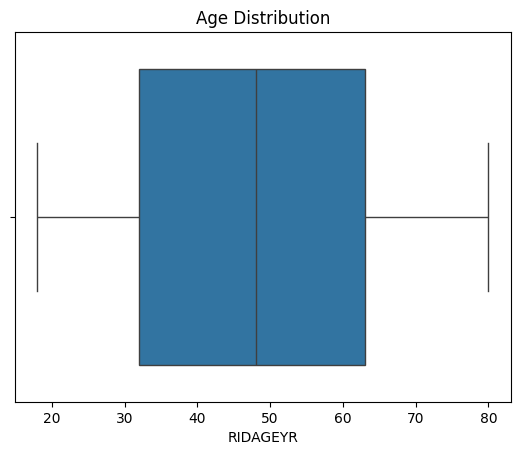

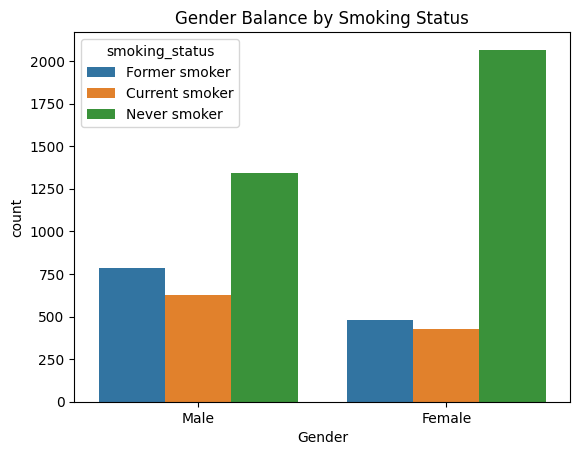

In [ ]:
demo = pd.read_sas('DEMO_I.xpt')
bmx = pd.read_sas('BMX_I.xpt')
mcq = pd.read_sas('MCQ_I.xpt')
smq = pd.read_sas('SMQ_I.xpt')


eda_nhanesData(demo, bmx, mcq, smq)

Takeaways:
1. 5,725 observations / individuals are included in the dataset.
2. The MCQ500 variable is not in the dataset
3. SMQ040 has about 59% of its values missing. Other variables have quite low missingness (between 0%-5%). The final dataset ensures no missing values for the smoking_status field.                                            
4. The mean age is 48.0 years; the median age is 48 years.
5. Former smokers have the highest median age. Current smokers have the next highest median age, followed by never smokers. However, the median age between current and never smokers are very similar.
6. 52% of respondents are female; 48% are male.
7. Race / ethnicity distribution: 32% Non-Hispanic White, 21% Non-Hispanic Black, 16% Other / Multi-Racial, 13% Other Hispanic.
8. Across all age groups, there are more never smokers than current or former smokers.
9. Age groups 10–49: more current smokers than former smokers. Age groups 50–89: more former smokers than current smokers.
10. BMI is right-skewed across all smoking statuses. Median BMI: current smokers 27.65, former smokers 29.10, and never smokers 28.10.
11. Gender patterns in smoking:
*   Higher proportion of females have never smoked compared to males.
*   Lower proportion of females are former smokers compared to males.
*   Lower proportion of females are current smokers compared to males.
12. Race / ethnicity patterns in smoking:

*   More never smokers than current or former smokers in all groups.
*   Mexican American, Non-Hispanic White, and Other Hispanic: more former smokers than current smokers. Other / Multi-Racial have slightly more current smokers than former smokers. Non-Hispanic Black: more current smokers than former smokers.

13. Annual income is right-skewed across all smoking statuses. Median income: highest are for never smokers and  former smokers (both 8) followed by current smokers (7).
14. Disease prevalence by smoking status:
*   MCQ160O and MCQ160K: higher prevalence in current smokers than former or never smokers.
*   MCQ160E, MCQ160C, MCQ160B, MCQ220, MCQ160M: higher prevalence in former smokers than current or never smokers.
*   MCQ160F and MCQ010: similar prevalence between former and current smokers (though the gap is slightly larger for MCQ160F).

# 2013-2014

Number of observations in dataset:  5922

Percent of missing values in each variable
SMQ040            0.579534
MCQ160K           0.056738
MCQ160O           0.056738
MCQ160E           0.056738
MCQ160M           0.056738
MCQ160L           0.056738
MCQ220            0.056738
MCQ160C           0.056738
MCQ160F           0.056738
MCQ160B           0.056738
INDHHIN2          0.013340
BMXBMI            0.012834
RIDRETH1          0.000000
RIAGENDR          0.000000
RIDAGEYR          0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
          RIDAGEYR     RIAGENDR     RIDRETH1     INDHHIN2       BMXBMI  \
count  5922.000000  5922.000000  5922.000000  5843.000000  5846.000000   
mean     47.399358     1.523472     3.127153    11.080952    28.919107   
std      18.422863     0.499491     1.190889    13.988078     7.187559   
min      18.000000     1.000000     1.

/tmp/ipython-input-522425905.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
/tmp/ipython-input-522425905.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


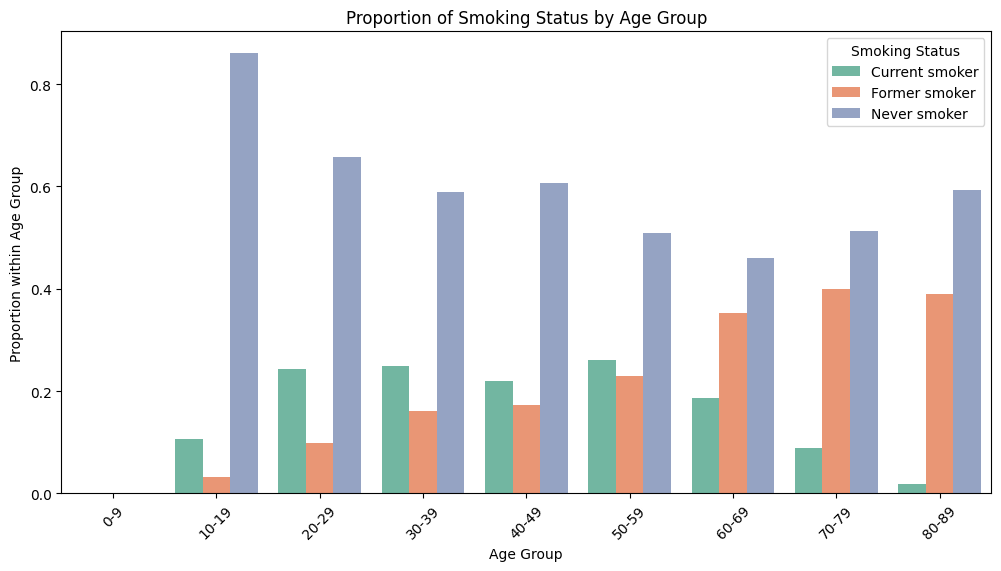

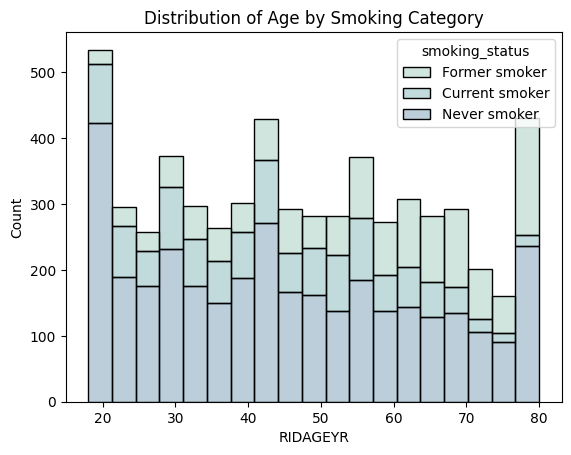

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     28.20        27.2
Former smoker      29.81        28.5
Never smoker       28.83        27.6



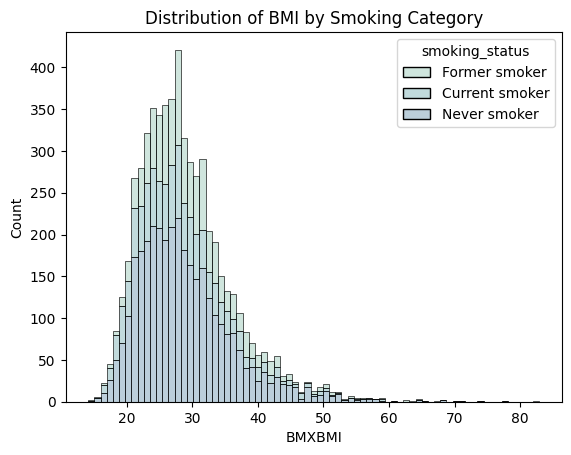

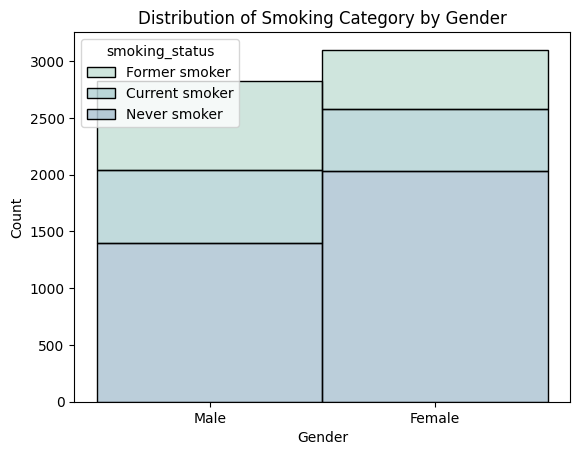

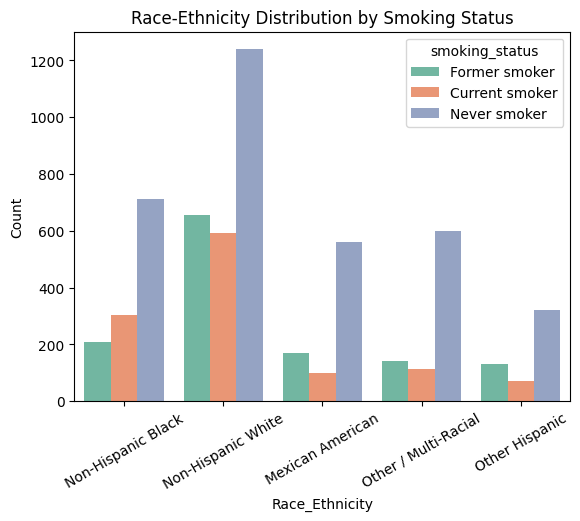

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker                8.83                   6.0
Former smoker                10.91                   8.0
Never smoker                 11.92                   9.0



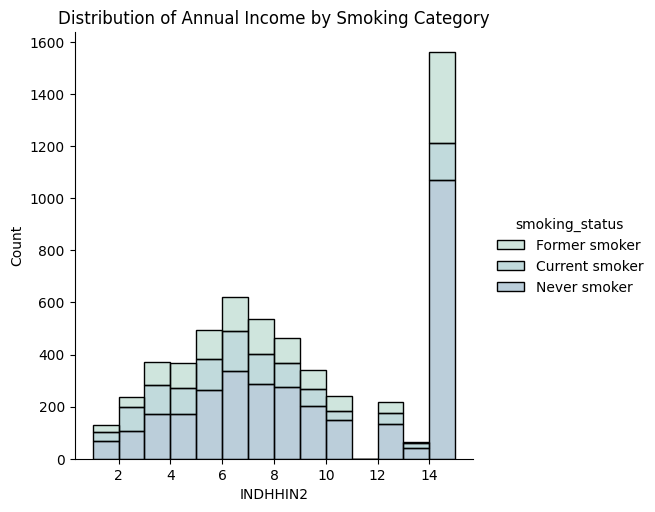

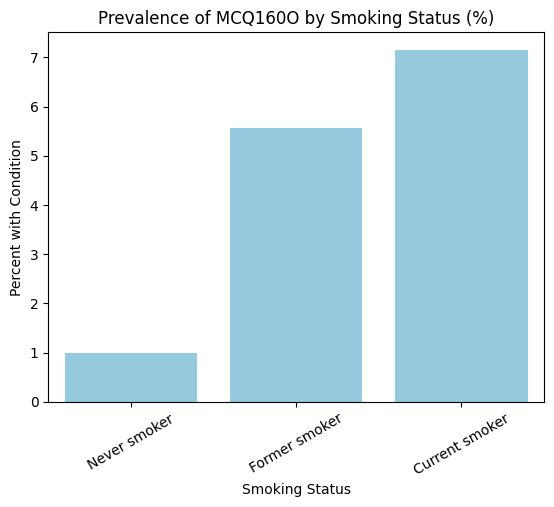

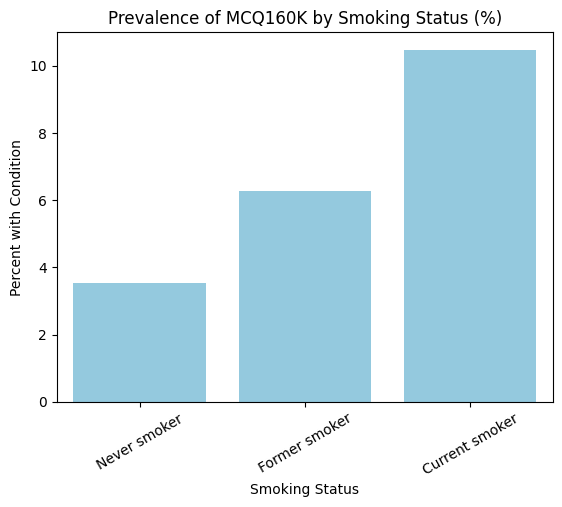

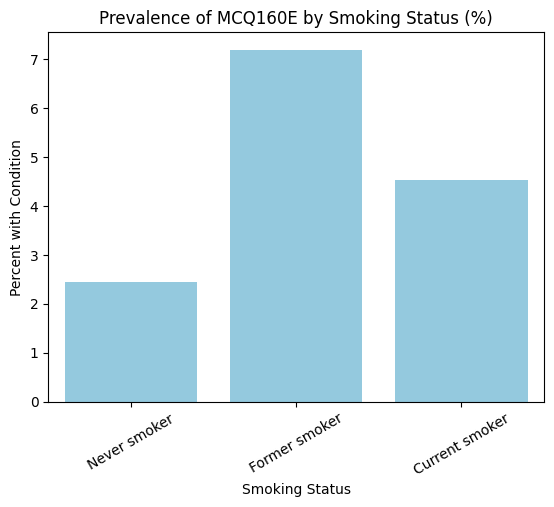

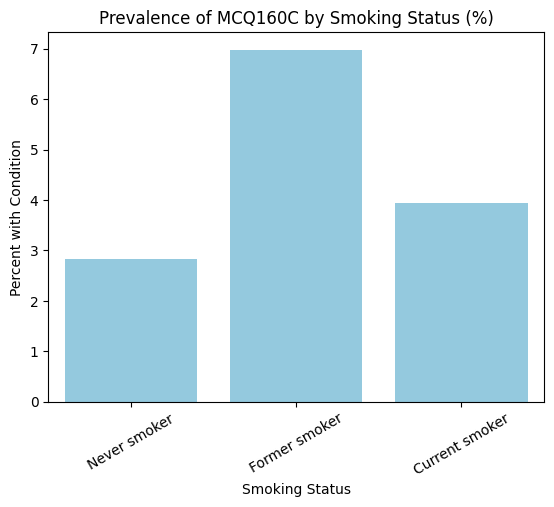

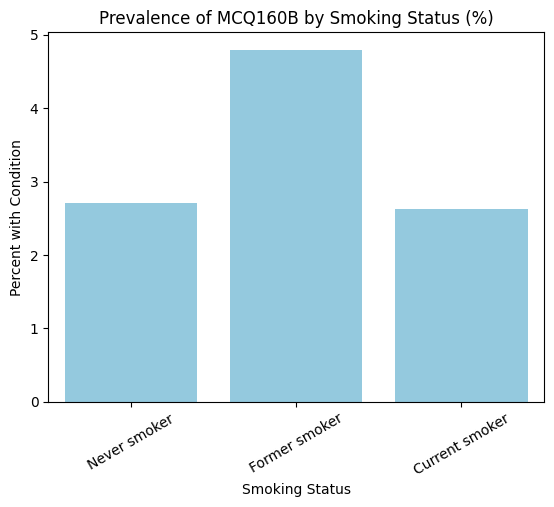

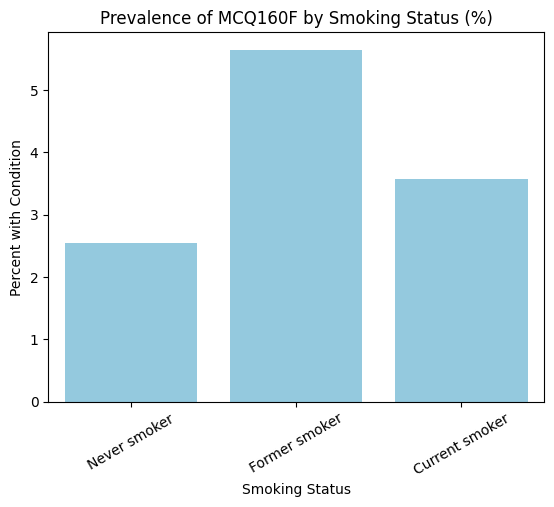

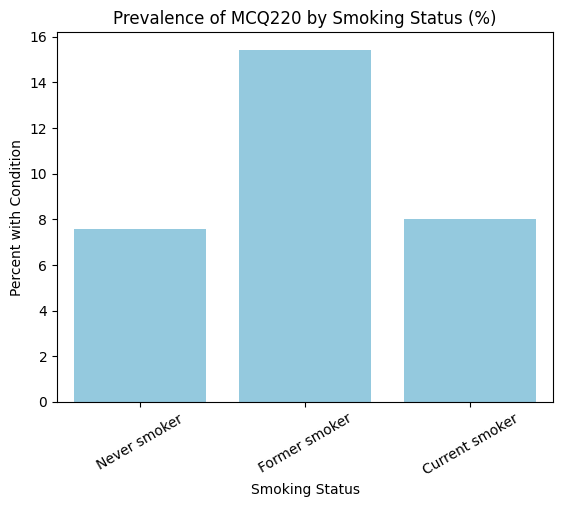

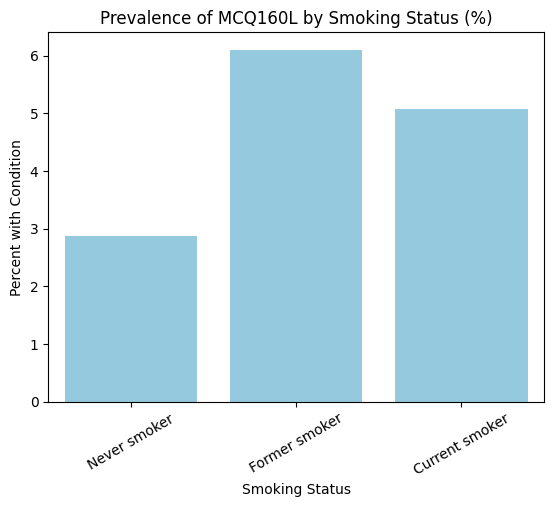

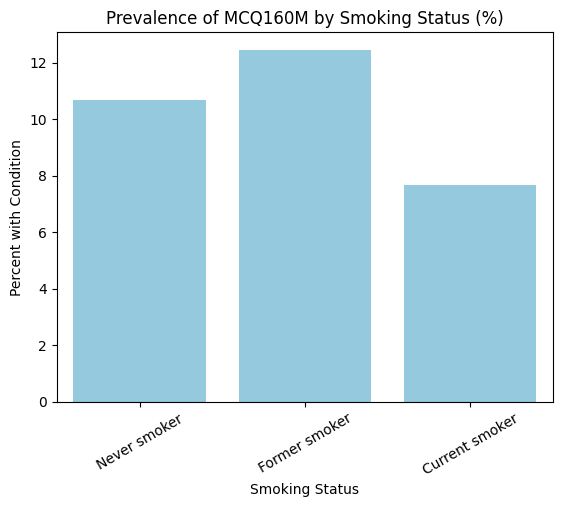

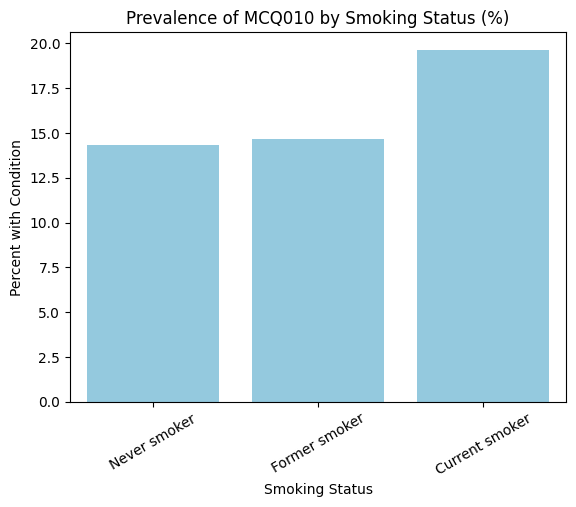

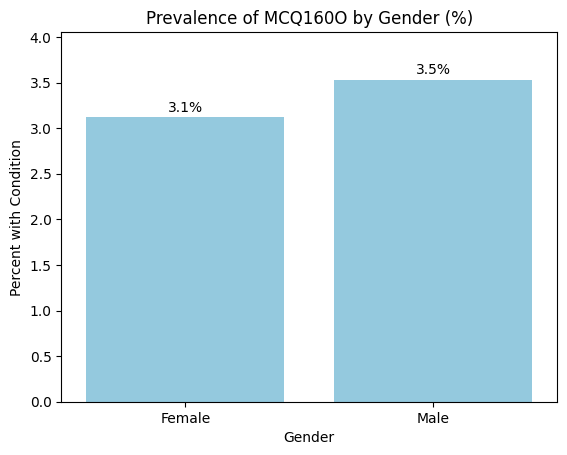

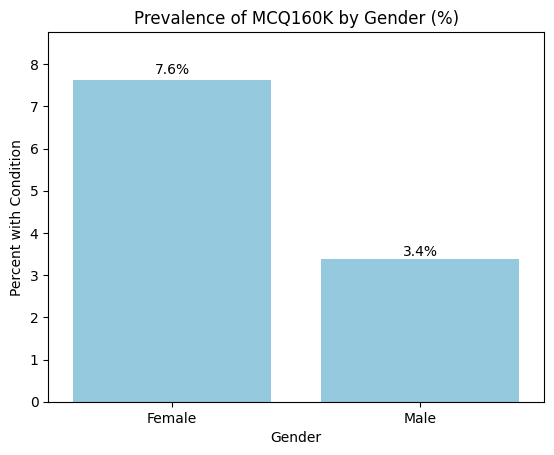

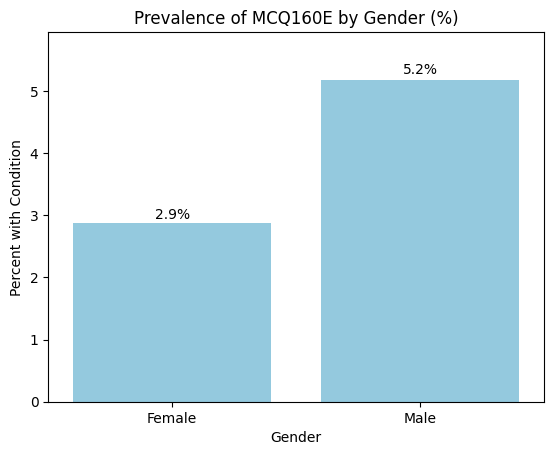

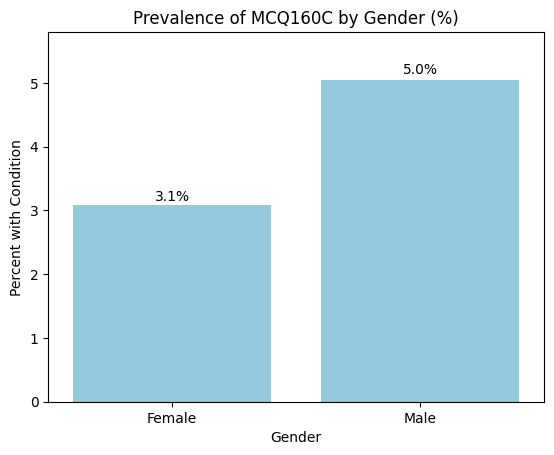

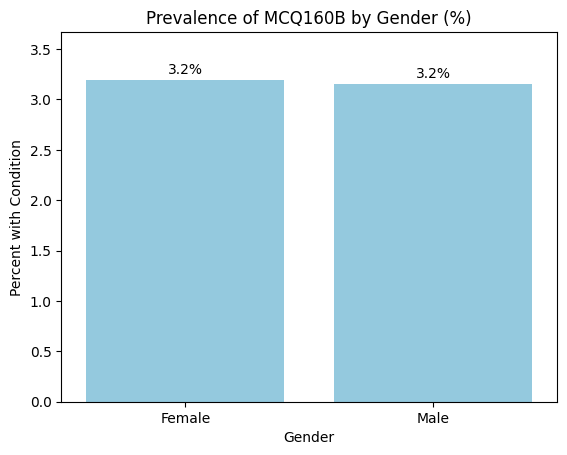

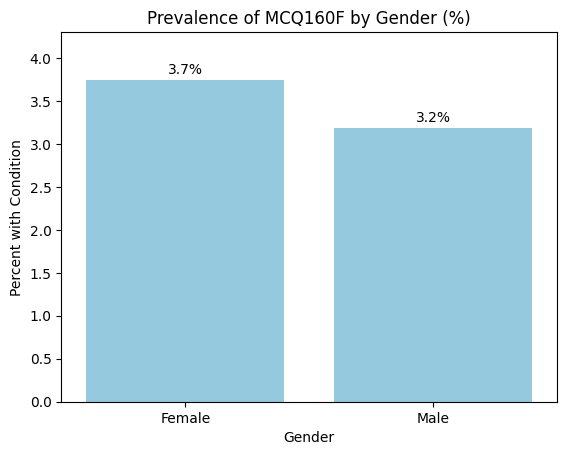

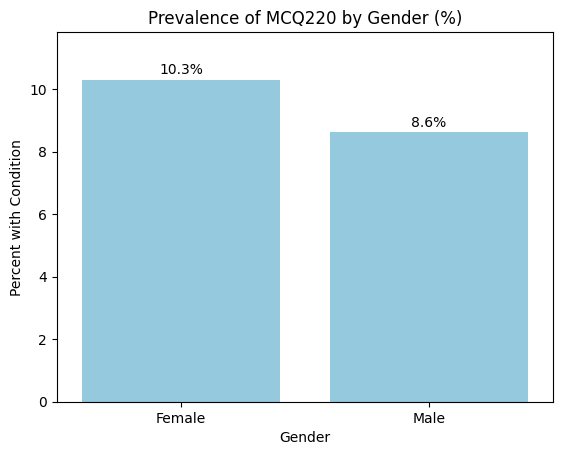

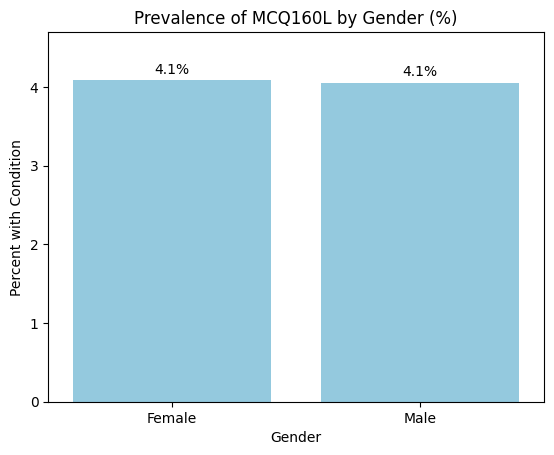

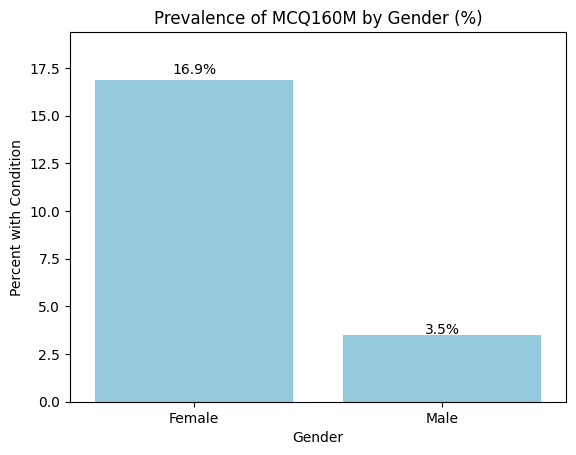

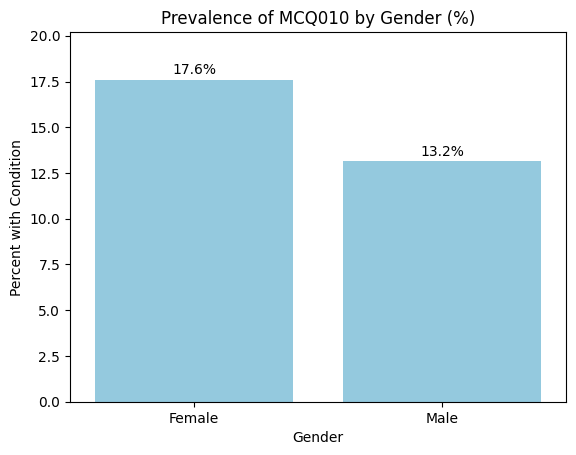

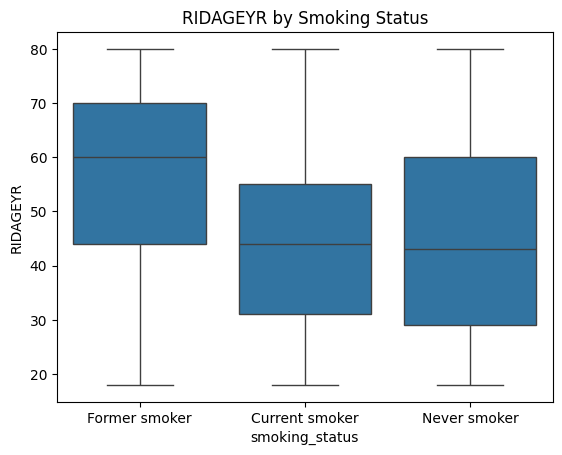

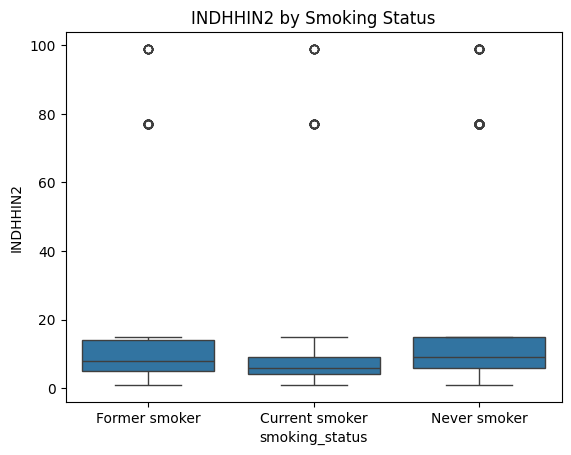

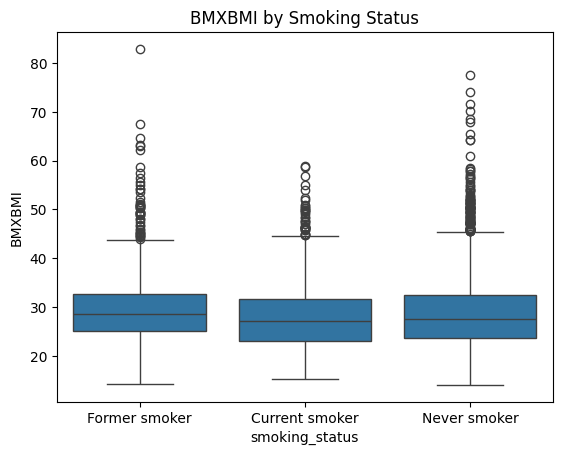

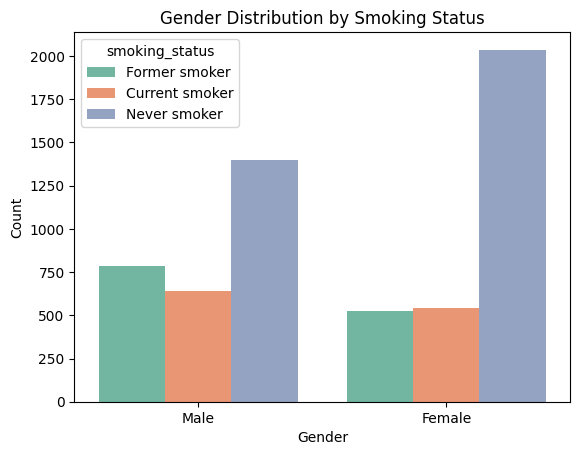

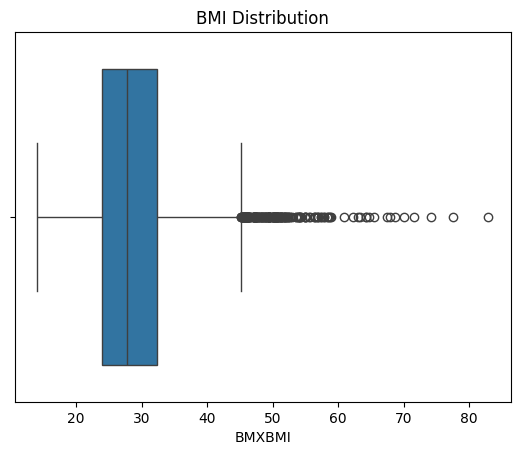

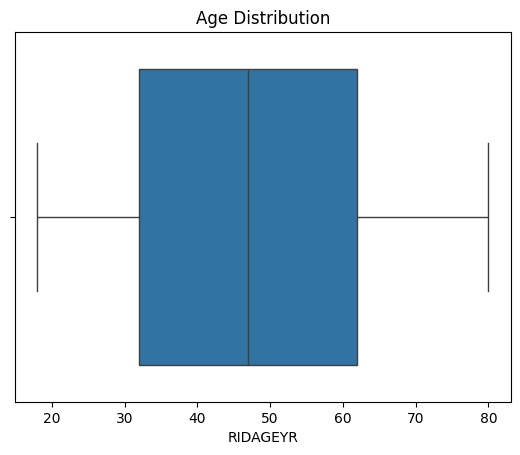

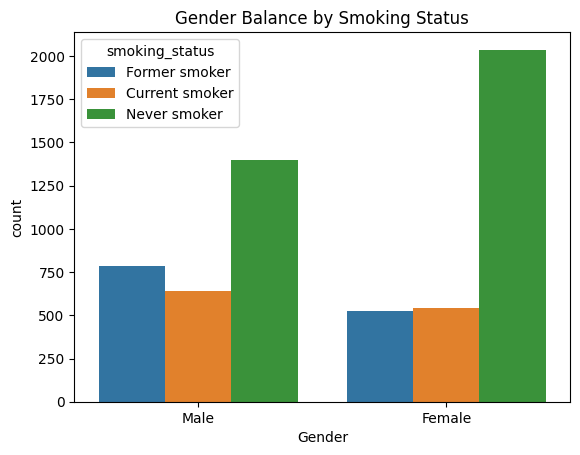

In [ ]:
demo = pd.read_sas('DEMO_H.xpt')
bmx = pd.read_sas('BMX_H.xpt')
mcq = pd.read_sas('MCQ_H.xpt')
smq = pd.read_sas('SMQ_H.xpt')

eda_nhanesData(demo, bmx, mcq, smq)

Takeaways:
1. 5,922 observations / individuals are included in the dataset.
2. The MCQ500 variable is not in the dataset
3. SMQ040 has about 58% of its values missing. Other variables have quite low missingness (between 0%-6%). The final dataset ensures no missing values for the smoking_status field.                        
4. The mean age is 47.3 years; the median age is 47.0 years.
5. Former smokers have the highest median age. Never smokers and current smokers have similar median ages. (Double check)
6. 52% of respondents are female; 48% are male.
7. Race / ethnicity distribution: 42% Non-Hispanic White, 21% Non-Hispanic Black, 14% Other / Multi-Racial, 9% Other Hispanic.
8. Across all age groups, there are more never smokers than current or former smokers.
9. Age groups 10–59: more current smokers than former smokers. Age groups 60–89: more former smokers than current smokers.
10. BMI is right-skewed across all smoking statuses. Median BMI: current smokers 27.2, former smokers 28.5, and never smokers 27.6.
11. Gender patterns in smoking:
*   Higher proportion of females have never smoked compared to males.
*   Lower proportion of females are former smokers compared to males.
*   Lower proportion of females are current smokers compared to males.
12. Race / ethnicity patterns in smoking:

*   More never smokers than current or former smokers in all groups.
*   Mexican American, Other/Multi-Racial, Non-Hispanic White, and Other Hispanic: more former smokers than current smokers.
*   Non-Hispanic Black: more current smokers than former smokers.

13. Annual income is right-skewed across all smoking statuses. Median income: highest are for never smokers (9), followed by former smokers (8) and lastly current smokers (6).
14. Disease prevalence by smoking status:
*   MCQ160O and MCQ160K: higher prevalence in current smokers than former or never smokers.
*   MCQ160E, MCQ160C, MCQ160B, MCQ220, MCQ160M, MCQ160F: higher prevalence in former smokers than current or never smokers.
*   MCQ010: higher prevalence in current smokers compared to former and never smokers.

# 2011-2012

COPD variable not found — creating proxy from emphysema and chronic bronchitis.
Number of observations in dataset:  5312

Percent of missing values in each variable
SMQ040            0.571724
BMXBMI            0.015437
INDHHIN2          0.008283
RIDAGEYR          0.000000
RIDRETH1          0.000000
RIAGENDR          0.000000
MCQ160K           0.000000
MCQ160O           0.000000
MCQ160C           0.000000
MCQ160B           0.000000
MCQ160F           0.000000
MCQ160E           0.000000
MCQ220            0.000000
MCQ160L           0.000000
MCQ160M           0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
          RIDAGEYR    RIAGENDR     RIDRETH1     INDHHIN2       BMXBMI  \
count  5312.000000  5312.00000  5312.000000  5268.000000  5230.000000   
mean     48.767319     1.50753     3.305535    11.468679    28.777170   
std      17.764333     0.49999     

/tmp/ipython-input-522425905.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
/tmp/ipython-input-522425905.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


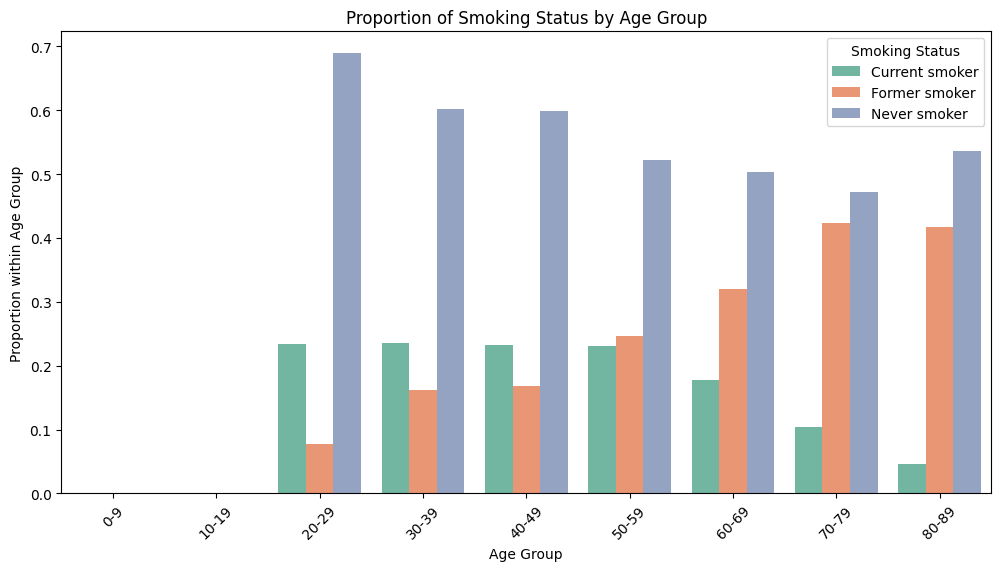

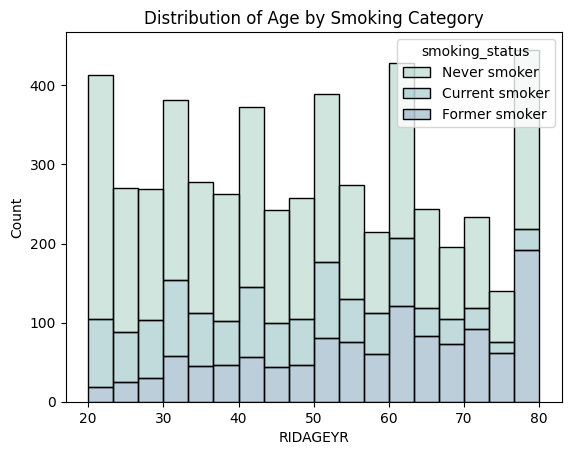

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     28.00        27.0
Former smoker      29.39        28.3
Never smoker       28.80        27.5



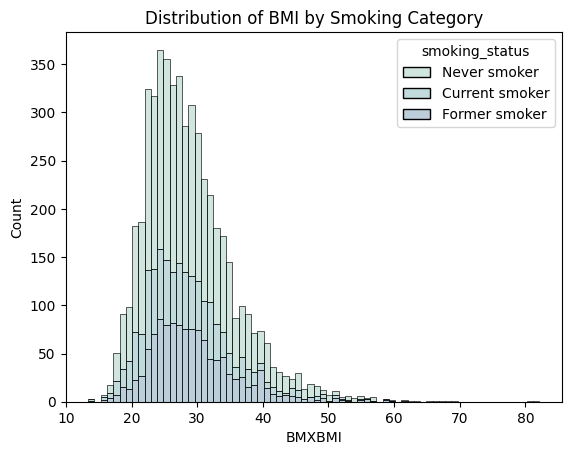

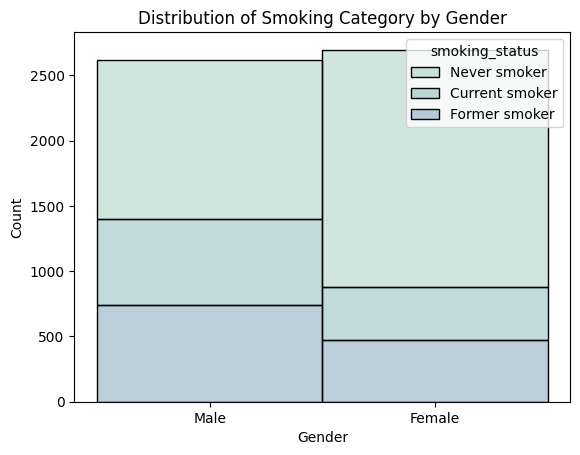

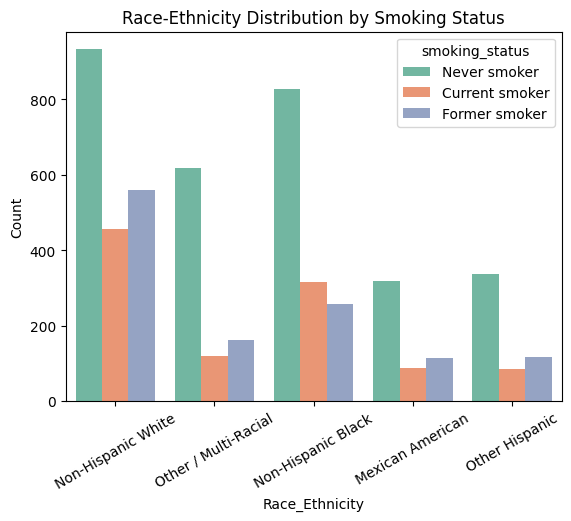

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker               10.08                   6.0
Former smoker                11.39                   8.0
Never smoker                 11.99                   8.0



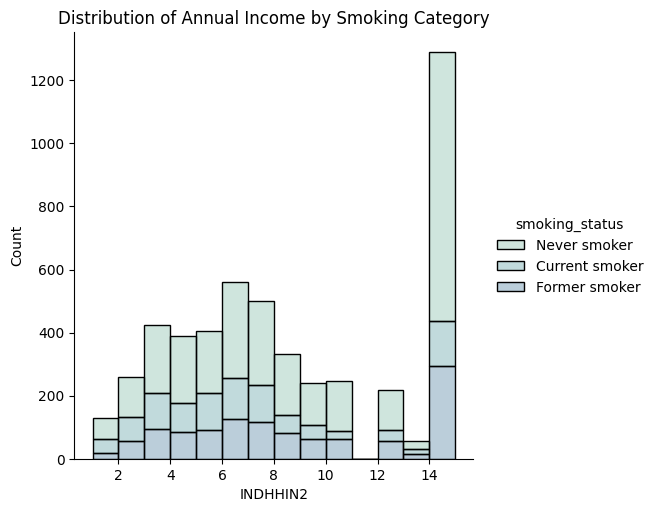

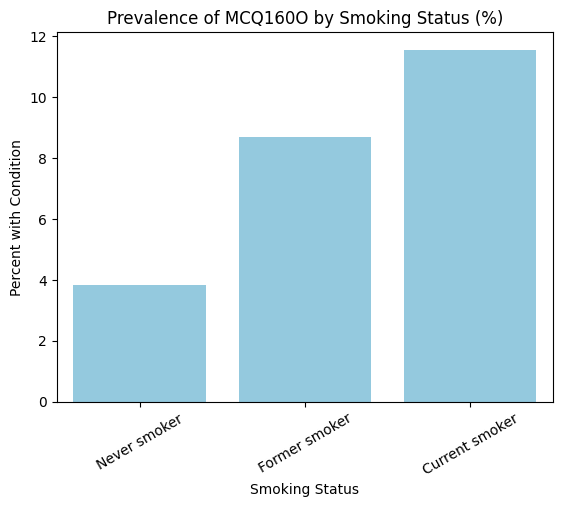

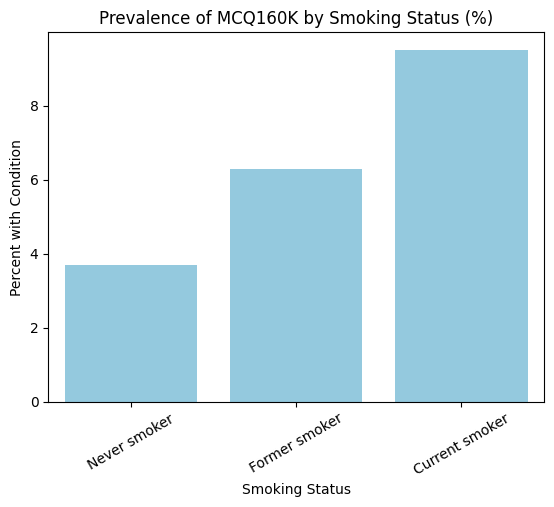

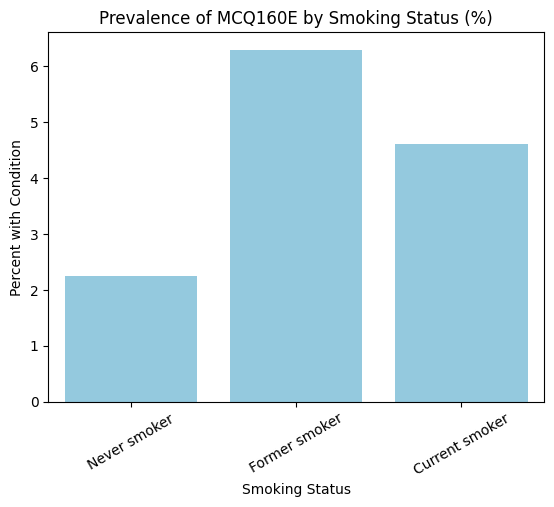

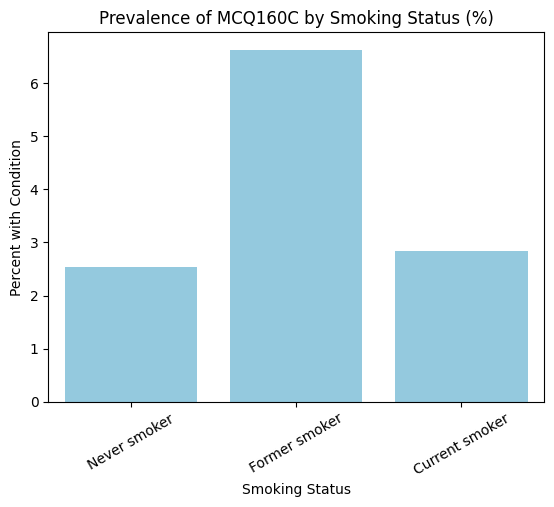

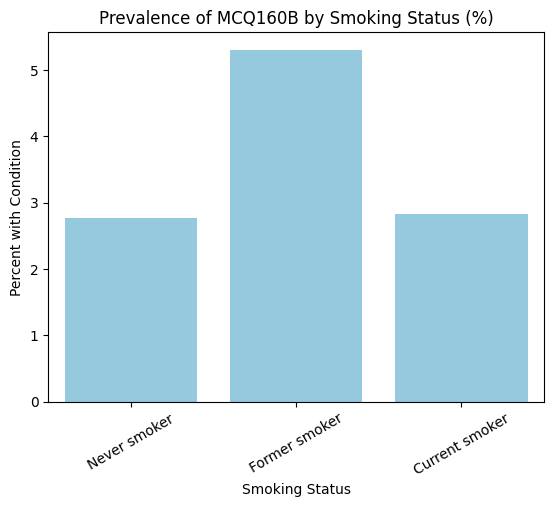

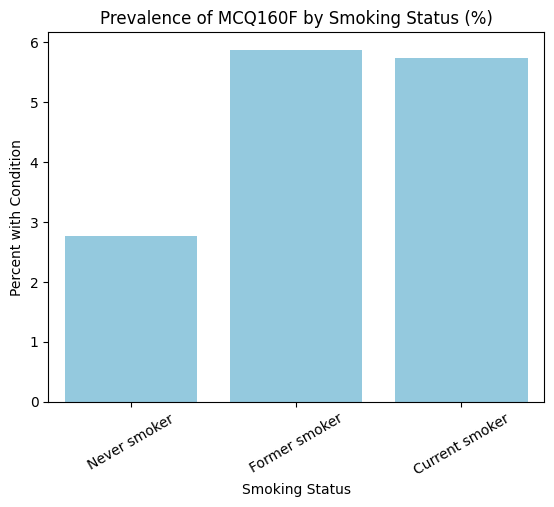

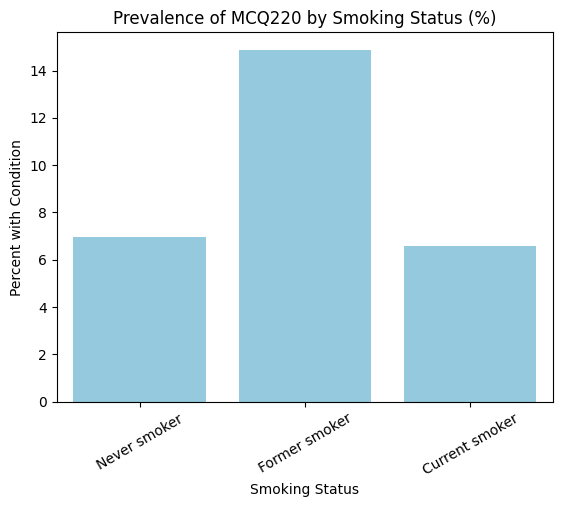

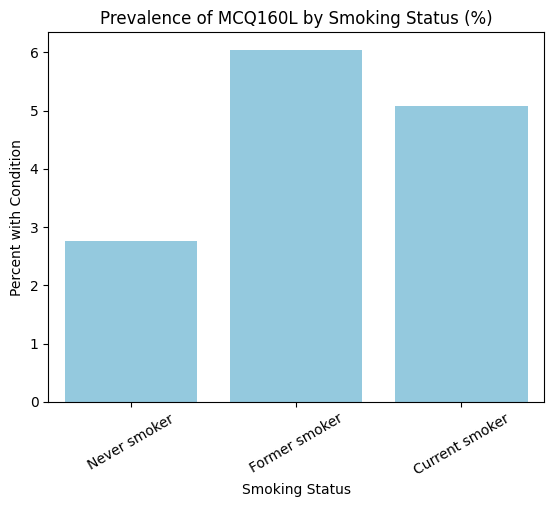

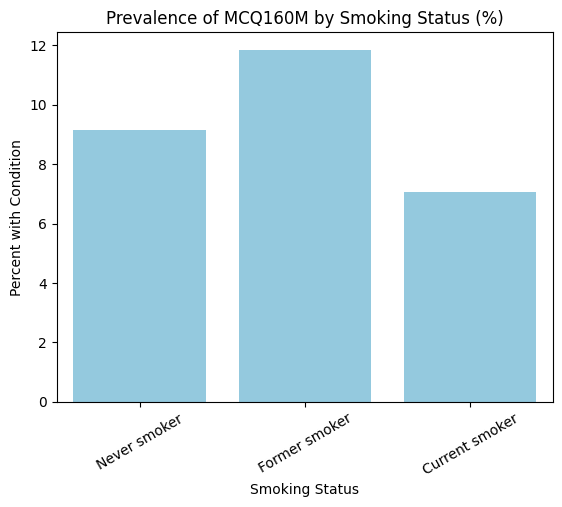

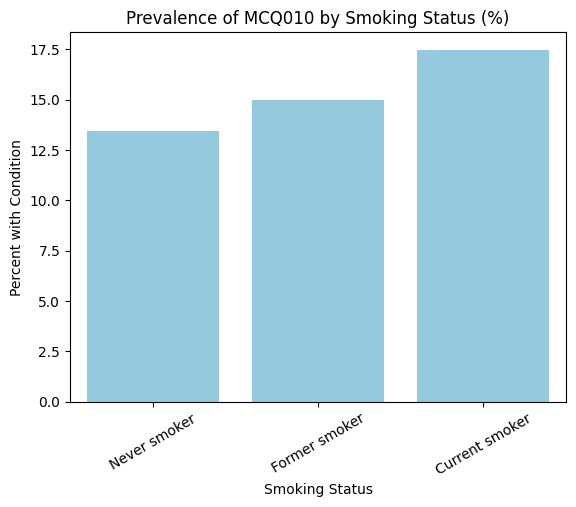

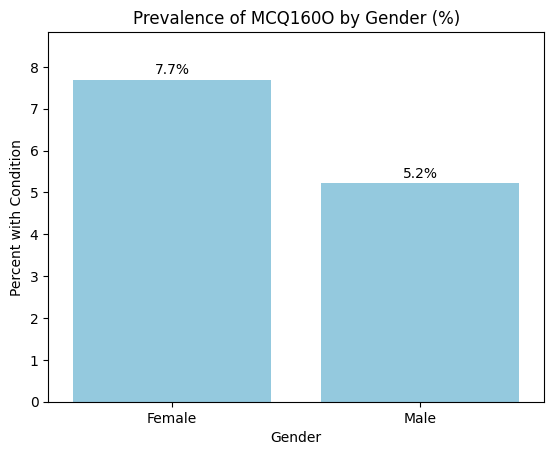

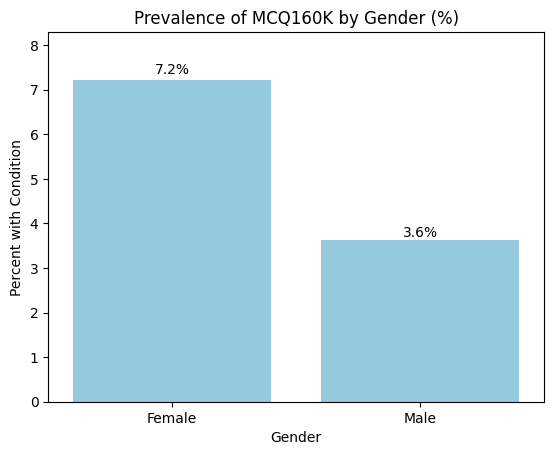

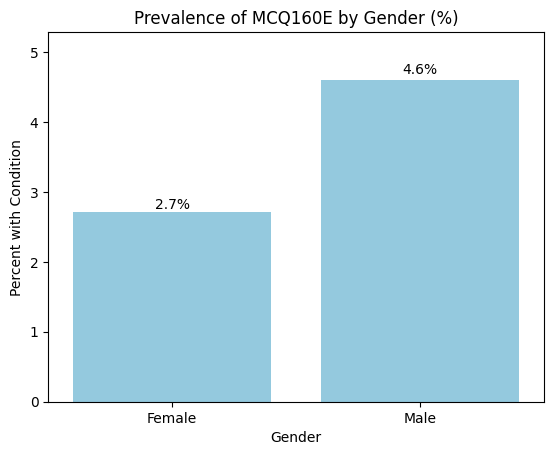

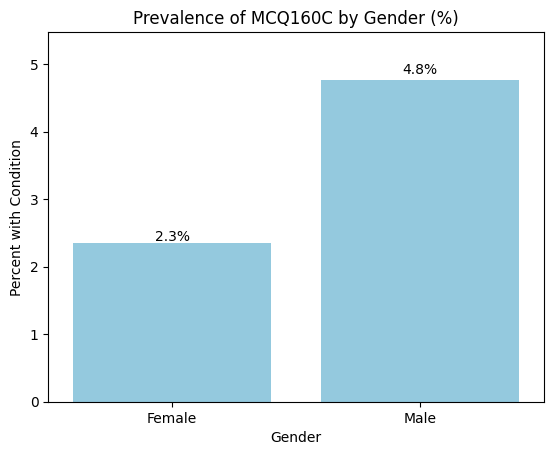

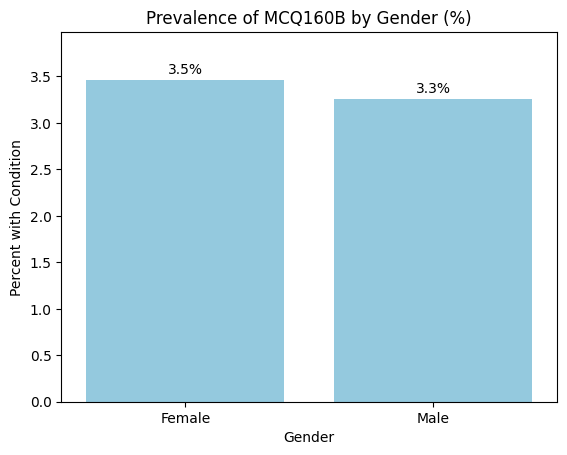

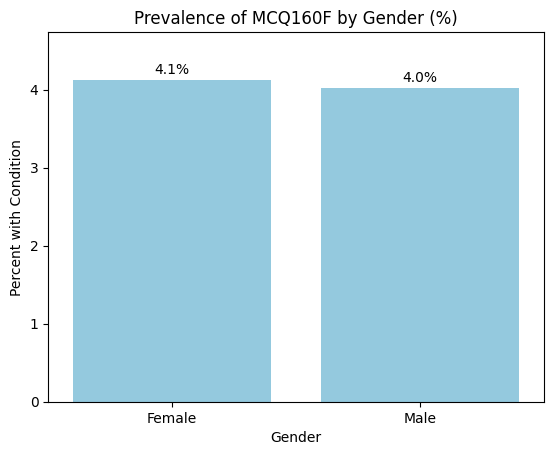

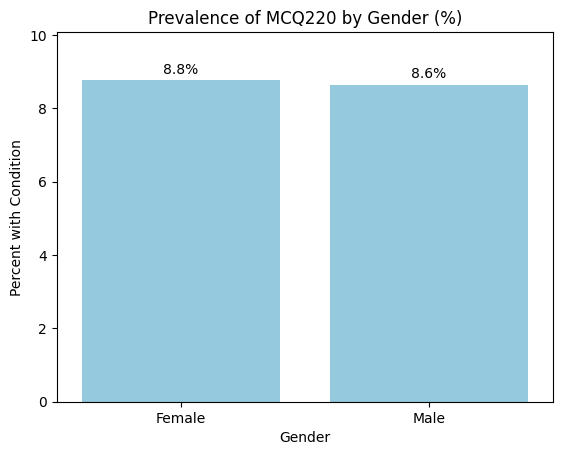

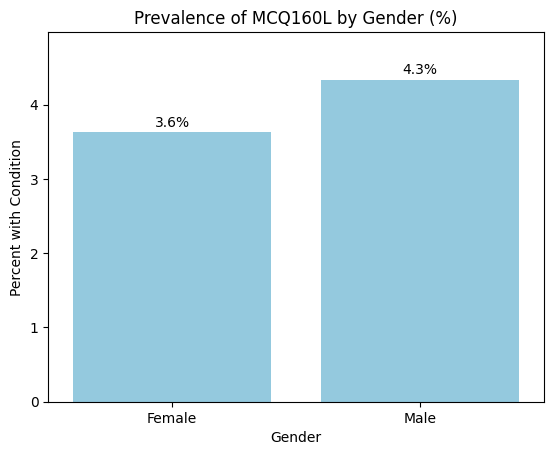

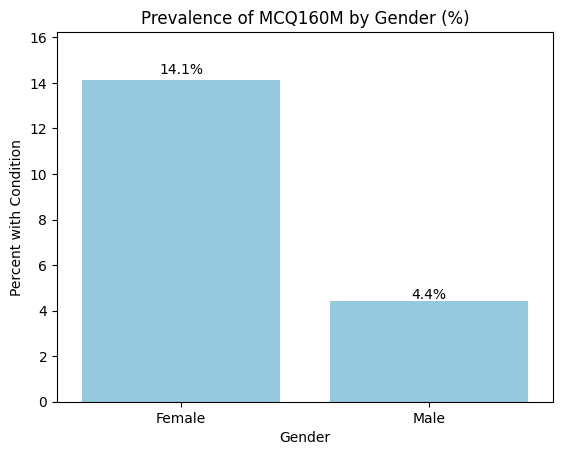

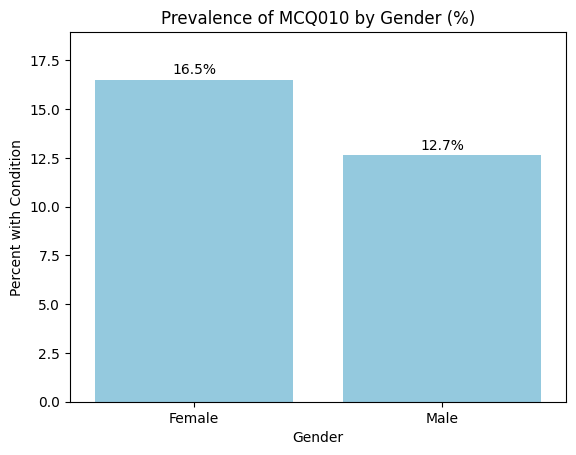

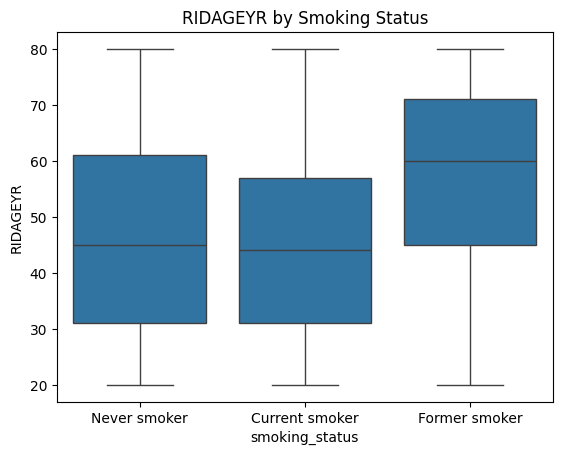

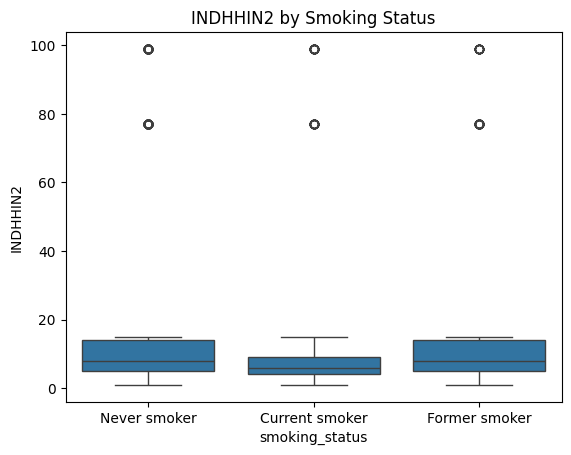

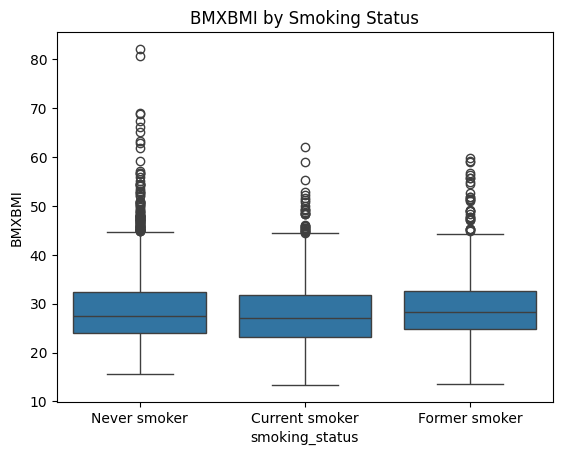

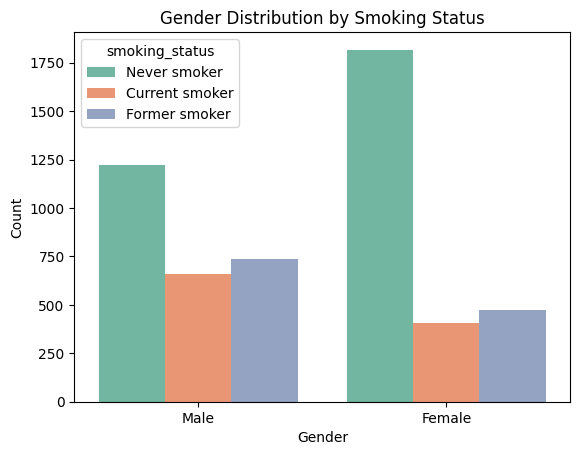

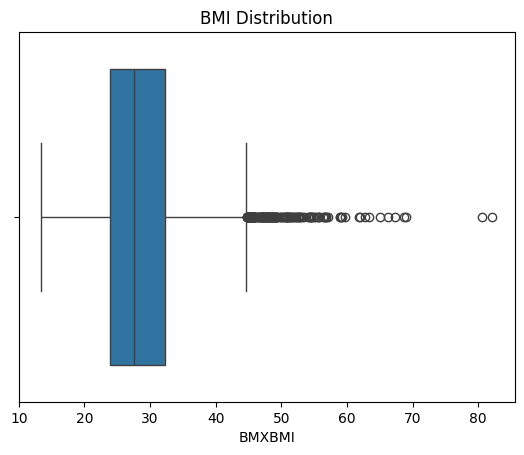

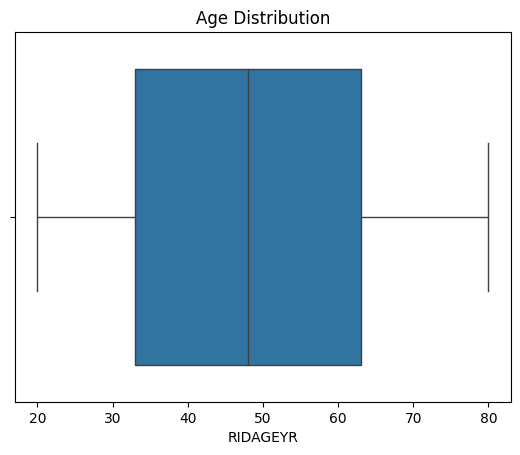

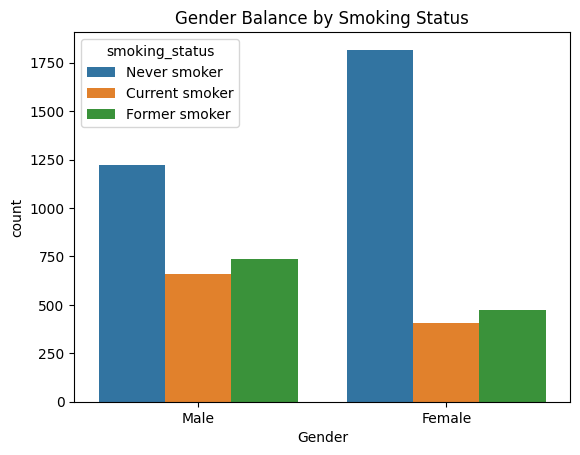

In [ ]:
demo = pd.read_sas('DEMO_G.xpt')
bmx = pd.read_sas('BMX_G.xpt')
mcq = pd.read_sas('MCQ_G.xpt')
smq = pd.read_sas('SMQ_G.xpt')

eda_nhanesData(demo, bmx, mcq, smq)

Takeaways:
1. 5,312 observations / individuals are included in the dataset.
2. The MCQ500 variable is not in the dataset
3. SMQ040 has about 57% of its values missing. Other variables have quite low missingness (between 0%-2%). The final dataset ensures no missing values for the smoking_status field.                        
4. The mean age is about 49 years; the median age is 48 years.
5. Former smokers have the highest median age. Never smokers and current smokers have similar median ages.
6. 51% of respondents are female; 49% are male.
7. Race / ethnicity distribution: 37% Non-Hispanic White, 26% Non-Hispanic Black, 17% Other / Multi-Racial, 10% Other Hispanic.
8. Across all age groups, there are more never smokers than current or former smokers.
9. Age groups (ages 10-19 are not included) 20–49: more current smokers than former smokers. Age groups 50–89: more former smokers than current smokers.
10. BMI is right-skewed across all smoking statuses. Median BMI: current smokers 27.0, former smokers 28.3, and never smokers 27.5.
11. Gender patterns in smoking:
*   Higher proportion of females have never smoked compared to males.
*   Lower proportion of females are former smokers compared to males.
*   Lower proportion of females are current smokers compared to males.
12. Race / ethnicity patterns in smoking:



*   More never smokers than current or former smokers in all groups.
*   Mexican American, Other/Multi-Racial, Non-Hispanic White, and Other Hispanic: more former smokers than current smokers.  Non-Hispanic Black: more current smokers than former smokers.
13. Annual income is right-skewed across all smoking statuses. Median income: highest are for never smokers and  former smokers (8) and lastly current smokers (6).
14. Disease prevalence by smoking status:
*   MCQ160O and MCQ160K: higher prevalence in current smokers than former or never smokers.
*   MCQ160E, MCQ160C, MCQ160B, MCQ220, MCQ160M, MCQ160F: higher prevalence in former smokers than current or never smokers.
*   MCQ010: higher prevalence in current smokers compared to former and never smokers

# 2009-2010

COPD variable not found — creating proxy from emphysema and chronic bronchitis.
Number of observations in dataset:  6059

Percent of missing values in each variable
SMQ040            0.538538
BMXBMI            0.010728
INDHHIN2          0.006272
RIDAGEYR          0.000000
RIDRETH1          0.000000
RIAGENDR          0.000000
MCQ160K           0.000000
MCQ160O           0.000000
MCQ160C           0.000000
MCQ160B           0.000000
MCQ160F           0.000000
MCQ160E           0.000000
MCQ220            0.000000
MCQ160L           0.000000
MCQ160M           0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
          RIDAGEYR     RIAGENDR     RIDRETH1     INDHHIN2       BMXBMI  \
count  6059.000000  6059.000000  6059.000000  6021.000000  5994.000000   
mean     49.489025     1.516587     2.827364    11.792061    29.163300   
std      17.842364     0.499766 

/tmp/ipython-input-522425905.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_smoke_counts = all_exSEQN.groupby(['AgeGroup', 'smoking_status']).size().reset_index(name='count')
/tmp/ipython-input-522425905.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


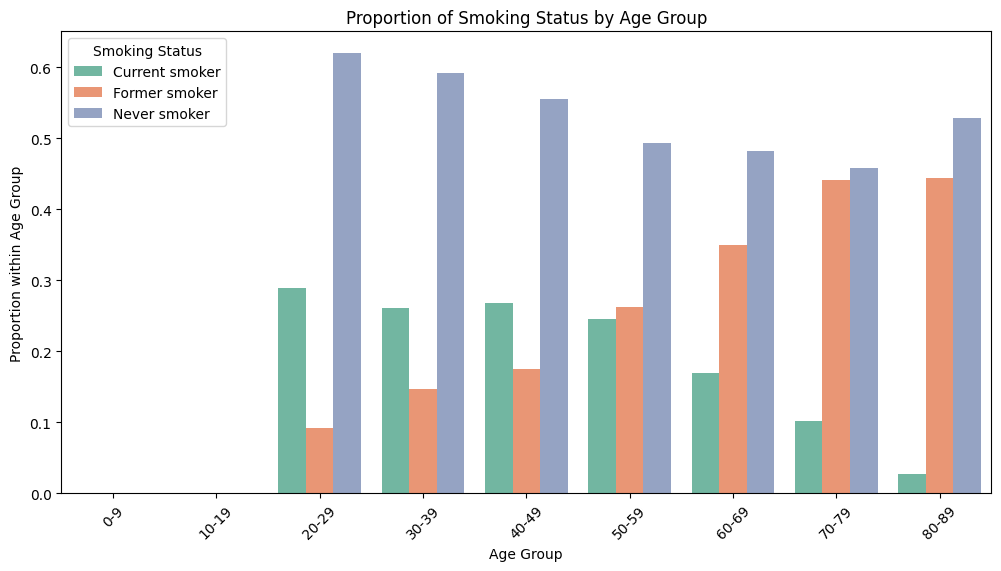

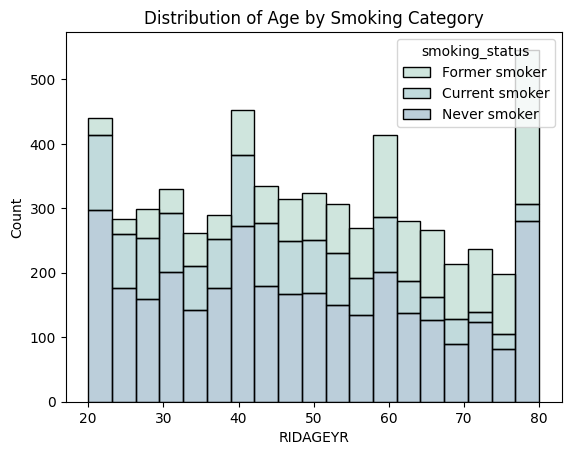

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     28.23       27.15
Former smoker      29.75       28.67
Never smoker       29.28       28.31



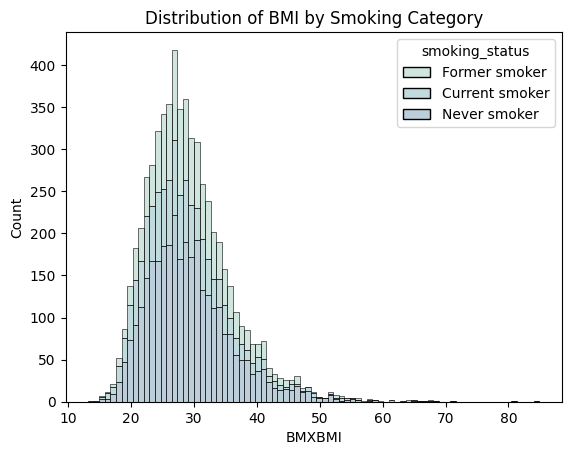

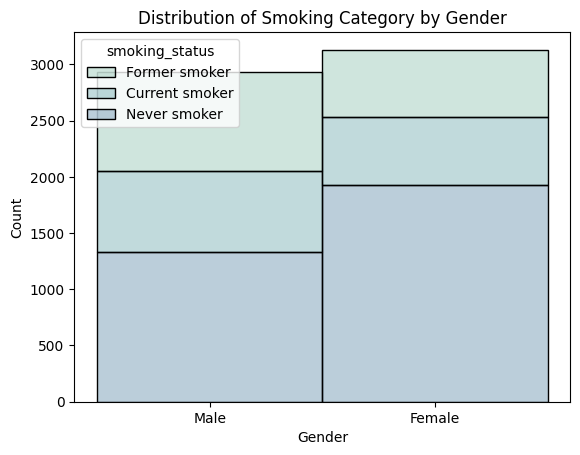

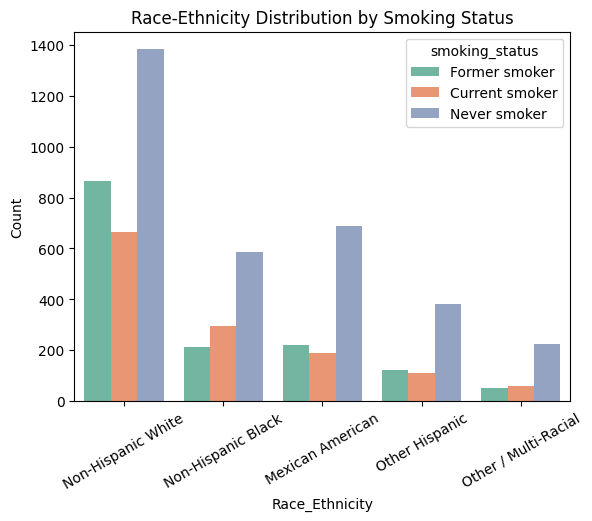

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker               10.51                   6.0
Former smoker                10.99                   7.0
Never smoker                 12.67                   8.0



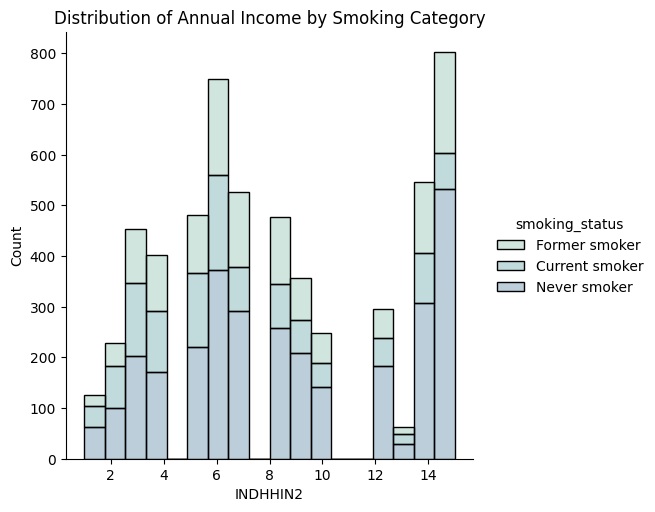

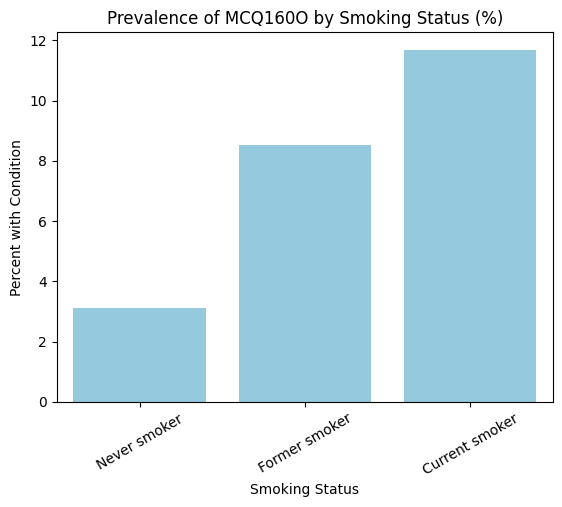

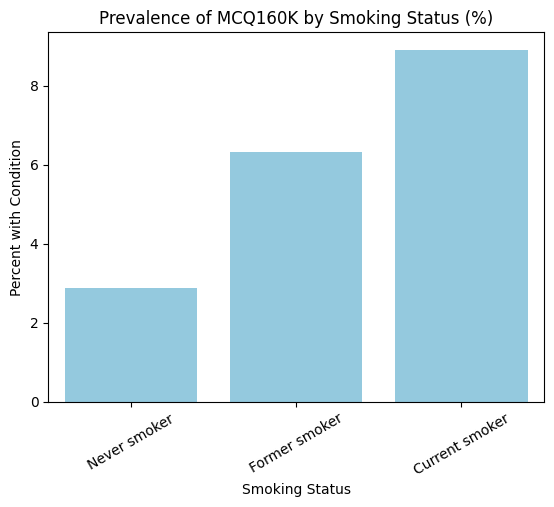

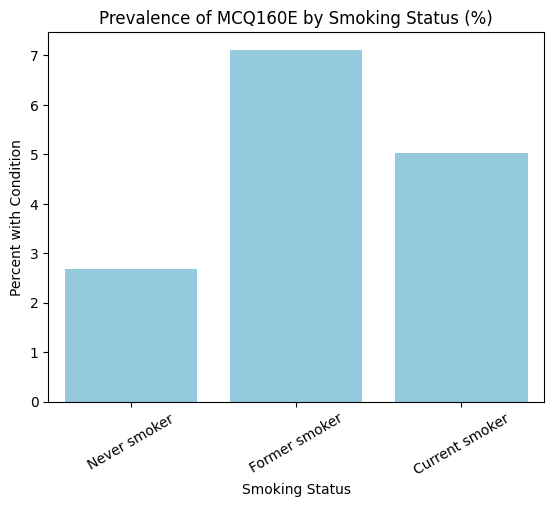

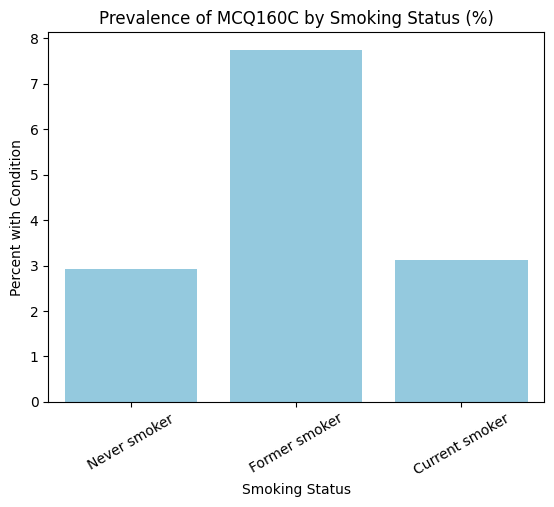

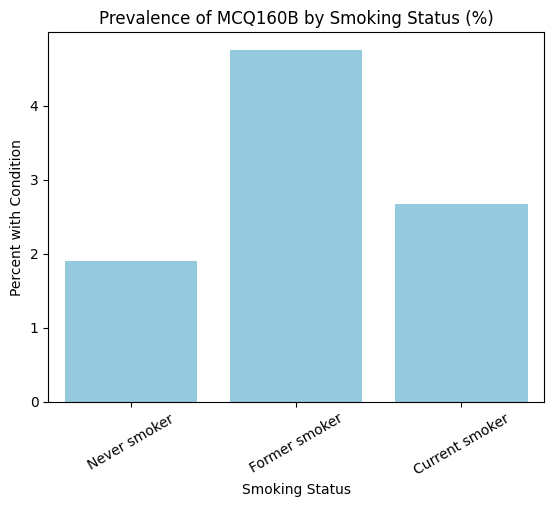

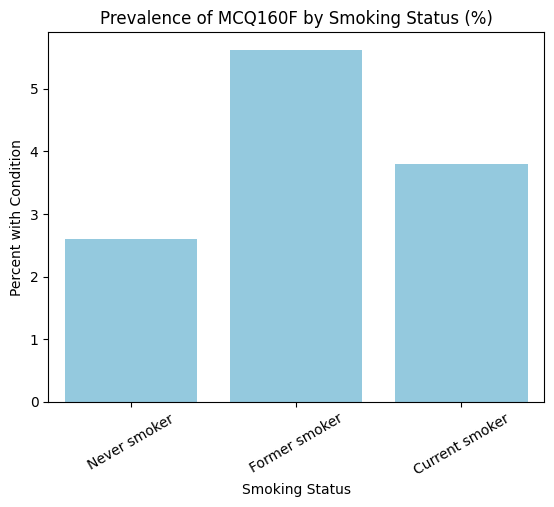

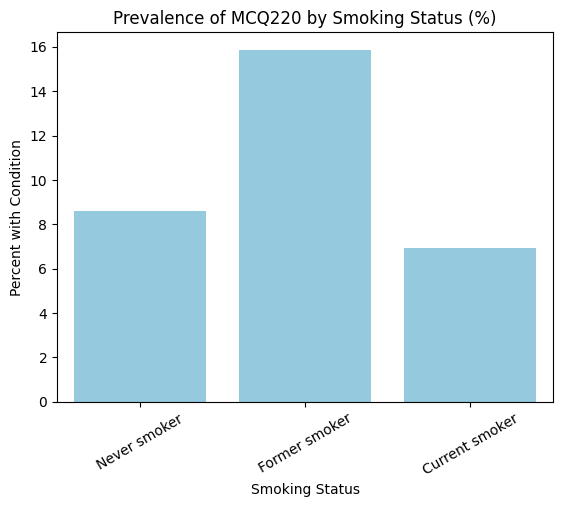

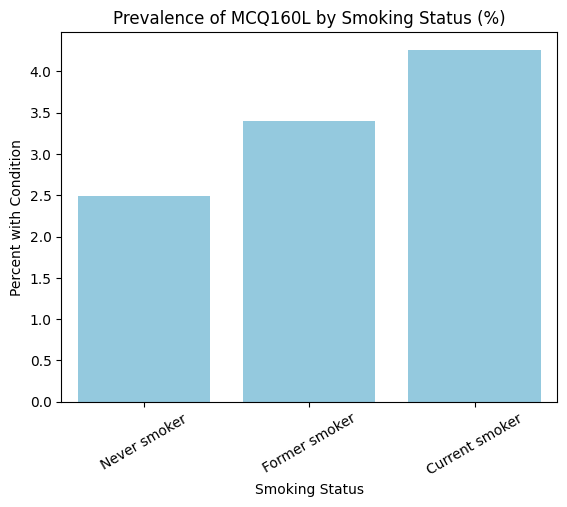

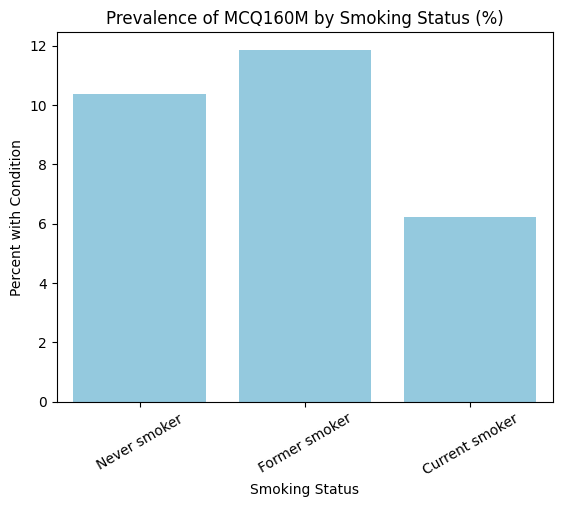

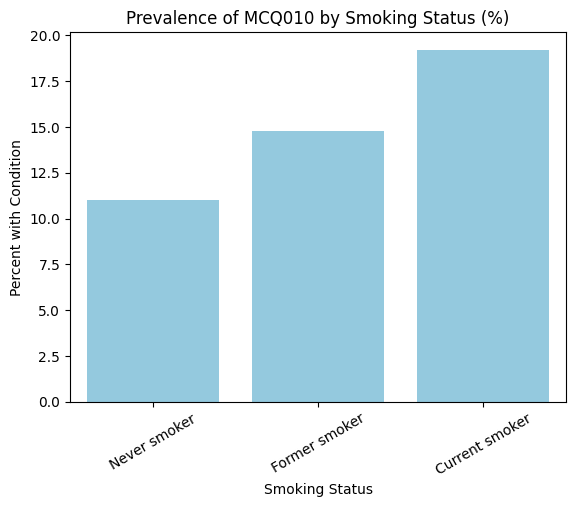

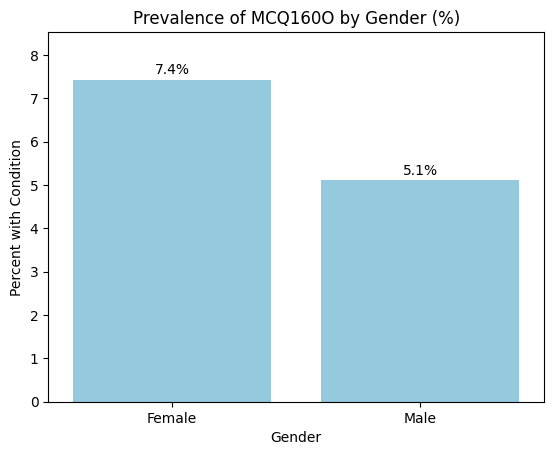

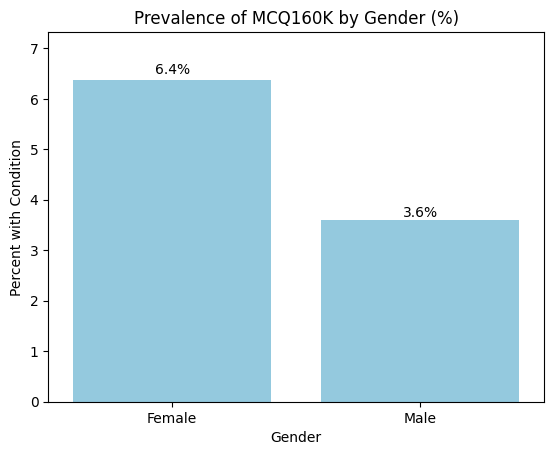

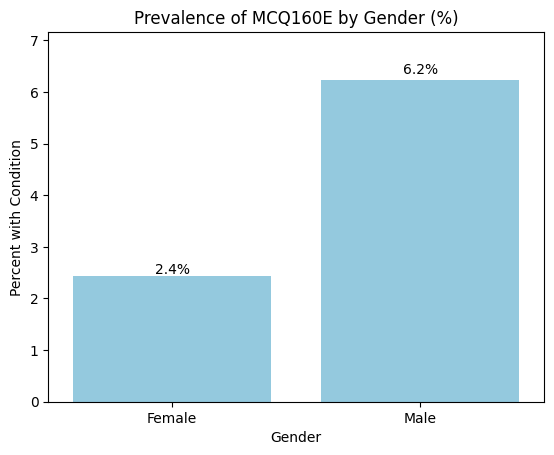

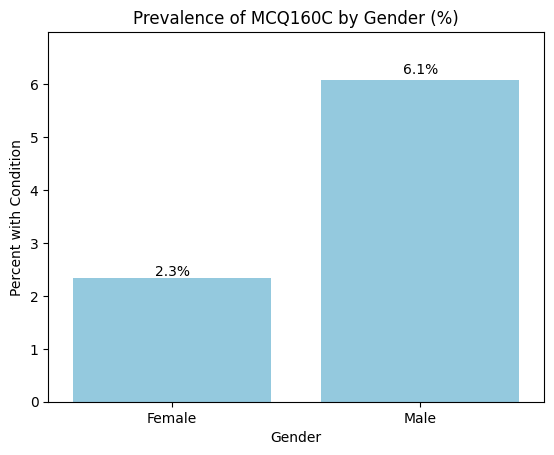

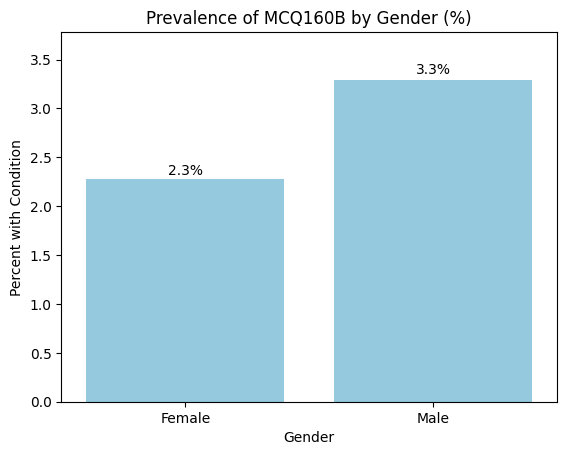

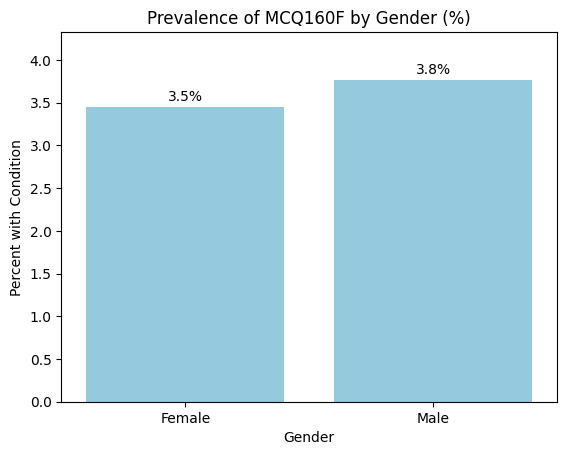

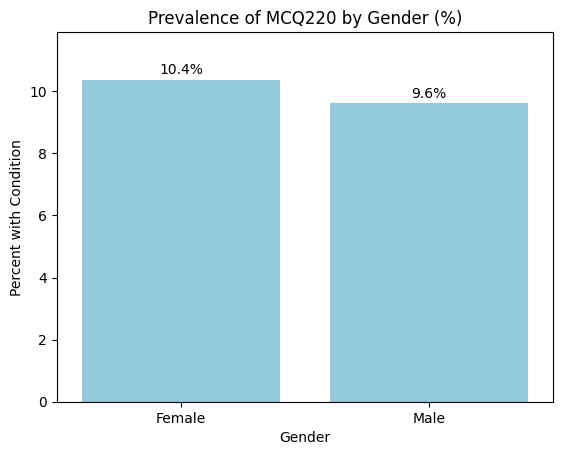

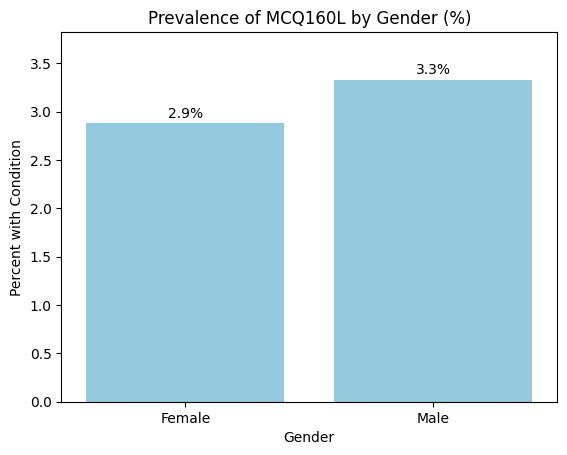

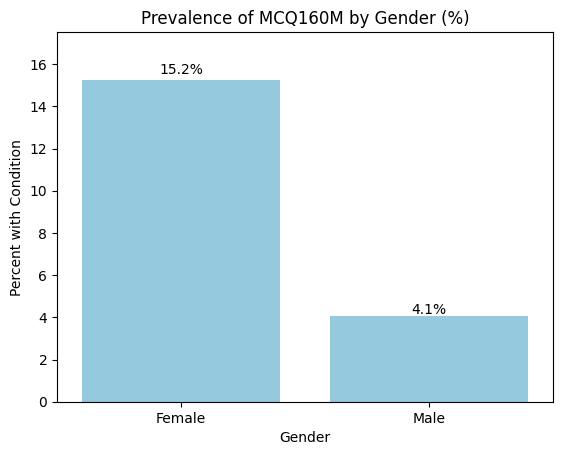

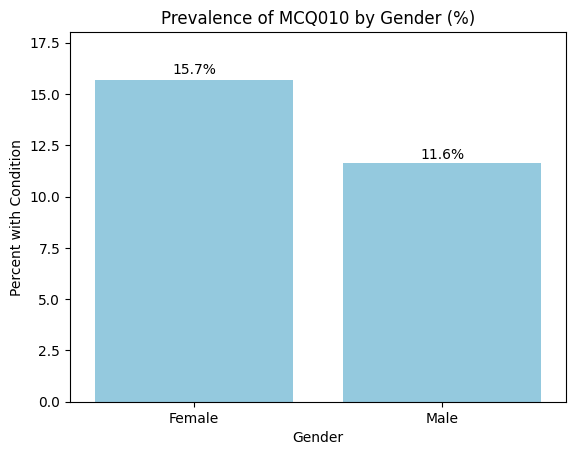

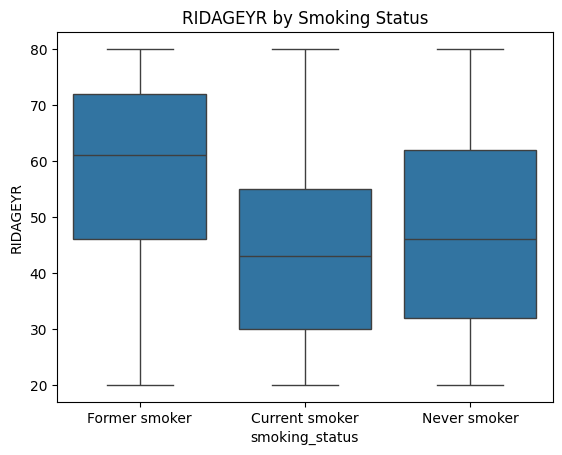

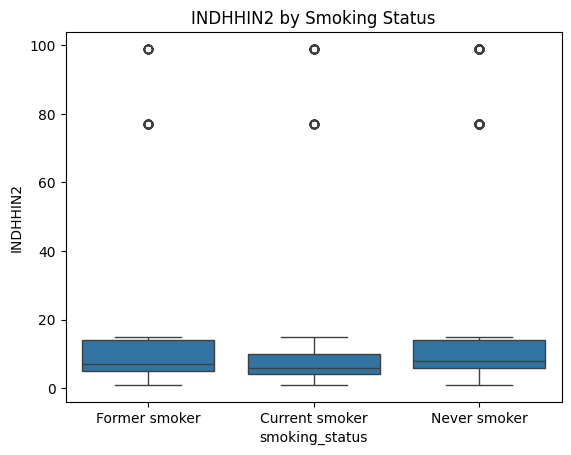

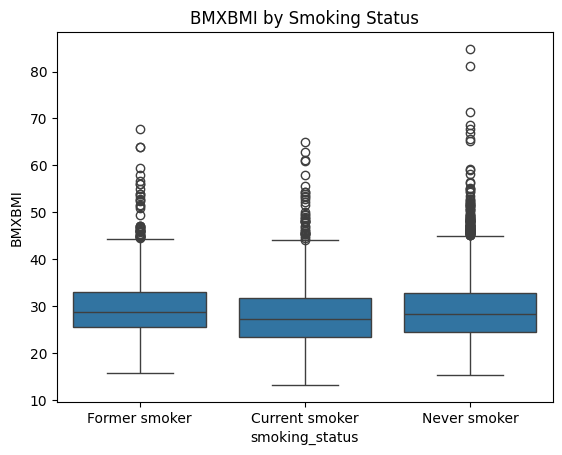

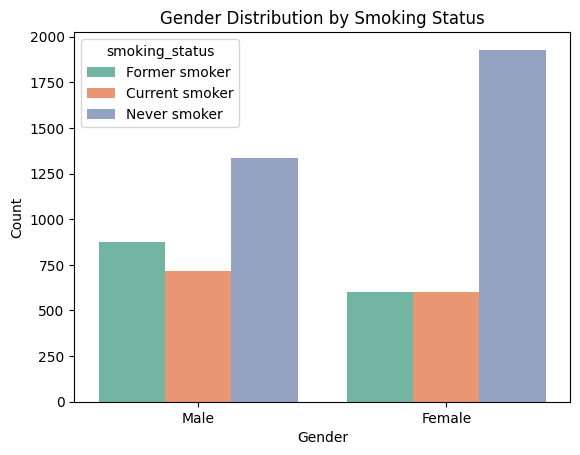

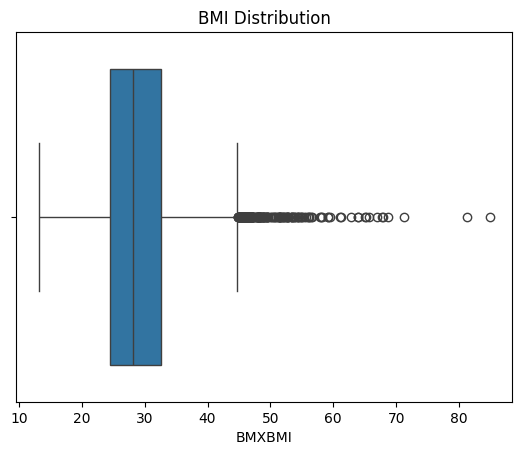

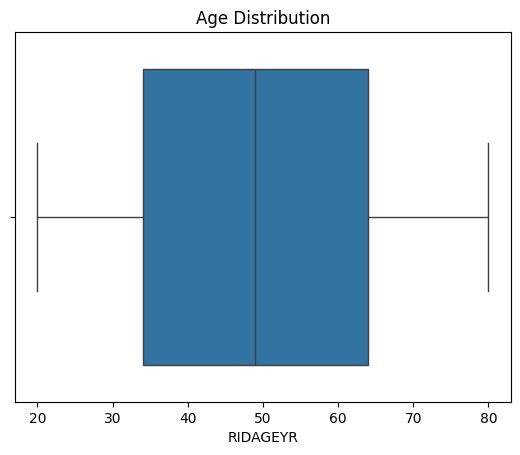

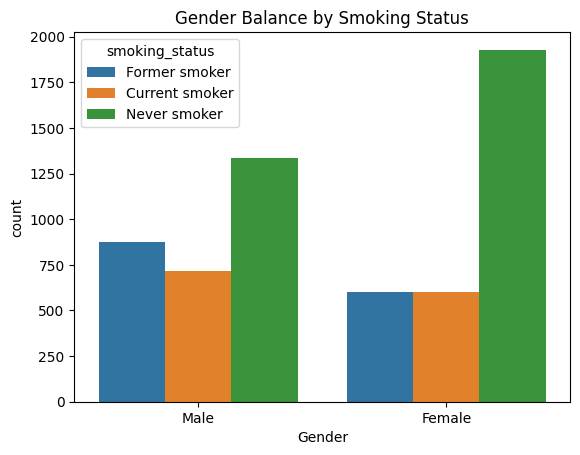

In [ ]:
demo = pd.read_sas('DEMO_F.xpt')
bmx = pd.read_sas('BMX_F.xpt')
mcq = pd.read_sas('MCQ_F.xpt')
smq = pd.read_sas('SMQ_F.xpt')

eda_nhanesData(demo, bmx, mcq, smq)

# Combined Years EDA

do a line plot of smoking rate over time or average BMI, income, or disease prevalence by year.

In [ ]:
def create_MCQ_160O(df):
  if "MCQ160O" not in df.columns:
    print("COPD variable not found — creating proxy from emphysema and chronic bronchitis.")
    df["MCQ160O"] = ((df["MCQ160K"] == 1) | (df["MCQ160G"] == 1)).astype(int)


In [ ]:
def drop_mcq_specific_cols(df):
    if "MCQ500" in df.columns:
        print('Dropping MCQ500')
        df.drop('MCQ500', axis = 1, inplace=True)
    elif 'MCQ160L' in df.columns:
        print('Dropping MCQ160L')
        df.drop('MCQ160L', axis = 1, inplace=True)
    else:
        None


In [ ]:
demo_2009_2010 = pd.read_sas('DEMO_F.xpt')
demo_2009_2010['year'] = '2009-2010'
demo_2009_2010 = demo_2009_2010[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", 'year']]

demo_2011_2012 = pd.read_sas('DEMO_G.xpt')
demo_2011_2012['year'] = '2011-2012'
demo_2011_2012 = demo_2011_2012[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", 'year']]

demo_2013_2014 = pd.read_sas('DEMO_H.xpt')
demo_2013_2014['year'] = '2013-2014'
demo_2013_2014 = demo_2013_2014[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", 'year']]

demo_2015_2016 = pd.read_sas('DEMO_I.xpt')
demo_2015_2016['year'] = '2015-2016'
demo_2015_2016 = demo_2015_2016[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", 'year']]

demo_2017_2018 = pd.read_sas('DEMO_J.xpt')
demo_2017_2018['year'] = '2017-2018'
demo_2017_2018 = demo_2017_2018[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", 'year']]


bmx_2009_2010 = pd.read_sas('BMX_F.xpt')
bmx_2009_2010['year'] = '2009-2010'
bmx_2009_2010 = bmx_2009_2010[["SEQN","BMXBMI", 'year']]

bmx_2011_2012 = pd.read_sas('BMX_G.xpt')
bmx_2011_2012['year'] = '2011-2012'
bmx_2011_2012 = bmx_2011_2012[["SEQN","BMXBMI", 'year']]

bmx_2013_2014 = pd.read_sas('BMX_H.xpt')
bmx_2013_2014['year'] = '2013-2014'
bmx_2013_2014 = bmx_2013_2014[["SEQN","BMXBMI", 'year']]


bmx_2015_2016 = pd.read_sas('BMX_I.xpt')
bmx_2015_2016['year'] = '2015-2016'
bmx_2015_2016 = bmx_2015_2016[["SEQN","BMXBMI", 'year']]

bmx_2017_2018 = pd.read_sas('BMX_J.xpt')
bmx_2017_2018['year'] = '2017-2018'
bmx_2017_2018 = bmx_2017_2018[["SEQN","BMXBMI", 'year']]


mcq_2009_2010 = pd.read_sas('MCQ_F.xpt')
mcq_2009_2010['year'] = '2009-2010'
create_MCQ_160O(mcq_2009_2010)
drop_mcq_specific_cols(mcq_2009_2010)
mcq_2009_2010 = mcq_2009_2010[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M","MCQ010"]]


mcq_2011_2012 = pd.read_sas('MCQ_G.xpt')
mcq_2011_2012['year'] = '2011-2012'
create_MCQ_160O(mcq_2011_2012)
drop_mcq_specific_cols(mcq_2011_2012)
mcq_2011_2012 = mcq_2011_2012[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M","MCQ010"]]


mcq_2013_2014 = pd.read_sas('MCQ_H.xpt')
mcq_2013_2014['year'] = '2013-2014'
create_MCQ_160O(mcq_2013_2014)
drop_mcq_specific_cols(mcq_2013_2014)
mcq_2013_2014 = mcq_2013_2014[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M","MCQ010"]]


mcq_2015_2016 = pd.read_sas('MCQ_I.xpt')
mcq_2015_2016['year'] = '2015-2016'
create_MCQ_160O(mcq_2015_2016)
drop_mcq_specific_cols(mcq_2015_2016)
mcq_2015_2016 = mcq_2015_2016[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M","MCQ010"]]


mcq_2017_2018 = pd.read_sas('MCQ_J.xpt')
mcq_2017_2018['year'] = '2017-2018'
create_MCQ_160O(mcq_2017_2018)
drop_mcq_specific_cols(mcq_2017_2018)
mcq_2017_2018 = mcq_2017_2018[["SEQN", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M","MCQ010"]]


smq_2009_2010 = pd.read_sas('SMQ_F.xpt')
smq_2009_2010['year'] = '2009-2010'
smq_2009_2010 = smq_2009_2010[["SEQN","SMQ040", "SMQ020"]]

smq_2011_2012 = pd.read_sas('SMQ_G.xpt')
smq_2011_2012['year'] = '2011-2012'
smq_2011_2012 = smq_2011_2012[["SEQN","SMQ040", "SMQ020"]]

smq_2013_2014 = pd.read_sas('SMQ_H.xpt')
smq_2013_2014['year'] = '2013-2014'
smq_2013_2014 = smq_2013_2014[["SEQN","SMQ040", "SMQ020"]]

smq_2015_2016 = pd.read_sas('SMQ_I.xpt')
smq_2015_2016['year'] = '2015-2016'
smq_2015_2016 = smq_2015_2016[["SEQN","SMQ040", "SMQ020"]]

smq_2017_2018 = pd.read_sas('SMQ_J.xpt')
smq_2017_2018['year'] = '2017-2018'
smq_2017_2018 = smq_2017_2018[["SEQN","SMQ040", "SMQ020"]]


demo_all_years = pd.concat([demo_2009_2010, demo_2011_2012,  demo_2013_2014, demo_2015_2016, demo_2017_2018])
bmx_all_years = pd.concat([bmx_2009_2010, bmx_2011_2012,  bmx_2013_2014, bmx_2015_2016, bmx_2017_2018])
mcq_all_years = pd.concat([mcq_2009_2010, mcq_2011_2012, mcq_2013_2014, mcq_2015_2016, mcq_2017_2018])
smq_all_years = pd.concat([smq_2009_2010, smq_2011_2012, smq_2013_2014, smq_2015_2016, smq_2017_2018])



COPD variable not found — creating proxy from emphysema and chronic bronchitis.
Dropping MCQ160L
COPD variable not found — creating proxy from emphysema and chronic bronchitis.
Dropping MCQ160L
Dropping MCQ160L
Dropping MCQ160L
Dropping MCQ500


# NEED TO SUBSET FOR SPECIFIC COLUMNS BEFORE CONCATENATION


In [ ]:
print('demo length:', len(demo_all_years), ', bmx length:', len(bmx_all_years), ', mcq length:', len(mcq_all_years), ', smq length:', len(smq_all_years))

demo length: 49693 , bmx length: 47652 , mcq length: 47715 , smq length: 35211


In [ ]:
merge1 = pd.merge(demo_all_years, bmx_all_years,how='inner', on = 'SEQN')
merge2 = pd.merge(merge1, mcq_all_years, how='inner', on = 'SEQN')
merge3 = pd.merge(merge2, smq_all_years, how='inner', on = 'SEQN')
merge3 = merge3.drop('year_y', axis = 1)
merge3 = merge3.rename(columns = {'year_x' :'year'})

full_df = merge3.copy()
full_df['smoking_status'] = full_df.apply(classify_smoking_status, axis=1)
full_df = full_df[full_df['smoking_status'].notnull()]
full_df['Gender'] = full_df['RIAGENDR'].map({1: 'Male', 2: 'Female'})

race_map = {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        5: "Other / Multi-Racial"
    }

full_df['Race_Ethnicity'] = full_df['RIDRETH1'].map(race_map)

print('Number of observations in dataset: ', len(full_df))
print()
full_df

Number of observations in dataset:  28551



SEQN  RIDAGEYR  RIAGENDR  RIDRETH1  INDHHIN2       year  BMXBMI  \
0       51624.0      34.0       1.0       3.0       6.0  2009-2010   32.22   
2       51628.0      60.0       2.0       4.0       3.0  2009-2010   42.39   
3       51629.0      26.0       1.0       1.0       6.0  2009-2010   32.61   
4       51630.0      49.0       2.0       3.0       7.0  2009-2010   30.57   
5       51633.0      80.0       1.0       3.0       4.0  2009-2010   26.04   
...         ...       ...       ...       ...       ...        ...     ...   
34036  102949.0      33.0       1.0       3.0       6.0  2017-2018   23.70   
34037  102952.0      70.0       2.0       5.0       4.0  2017-2018   20.00   
34038  102953.0      42.0       1.0       1.0      12.0  2017-2018   35.80   
34039  102954.0      41.0       2.0       4.0      10.0  2017-2018   26.10   
34041  102956.0      38.0       1.0       3.0       7.0  2017-2018   36.10   

       MCQ160O  MCQ160K  MCQ160E  ...  MCQ160B  MCQ160F  MCQ220  MCQ160M  \
0          0.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
2          0.0      2.0      2.0  ...      2.0      2.0     2.0      1.0   
3          0.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
4          0.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
5          0.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
...        ...      ...      ...  ...      ...      ...     ...      ...   
34036      2.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
34037      2.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
34038      2.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
34039      2.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   
34041      2.0      2.0      2.0  ...      2.0      2.0     2.0      2.0   

       MCQ010  SMQ040  SMQ020  smoking_status  Gender        Race_Ethnicity  
0         2.0     3.0     1.0   Former smoker    Male    Non-Hispanic White  
2         2.0     1.0     1.0  Current smoker  Female    Non-Hispanic Black  
3         2.0     3.0     1.0   Former smoker    Male      Mexican American  
4         2.0     1.0     1.0  Current smoker  Female    Non-Hispanic White  
5         2.0     3.0     1.0   Former smoker    Male    Non-Hispanic White  
...       ...     ...     ...             ...     ...                   ...  
34036     2.0     1.0     1.0  Current smoker    Male    Non-Hispanic White  
34037     2.0     NaN     2.0    Never smoker  Female  Other / Multi-Racial  
34038     1.0     3.0     1.0   Former smoker    Male      Mexican American  
34039     2.0     NaN     2.0    Never smoker  Female    Non-Hispanic Black  
34041     2.0     1.0     1.0  Current smoker    Male    Non-Hispanic White  

[28551 rows x 21 columns]

## Function for EDA

In [ ]:
def eda_nhanesData(full_df):

    print('Number of observations in dataset: ', len(full_df))
    print()

    all_exSEQN = full_df.iloc[:,1:]

    print('Percent of missing values in each variable')
    print(all_exSEQN.isna().mean().sort_values(ascending=False))
    print()

    print('Summary of each variable')
    print(all_exSEQN.describe())
    print()
    print('# of respondents by smoking status')
    print(all_exSEQN.groupby(['smoking_status']).size())
    print('# and % of respondents by smoking status')
    smoking_counts = all_exSEQN['smoking_status'].value_counts(dropna=False)
    smoking_percent = smoking_counts / smoking_counts.sum() * 100

    summary_df = pd.DataFrame({
        'Count': smoking_counts,
        'Percent': smoking_percent.round(2)
    })

    print(summary_df)


    print()
    print("Gender")
    print()
    print(all_exSEQN["Gender"].value_counts()/len(all_exSEQN)*100)


    print()
    print("Race Ethnicity")
    print()
    print(all_exSEQN["Race_Ethnicity"].value_counts()/len(all_exSEQN)*100)
    bins = list(range(0, 100, 10))
    labels = [f"{b}-{b+9}" for b in bins[:-1]]
    all_exSEQN['AgeGroup'] = pd.cut(all_exSEQN['RIDAGEYR'], bins=bins, labels=labels, right=False)
    age_group_counts = all_exSEQN['AgeGroup'].value_counts(dropna=False).sort_index()
    age_group_percent = (age_group_counts / age_group_counts.sum()) * 100

    age_group_table = pd.DataFrame({
        "Count": age_group_counts,
        "Percent": age_group_percent.round(2)
    })

    print("Proportion of Each Age Group in Full Dataset")
    print(age_group_table)
    print()

    age_filtered = all_exSEQN[all_exSEQN['AgeGroup'] != "0-9"].copy()
    age_filtered['AgeGroup'] = age_filtered['AgeGroup'].cat.remove_unused_categories()

    age_smoke_counts = (
        age_filtered
        .groupby(['AgeGroup', 'smoking_status'])
        .size()
        .reset_index(name='count')
    )

    age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')
    age_smoke_counts['proportion'] = age_smoke_counts['count'] / age_group_totals

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=age_smoke_counts,
        x='AgeGroup',
        y='proportion',
        hue='smoking_status',
        palette='Set2'
    )
    plt.title("Proportion of Smoking Status by Age Group")
    plt.ylabel("Proportion within Age Group")
    plt.xlabel("Age Group")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.legend(title="Smoking Status")
    plt.show()

    sns.histplot(data = all_exSEQN, x= "RIDAGEYR", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Age by Smoking Category")
    plt.show()


    mean_bmi = all_exSEQN.groupby('smoking_status')['BMXBMI'].mean()
    median_bmi = all_exSEQN.groupby('smoking_status')['BMXBMI'].median()

    bmi_summary = pd.DataFrame({
        'Mean BMI': mean_bmi,
        'Median BMI': median_bmi
    }).round(2)

    print('BMI Summary')
    print(bmi_summary)
    print()

    sns.histplot(data = all_exSEQN, x= "BMXBMI", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of BMI by Smoking Category")
    plt.show()


    sns.histplot(data = all_exSEQN, x= "Gender", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Smoking Category by Gender")
    plt.show()

    ethnicity_smoke_counts = (
        all_exSEQN
        .groupby(['Race_Ethnicity', 'smoking_status'])
        .size()
        .reset_index(name='count')
    )

    ethnicity_group_totals = ethnicity_smoke_counts.groupby('Race_Ethnicity')['count'].transform('sum')
    ethnicity_smoke_counts['proportion'] = ethnicity_smoke_counts['count'] / ethnicity_group_totals

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=ethnicity_smoke_counts,
        x='Race_Ethnicity',
        y='proportion',
        hue='smoking_status',
        palette='Set2'
    )
    plt.title("Proportion of Smoking Status by Ethnicity")
    plt.ylabel("Proportion within Ethnicity")
    plt.xlabel("Ethnicity")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.legend(title="Smoking Status")
    plt.show()

    mean_annual_income = all_exSEQN.groupby('smoking_status')['INDHHIN2'].mean()
    median_annual_income = all_exSEQN.groupby('smoking_status')['INDHHIN2'].median()

    income_summary = pd.DataFrame({
        'Mean Annual Income': mean_annual_income,
        'Median Annual INcome': median_annual_income
    }).round(2)

    print('Income summary')
    print(income_summary)
    print()



    all_exSEQN_less20 = all_exSEQN[all_exSEQN["INDHHIN2"] < 20]
    sns.displot(data = all_exSEQN_less20, x= "INDHHIN2", hue = "smoking_status", palette='crest', alpha = 0.3, multiple = "stack")
    plt.title("Distribution of Annual Income by Smoking Category")
    plt.show()


    disease_vars = [col for col in all_exSEQN.columns if "MCQ" in col]

    all_exSEQN = all_exSEQN.copy()
    for var in disease_vars:
        all_exSEQN[var] = all_exSEQN[var].replace({1: 1, 2: 0, 7: np.nan, 9: np.nan})

    smoking_order = ["Never smoker", "Former smoker", "Current smoker"]

    for var in disease_vars:
        temp = (
            all_exSEQN
            .groupby("smoking_status")[var]
            .mean()
            .mul(100)
            .reset_index()
            .rename(columns={var: "Prevalence (%)"})
        )

        sns.barplot(data=temp, x="smoking_status", y="Prevalence (%)", color="skyblue", order=smoking_order)
        plt.title(f"Prevalence of {var} by Smoking Status (%)")
        plt.xlabel("Smoking Status")
        plt.ylabel("Percent with Condition")
        plt.xticks(rotation=30)
        plt.show()

    gender_order = ["Female", "Male"]

    for var in disease_vars:
        temp = (
            all_exSEQN
            .groupby("Gender")[var]
            .mean()
            .mul(100)
            .reset_index()
            .rename(columns={var: "Prevalence (%)"})
        )
        sns.barplot(data=temp, x="Gender", y="Prevalence (%)", color="skyblue", order=gender_order)
        plt.title(f"Prevalence of {var} by Gender (%)")
        plt.ylabel("Percent with Condition")
        plt.xlabel("Gender")
        plt.ylim(0, temp["Prevalence (%)"].max() * 1.15)
        for i, p in enumerate(temp["Prevalence (%)"]):
            plt.text(i, p * 1.02, f"{p:.1f}%", ha='center')
        plt.show()

    ethnicity_order = [
        "Mexican American",
        "Other Hispanic",
        "Non-Hispanic White",
        "Non-Hispanic Black",
        "Other / Multi-Racial"
    ]

    print("\n=== Disease Prevalence by Ethnicity (%) ===")

    for var in disease_vars:
        temp = (
            all_exSEQN
            .groupby("Race_Ethnicity")[var]
            .mean()
            .mul(100)
            .reset_index()
            .rename(columns={var: "Prevalence (%)"})
        )

        temp = temp[temp["Race_Ethnicity"].isin(ethnicity_order)]

        sns.barplot(
            data=temp,
            x="Race_Ethnicity",
            y="Prevalence (%)",
            color="skyblue",
            order=ethnicity_order
        )
        plt.title(f"Prevalence of {var} by Ethnicity (%)")
        plt.ylabel("Percent with Condition")
        plt.xlabel("Ethnicity")
        plt.xticks(rotation=30)
        plt.ylim(0, temp["Prevalence (%)"].max() * 1.15)

        for i, p in enumerate(temp["Prevalence (%)"]):
            plt.text(i, p * 1.02, f"{p:.1f}%", ha='center')

        plt.show()

    print("\n=== Smoking Status Distribution Within Each Ethnicity (%) ===")

    smoke_eth_counts = pd.crosstab(
        all_exSEQN["Race_Ethnicity"],
        all_exSEQN["smoking_status"],
        normalize="index"
    ) * 100

    smoke_eth_table = smoke_eth_counts.reindex(ethnicity_order).round(2)

    print(smoke_eth_table)
    print()

    plt.figure(figsize=(8,5))
    sns.heatmap(smoke_eth_table, annot=True, fmt=".1f", cmap="Blues")
    plt.title("Smoking Status (%) by Ethnicity")
    plt.ylabel("Ethnicity")
    plt.xlabel("Smoking Status")
    plt.show()


    confounders = ["RIDAGEYR","INDHHIN2","BMXBMI"]
    for var in confounders:
        sns.boxplot(data=all_exSEQN, x="smoking_status", y=var)
        plt.title(f"{var} by Smoking Status")
        plt.show()

    gender_smoke_counts = all_exSEQN.groupby(['Gender', 'smoking_status']).size().reset_index(name='count')
    gender_totals = gender_smoke_counts.groupby('Gender')['count'].transform('sum')
    gender_smoke_counts['proportion'] = gender_smoke_counts['count'] / gender_totals

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=gender_smoke_counts,
        x='Gender',
        y='proportion',
        hue='smoking_status',
        palette='Set2'
    )
    plt.title("Proportion of Smoking Status by Gender")
    plt.ylim(0,1)
    plt.ylabel("Proportion within Gender")
    plt.xlabel("Gender")
    plt.show()


    sns.boxplot(x=all_exSEQN["BMXBMI"])
    plt.title("BMI Distribution")
    plt.show()

    sns.boxplot(x=all_exSEQN["RIDAGEYR"])
    plt.title("Age Distribution")
    plt.show()

Number of observations in dataset:  28551

Percent of missing values in each variable
SMQ040            0.575777
MCQ160O           0.030297
MCQ160K           0.030297
MCQ160C           0.030297
MCQ160M           0.030297
MCQ160F           0.030297
MCQ220            0.030297
MCQ160E           0.030297
MCQ160B           0.030297
INDHHIN2          0.022276
BMXBMI            0.013835
RIDAGEYR          0.000000
RIDRETH1          0.000000
RIAGENDR          0.000000
year              0.000000
MCQ010            0.000000
SMQ020            0.000000
smoking_status    0.000000
Gender            0.000000
Race_Ethnicity    0.000000
dtype: float64

Summary of each variable
           RIDAGEYR      RIAGENDR      RIDRETH1      INDHHIN2        BMXBMI  \
count  28551.000000  28551.000000  28551.000000  27915.000000  28156.000000   
mean      48.692060      1.516935      3.105005     11.677521     29.186895   
std       18.244802      0.499722      1.213572     16.032170      7.100652   
min       18.0000

/tmp/ipython-input-3239020534.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['AgeGroup', 'smoking_status'])
/tmp/ipython-input-3239020534.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_totals = age_smoke_counts.groupby('AgeGroup')['count'].transform('sum')


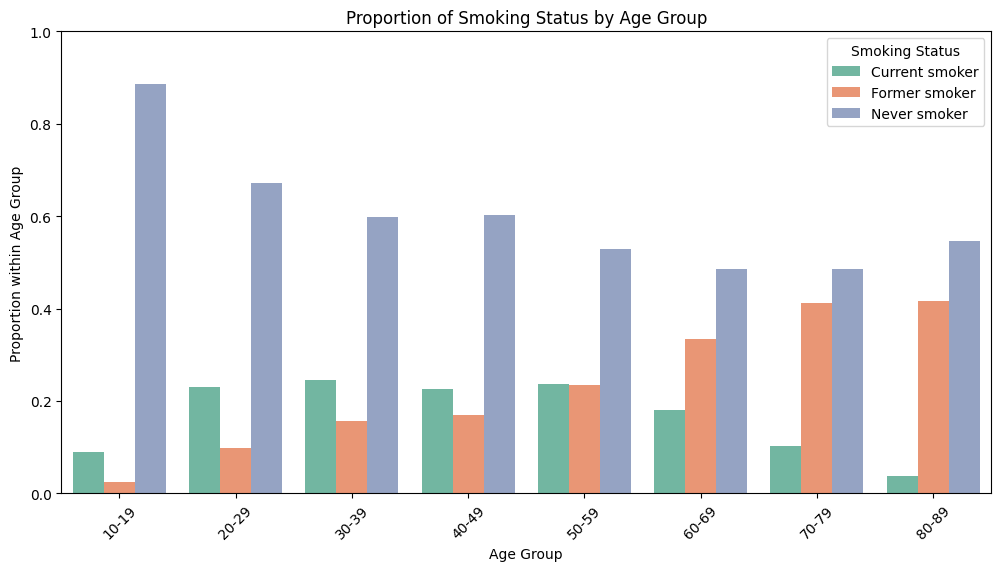

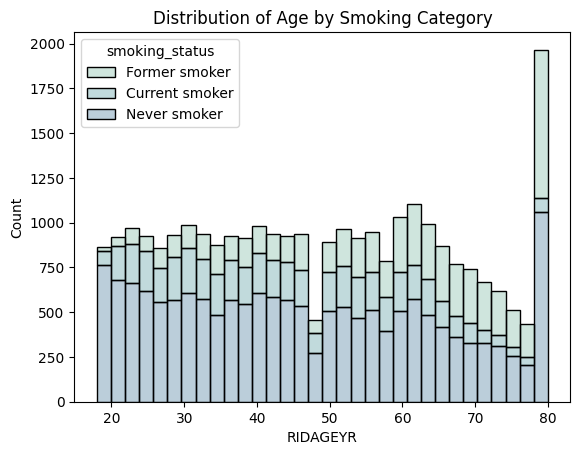

BMI Summary
                Mean BMI  Median BMI
smoking_status                      
Current smoker     28.45        27.3
Former smoker      29.98        28.8
Never smoker       29.13        28.0



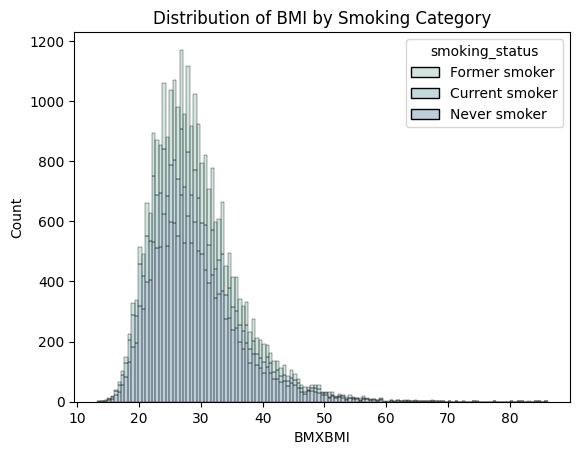

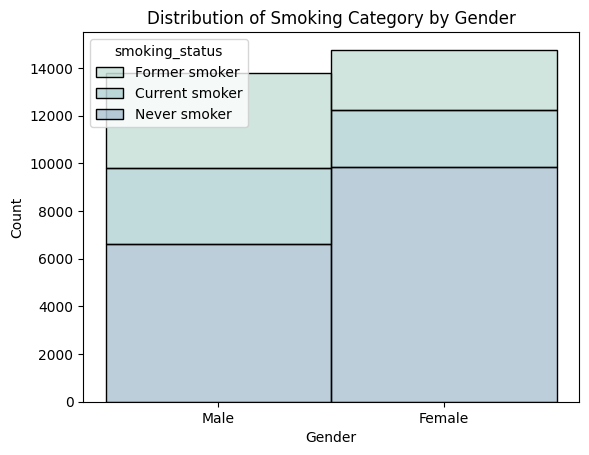

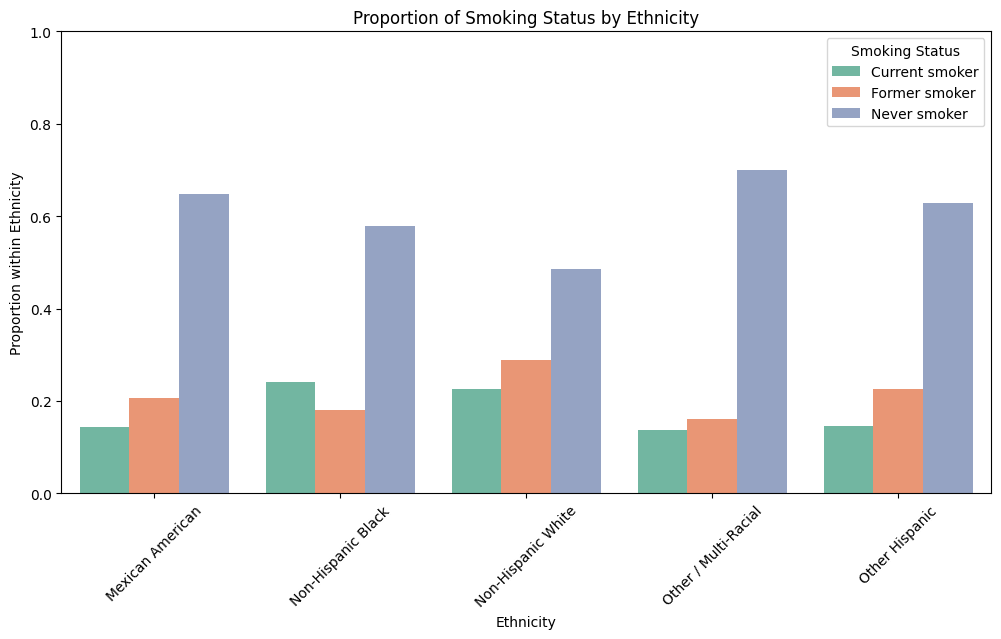

Income summary
                Mean Annual Income  Median Annual INcome
smoking_status                                          
Current smoker               10.13                   6.0
Former smoker                11.00                   8.0
Never smoker                 12.47                   9.0



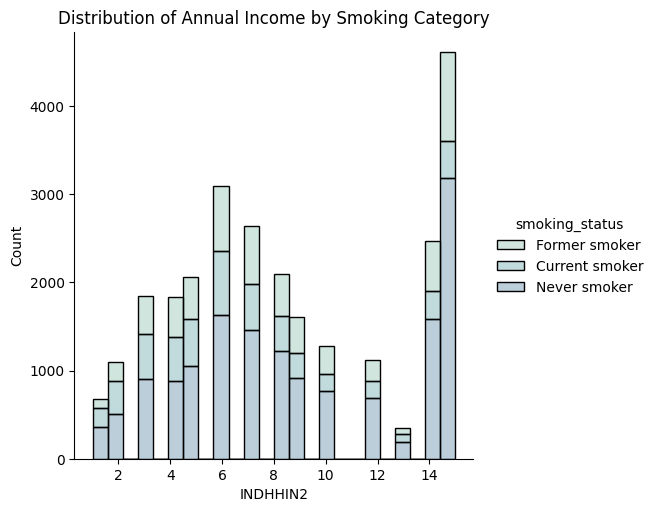

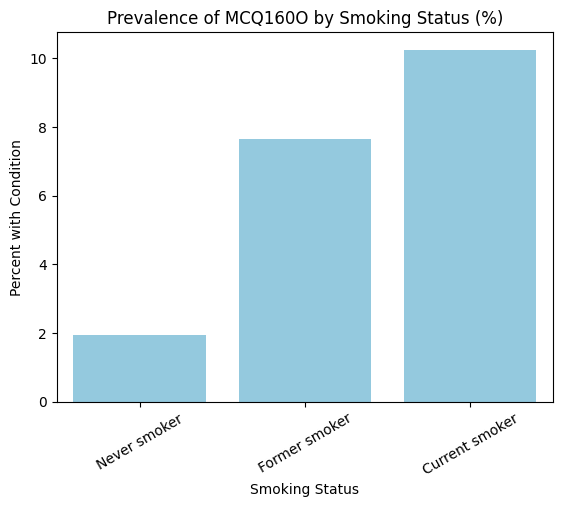

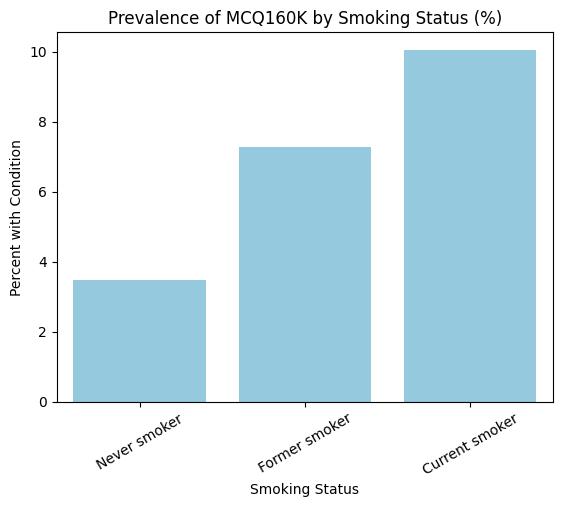

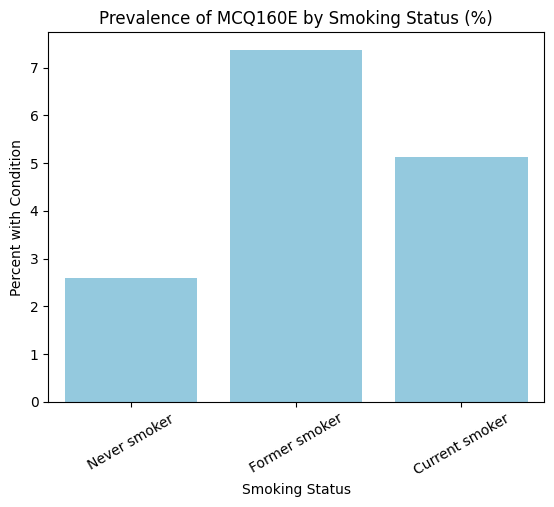

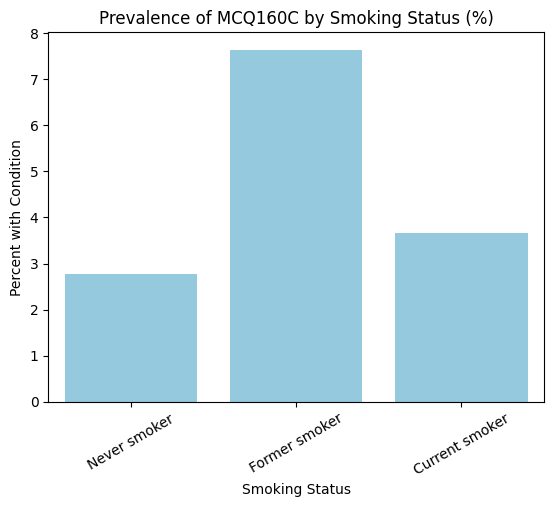

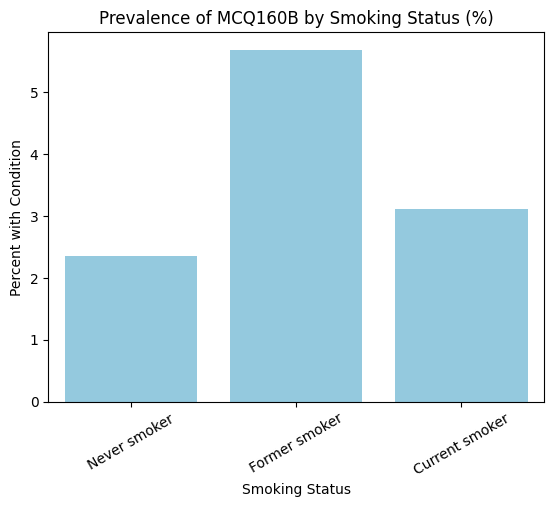

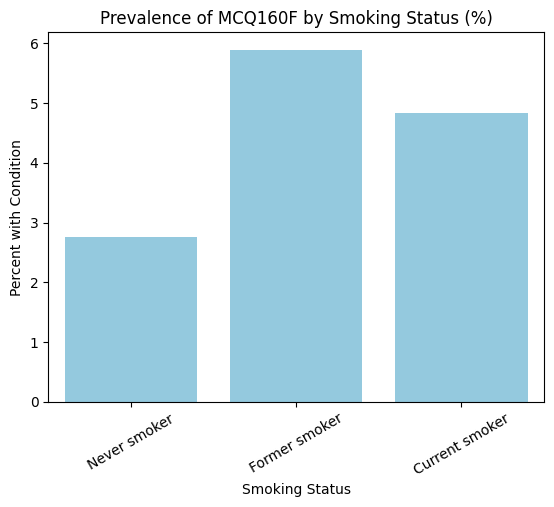

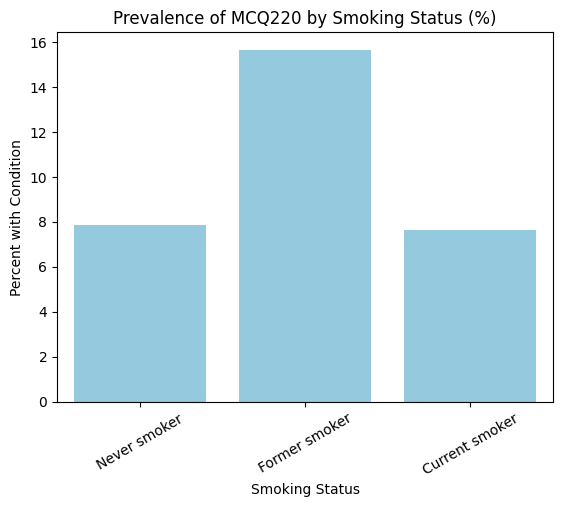

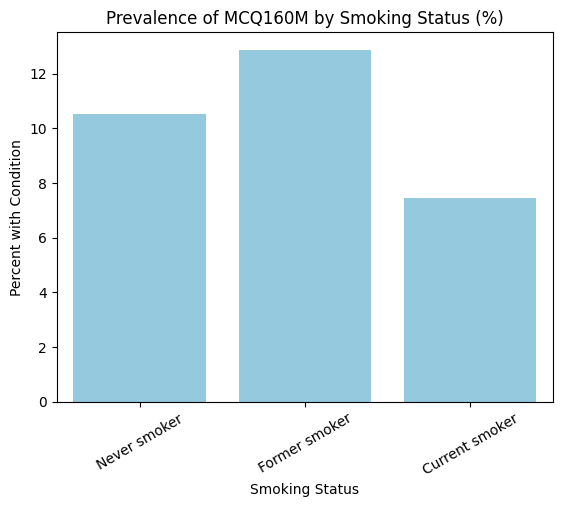

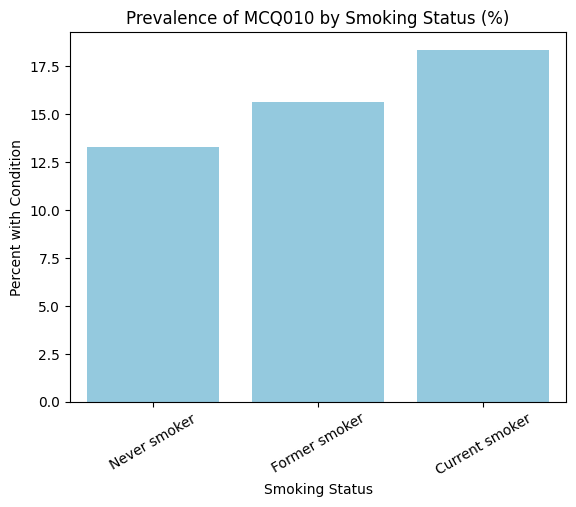

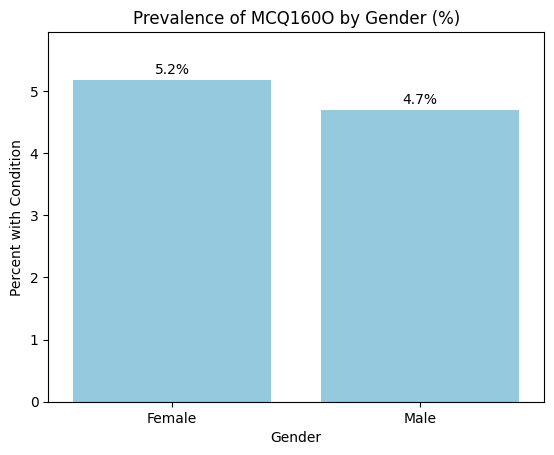

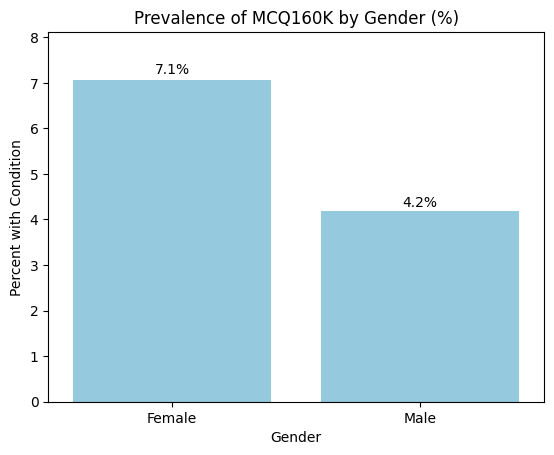

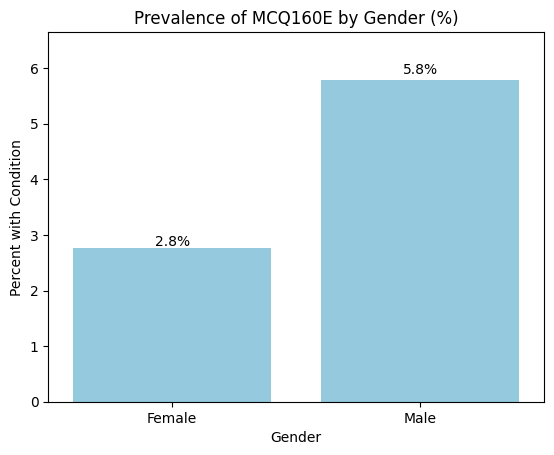

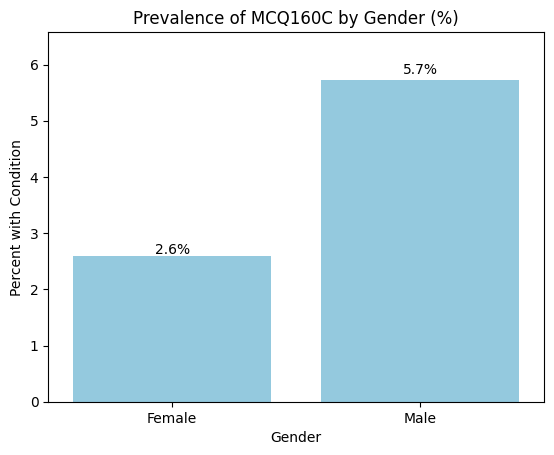

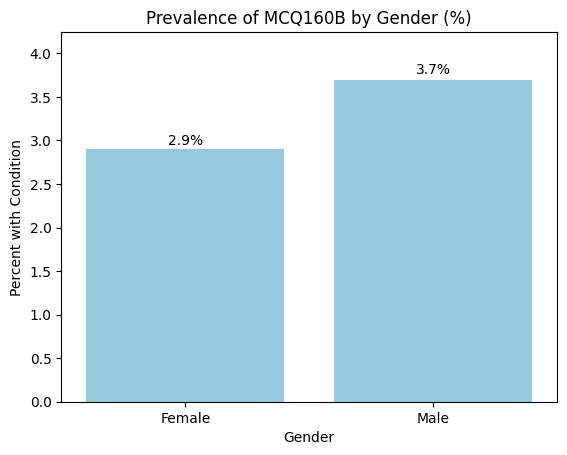

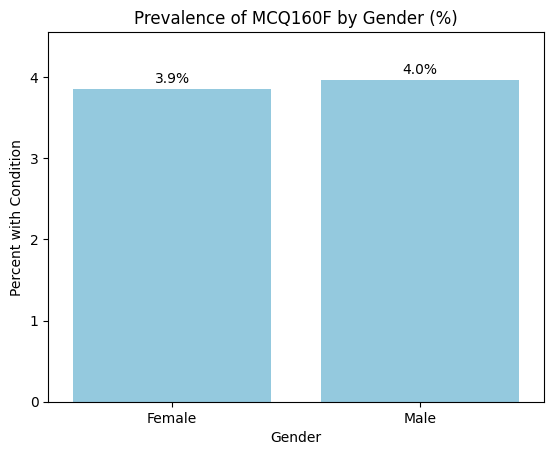

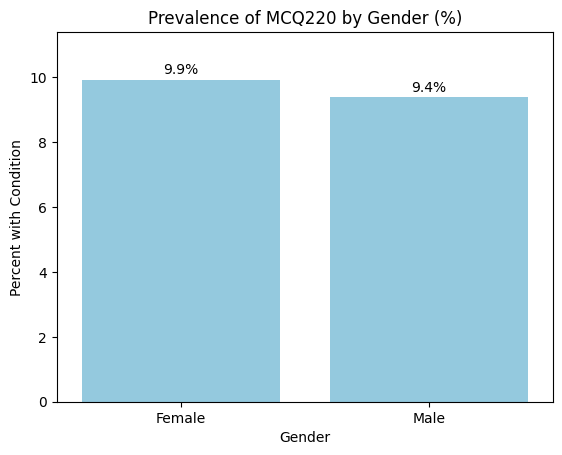

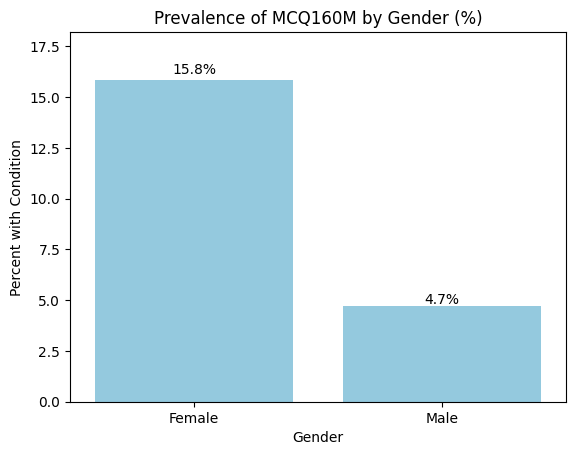

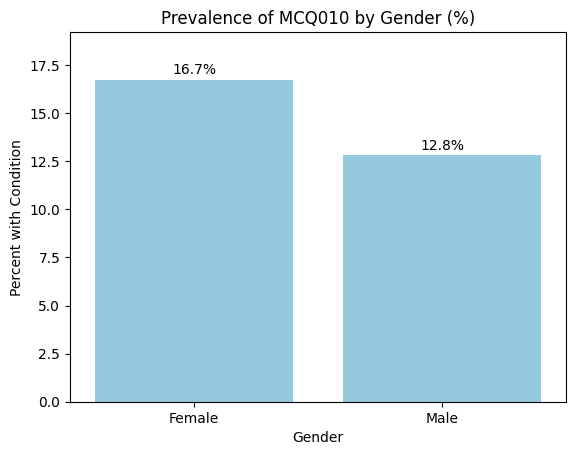


=== Disease Prevalence by Ethnicity (%) ===


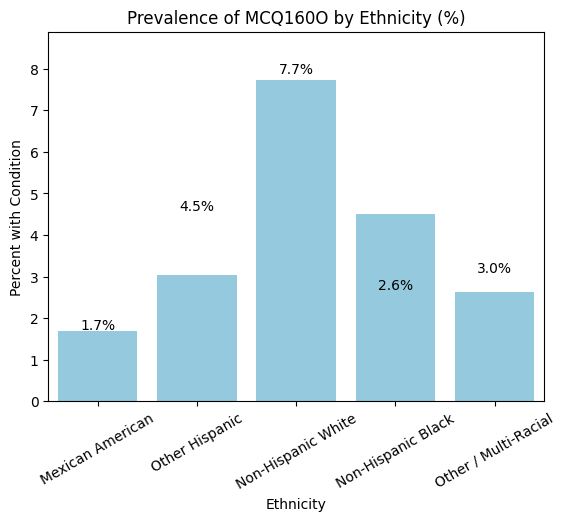

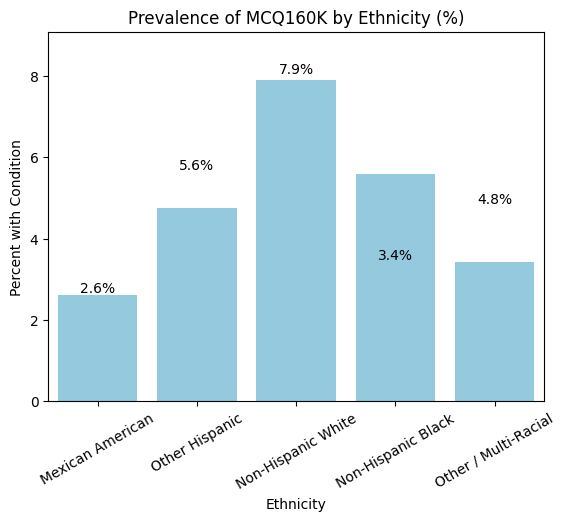

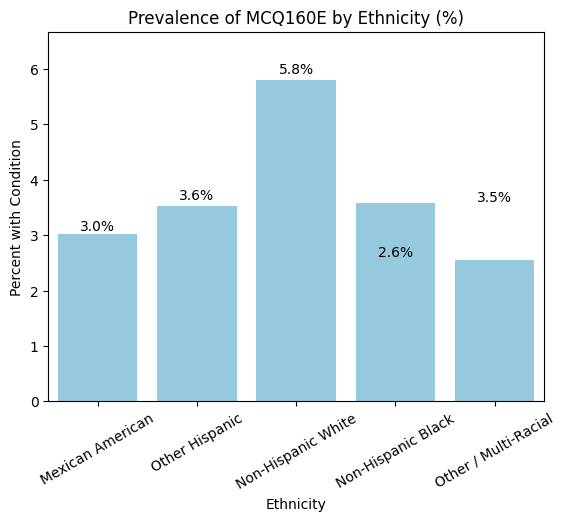

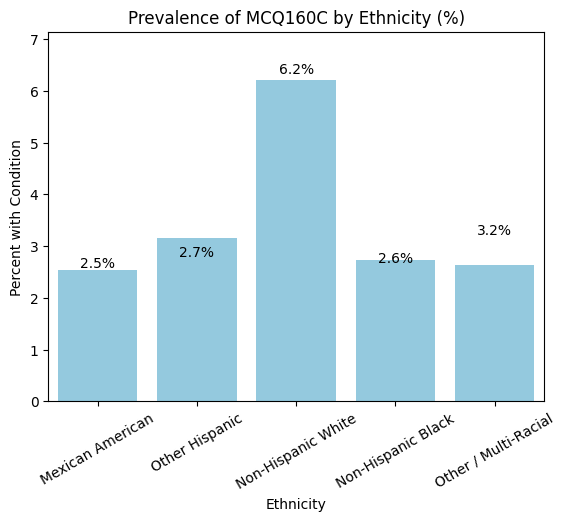

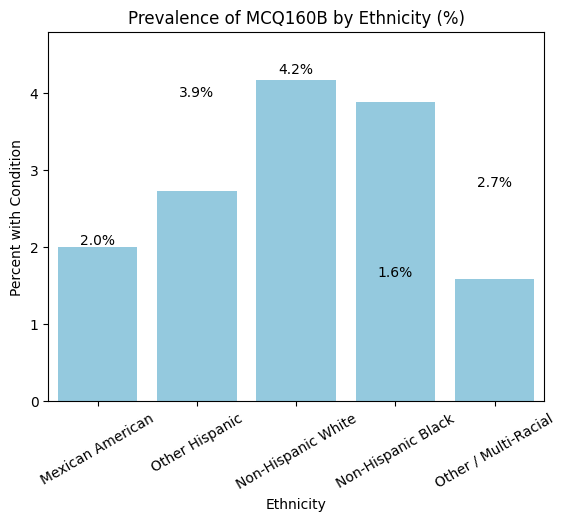

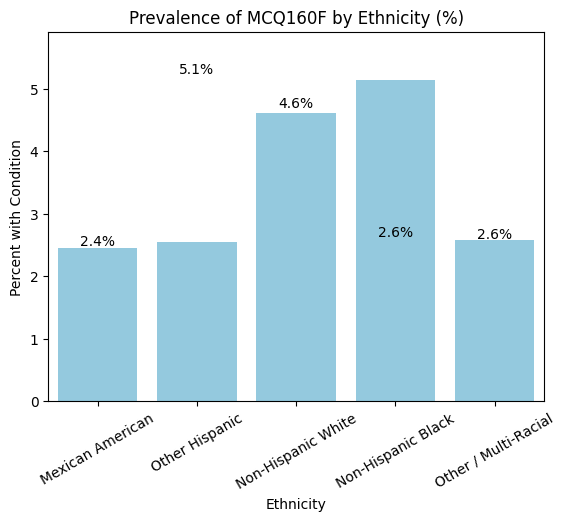

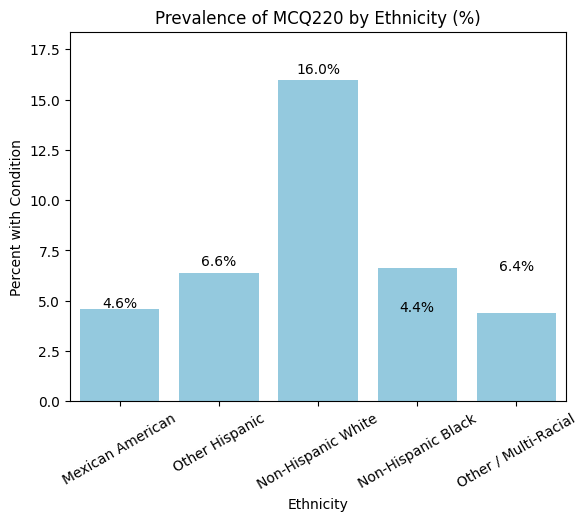

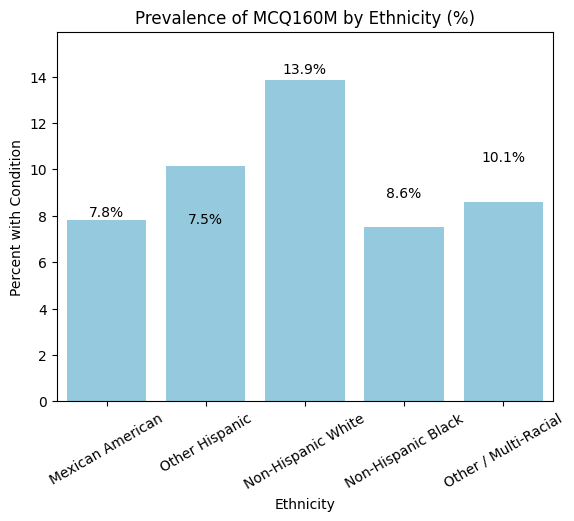

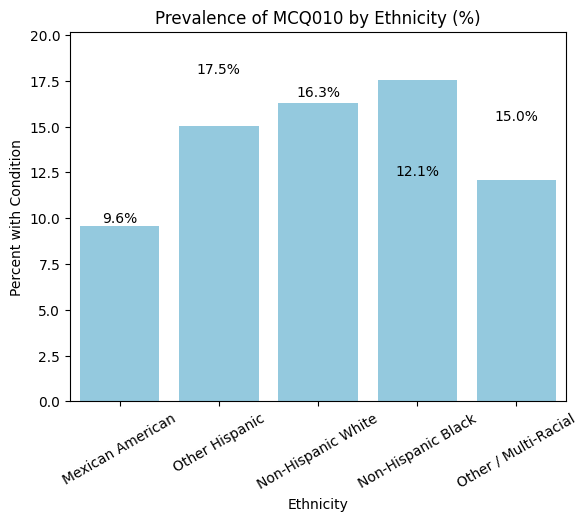


=== Smoking Status Distribution Within Each Ethnicity (%) ===
smoking_status        Current smoker  Former smoker  Never smoker
Race_Ethnicity                                                   
Mexican American               14.46          20.67         64.87
Other Hispanic                 14.49          22.57         62.93
Non-Hispanic White             22.55          28.79         48.66
Non-Hispanic Black             24.05          18.16         57.79
Other / Multi-Racial           13.73          16.20         70.07



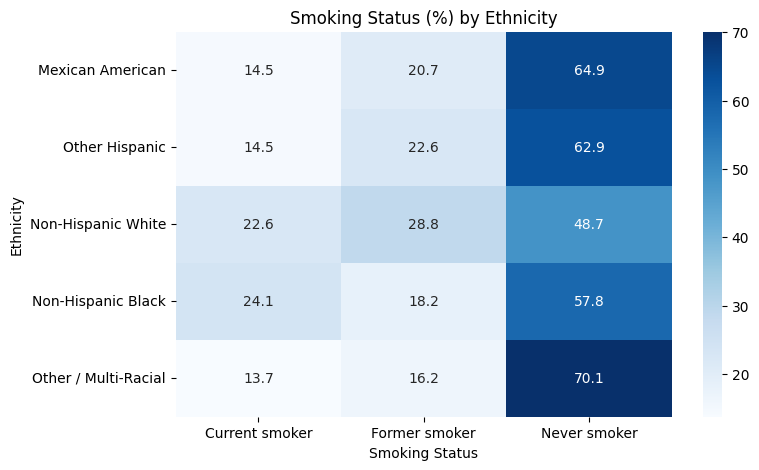

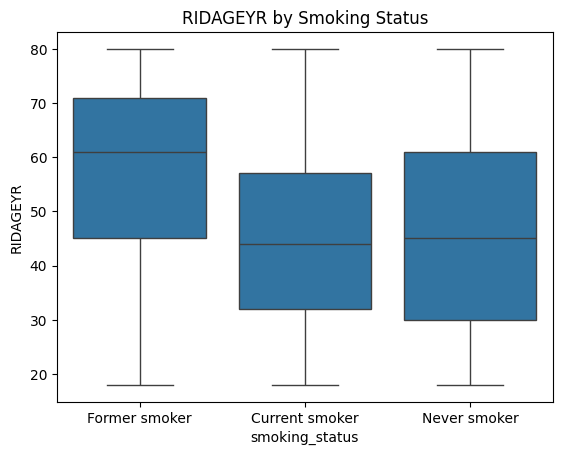

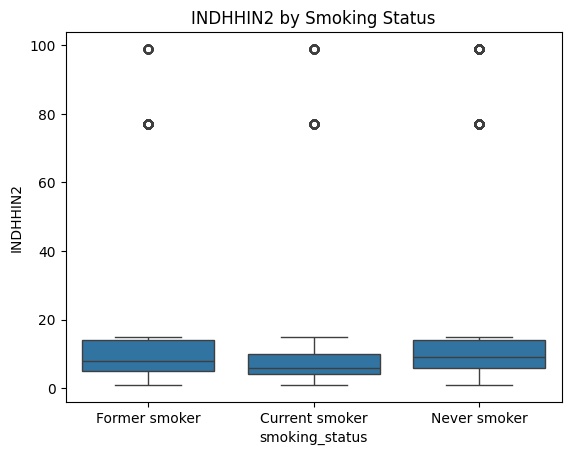

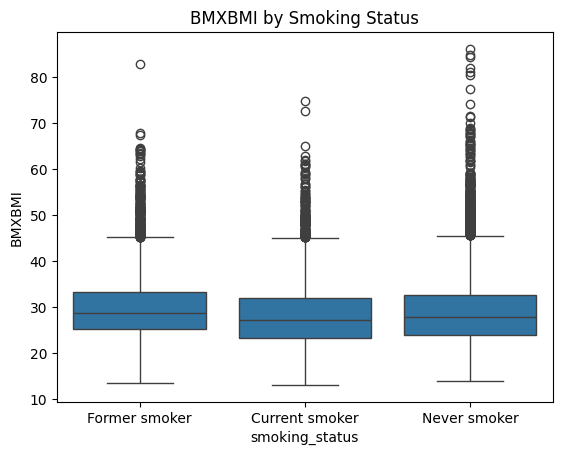

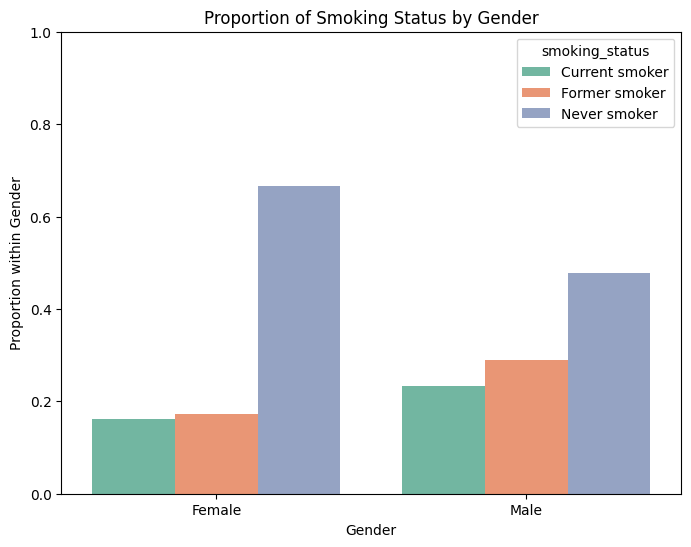

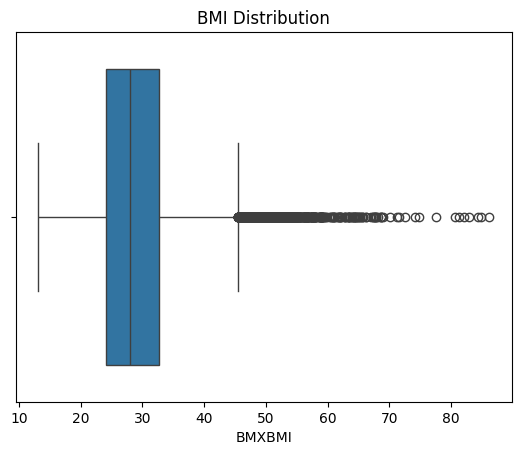

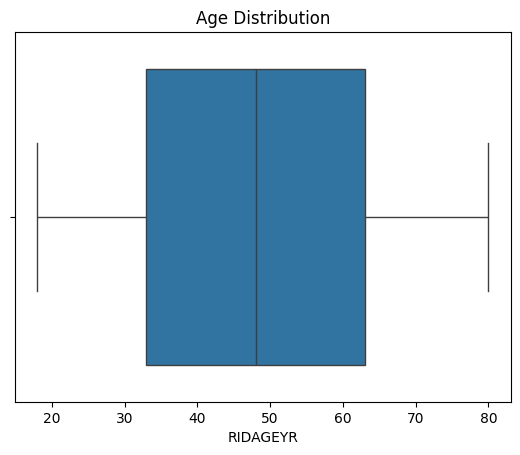

In [ ]:
eda_nhanesData(full_df)

Takeaways:
1. 28551 observations / individuals are included in the dataset.
2. SMQ040 has about 58% of its values missing. Other variables have quite low missingness (between 0 - 3%). The final dataset ensures no missing values for the smoking_status field.                        
4. The mean age is about 49 years; the median age is 48 years.
5. Former smokers have the highest median age. Never smokers and current smokers have very similar median ages, with never smokers having a slightly higher median age than current smokers.
6. 52% of respondents are female; 48% are male.
7. Race / ethnicity distribution: 39% Non-Hispanic White, 22% Non-Hispanic Black, 15% Mexican American, 14% Other / Multi-Racial, 10% Other Hispanic.
8. Across all age groups, there are more never smokers than current or former smokers.
9. Age groups: Ages 10–49: more current smokers than former smokers. Age groups 50-59: same percent of current and former smokers. Age groups 59–89: more former smokers than current smokers.
10. BMI is right-skewed across all smoking statuses. Median BMI: current smokers 27.3, former smokers 28.8, and never smokers 28.0.
11. Gender patterns in smoking:
*   Higher proportion of females have never smoked compared to males.
*   Lower proportion of females are former smokers compared to males.
*   Lower proportion of females are current smokers compared to males.
12. Race / ethnicity patterns in smoking:
*   More never smokers than current or former smokers in all groups.
*   Mexican American, Non-Hispanic White, Other Hispanic, Other/Multi-Racial: more former smokers than current smokers.
*   Non-Hispanic Black: more current smokers than former smokers.

13. Annual income is right-skewed across all smoking statuses. Median income: highest are for never smokers (8), followed by former smokers (7), and lastly current smokers (6).
14. Disease prevalence by smoking status:



*   MCQ160O, MCQ160K, MCQ010: higher prevalence in current smokers than former or never smokers.
*   MCQ160E, MCQ160C, MCQ160B, MCQ220, MCQ160M, MCQ160F: higher prevalence in former smokers than current or never smokers.

# Saving final data, including only columns we absolutely need

In [ ]:
full_df.columns

Index(['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'INDHHIN2', 'year',
       'BMXBMI', 'MCQ160O', 'MCQ160K', 'MCQ160E', 'MCQ160C', 'MCQ160B',
       'MCQ160F', 'MCQ220', 'MCQ160M', 'MCQ010', 'SMQ040', 'SMQ020',
       'smoking_status', 'Gender', 'Race_Ethnicity'],
      dtype='object')

In [ ]:
final_df_all_years = full_df[["smoking_status", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", "BMXBMI", "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M", "MCQ010"]]